In [1]:
import numpy as np 
import pandas as pd 

import os

import cv2
from sklearn.model_selection import train_test_split
from sklearn import datasets

from torch.backends import cudnn
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import random
import numpy as np
import torchvision as tv
from torch.utils.data import TensorDataset,DataLoader

import torchvision
import torchvision.datasets as Dataset
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
from tqdm import tqdm
import copy
import torchvision as tv
import cv2
from torch.utils.data import random_split
import pandas as pd
import os
from torch.utils.data import TensorDataset

import skimage.io as io
from tqdm import tqdm
from tensorboardX import SummaryWriter
from copy import deepcopy
import time

import sys

import torch
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from torch.optim.sgd import SGD
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

from PIL import Image
from collections import Counter
from sklearn.metrics import f1_score,precision_score,recall_score
class GradualWarmupScheduler(_LRScheduler):
    """ Gradually warm-up(increasing) learning rate in optimizer.
    Proposed in 'Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour'.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        multiplier: target learning rate = base lr * multiplier if multiplier > 1.0. if multiplier = 1.0, lr starts from 0 and ends up with the base_lr.
        total_epoch: target learning rate is reached at total_epoch, gradually
        after_scheduler: after target_epoch, use this scheduler(eg. ReduceLROnPlateau)
    """
 
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        self.multiplier = multiplier
        if self.multiplier < 1.:
            raise ValueError('multiplier should be greater thant or equal to 1.')
        self.total_epoch = total_epoch
        self.after_scheduler = after_scheduler
        self.finished = False
        super(GradualWarmupScheduler, self).__init__(optimizer)
 
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_last_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
 
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]
 
    def step_ReduceLROnPlateau(self, metrics, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch if epoch != 0 else 1  # ReduceLROnPlateau is called at the end of epoch, whereas others are called at beginning
        if self.last_epoch <= self.total_epoch:
            warmup_lr = [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]
            for param_group, lr in zip(self.optimizer.param_groups, warmup_lr):
                param_group['lr'] = lr
        else:
            if epoch is None:
                self.after_scheduler.step(metrics, None)
            else:
                self.after_scheduler.step(metrics, epoch - self.total_epoch)
 
    def step(self, epoch=None, metrics=None):
        if type(self.after_scheduler) != ReduceLROnPlateau:
            if self.finished and self.after_scheduler:
                if epoch is None:
                    self.after_scheduler.step(None)
                else:
                    self.after_scheduler.step(epoch - self.total_epoch)
                self._last_lr = self.after_scheduler.get_last_lr()
            else:
                return super(GradualWarmupScheduler, self).step(epoch)
        else:
            self.step_ReduceLROnPlateau(metrics, epoch)


In [2]:
camera1_train_ids = ['ID00'+str(i) for i in range(1,10)] + ['ID0'+str(i) for i in range(10,29)]
camera1_test_ids = ['ID00'+str(i) for i in range(1,4)]
camera2_train_ids = ['ID00'+str(i) for i in range(1,10)] + ['ID010']
camera2_test_ids = ['ID00'+str(i) for i in range(1,5)]
camera1_train_ids,camera1_test_ids,camera2_train_ids,camera2_test_ids

(['ID001',
  'ID002',
  'ID003',
  'ID004',
  'ID005',
  'ID006',
  'ID007',
  'ID008',
  'ID009',
  'ID010',
  'ID011',
  'ID012',
  'ID013',
  'ID014',
  'ID015',
  'ID016',
  'ID017',
  'ID018',
  'ID019',
  'ID020',
  'ID021',
  'ID022',
  'ID023',
  'ID024',
  'ID025',
  'ID026',
  'ID027',
  'ID028'],
 ['ID001', 'ID002', 'ID003'],
 ['ID001',
  'ID002',
  'ID003',
  'ID004',
  'ID005',
  'ID006',
  'ID007',
  'ID008',
  'ID009',
  'ID010'],
 ['ID001', 'ID002', 'ID003', 'ID004'])

In [3]:
globalpath1 = '../auc-v2-with-driver-id/v2_cam1_cam2_ split_by_driver/Camera 1'
globalpath2 = '../auc-v2-with-driver-id/v2_cam1_cam2_ split_by_driver/Camera 2'
filepath = ['/c0','/c1','/c2','/c3','/c4','/c5','/c6','/c7','/c8','/c9']

def getData(globalpath1,setname,ids,filepath,counter,tobefiltered=True):
    
    x = []
    y = []
    y2 = []
    for i,driverid in enumerate(ids):
        counter += 1
        idpath = globalpath1+'/'+setname+'/'+driverid
        for label,f in enumerate(filepath):
            if tobefiltered and driverid=='ID002' and label == 0:
                continue
            imgs = idpath+f
            for dirname, _, filenames in os.walk(imgs):

                for filename in filenames:
                    temppath = os.path.join(dirname, filename)
                    im_o = Image.open(temppath)
                    im_o = transforms.Resize([224,224])(im_o)
                    
                    x.append(im_o)
                    y.append(label)
                    y2.append(counter)
    print(len(x),len(y))
    return x,y,y2,counter


counter = -1
trainx_1,trainy_1,trainy2_1,counter = getData(globalpath1,'train',camera1_train_ids,filepath,counter)
#trainx_2,trainy_2,trainy2_2,counter = getData(globalpath2,'train',camera2_train_ids,filepath,counter,False)

10555 10555


In [4]:
from collections import Counter
Counter(trainy2_1)#,Counter(trainy2_2)

Counter({8: 550,
         21: 531,
         10: 515,
         5: 461,
         15: 445,
         27: 431,
         19: 427,
         7: 420,
         14: 411,
         13: 400,
         6: 398,
         20: 392,
         25: 381,
         18: 367,
         2: 360,
         9: 358,
         12: 357,
         0: 354,
         23: 352,
         17: 346,
         22: 340,
         24: 326,
         3: 303,
         26: 287,
         4: 280,
         11: 269,
         1: 252,
         16: 242})

In [5]:
train_x = trainx_1# + trainx_2
train_y = trainy_1# + trainy_2
train_yid = trainy2_1# + trainy2_2
len_train_subs = 28

In [6]:
trainset = [[train_x[i],train_y[i],train_yid[i]] for i in range(len(train_x))]

In [7]:
globalpath1 = '../auc-distracted-driver-v2-train-valid-test/v2_cam1_cam2_ split_by_driver/Camera 1'
#globalpath2 = '../auc-distracted-driver-v2-train-valid-test/v2_cam1_cam2_ split_by_driver/Camera 2'
filepath = ['/c0','/c1','/c2','/c3','/c4','/c5','/c6','/c7','/c8','/c9']

def getData(globalpath1,setname,filepath):
    counter = 0
    x = []
    y = []
    for idx,f in enumerate(filepath):
        
        imgs = globalpath1+'/'+setname+f
        for dirname, _, filenames in os.walk(imgs):
            
            for filename in filenames:
                temppath = os.path.join(dirname, filename)
                im_o = Image.open(temppath)
                im_o = transforms.Resize([224,224])(im_o)
                x.append(im_o)
                y.append(idx)
    print(len(x),len(y))
    return x,y

testx1,testy1 = getData(globalpath1,'test',filepath)
#testx2,testy2 = getData(globalpath2,'test',filepath)

def getDataset(x1,y1,x2,y2):
    size = len(x1)
    outs = []
    for i in range(size):
        outs.append([x1[i],y1[i],0])
        
    '''size = len(x2)
    for i in range(size):
        outs.append([x2[i],y2[i],0])'''
    return outs
validset = getDataset(testx1,testy1,'testx2','testy2')



1123 1123


In [8]:
valid_len = len(validset)

In [9]:
train_len = len(trainset)
train_all = train_len


In [10]:
class MSFIN(nn.Module):
    def __init__(self,path):
        super(MSFIN,self).__init__()
        
        model = models.mobilenet_v2(pretrained=True)
        
        
        self.features = model.features
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        dim = 160



        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=1280, out_features=10, bias=True)
        )
        
        self.classifier_d = nn.Sequential(
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=1280, out_features=len_train_subs, bias=True)
        )
        

        self.classifier_b = nn.Sequential(
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=1280, out_features=10, bias=True)
        )
        
        self.gate1 = nn.Parameter(torch.ones(1280)+1)
        self.gate2 = nn.Parameter(torch.ones(7,7)+1)
        
    def getGAP(self,f):
        return self.avgpool(f).squeeze(-1).squeeze(-1)
    def getBehaviorPreds(self,f):
        f = self.getGAP(f)
        pred = self.classifier_b(f)
        return pred
    def getIDPreds(self,f):
        f = self.getGAP(f)
        pred = self.classifier_d(f)
        return pred
    def forward_visual(self,x,is_warming = True):
        f = self.features(x)
        avgf = self.getGAP(f)
        preds = self.classifier(avgf)

        gate1 = f.mean(1).unsqueeze(1)  * self.gate1.unsqueeze(-1).unsqueeze(-1)
        gate2 = (f.sum(-1).sum(-1)/49).unsqueeze(-1).unsqueeze(-1) * self.gate2.unsqueeze(0)
        gate1 = nn.Sigmoid()(gate1)
        gate2 = nn.Sigmoid()(gate2)
        gate = gate1 * gate2
        
        f_driver = f * gate

        f_behavior = f * (1-gate)
        
        preds1 = self.getIDPreds(f_driver) #Identifying drivers using f_id
        preds2 = self.getIDPreds(f_behavior) #The classifier is confused when identifying drivers using f_b.

        preds3 = self.getBehaviorPreds(f_behavior) #Recognizing driver behavior using f_b.
        preds4 = self.getBehaviorPreds(f_driver) #The classifier is confused when recognizing driver behavior using f_id.

        return f,'gate1','gate2',f_driver,f_behavior,preds1,preds2,preds3,preds4,preds
    def forward(self,x,is_warming = True):
        f = self.features(x)
        avgf = self.getGAP(f)
        preds = self.classifier(avgf)

        gate1 = f.mean(1).unsqueeze(1)  * self.gate1.unsqueeze(-1).unsqueeze(-1)
        gate2 = (f.sum(-1).sum(-1)/49).unsqueeze(-1).unsqueeze(-1) * self.gate2.unsqueeze(0)
        gate1 = nn.Sigmoid()(gate1)
        gate2 = nn.Sigmoid()(gate2)
        gate = gate1 * gate2
        
        f_driver = f * gate

        f_behavior = f * (1-gate)
        
        preds1 = self.getIDPreds(f_driver) #Identifying drivers using f_id
        preds2 = self.getIDPreds(f_behavior) #The classifier is confused when identifying drivers using f_b.

        preds3 = self.getBehaviorPreds(f_behavior) #Recognizing driver behavior using f_b.
        preds4 = self.getBehaviorPreds(f_driver) #The classifier is confused when recognizing driver behavior using f_id.


        return preds,preds1,preds2,preds3,preds4

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth

100%|██████████| 13.6M/13.6M [00:00<00:00, 79.4MB/s]

  0%|          | 0/200 [00:00<?, ?it/s]

***训练集***

main branch： 0.20875

准确识别驾驶员： 0.06375

无法准确识别驾驶员： 0.06125

准确识别行为： 0.17

无法准确识别行为： 0.16625

flag1 0.06375 flag2 0.17


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  0%|          | 1/200 [00:11<38:30, 11.61s/it]

valid-f1: 0.03830093592512599

valid-precision: 0.023686553873552983

valid-recall: 0.1

process: 1  loss: 194.8208475112915  train_correct: 0.0 valid_loss 80.16682875156403  val_correct: 0.23686553873552982

The model has been saved!!

The best val_acc is  0.23686553873552982

***训练集***

main branch： 0.2325

准确识别驾驶员： 0.13375

无法准确识别驾驶员： 0.085

准确识别行为： 0.2275

无法准确识别行为： 0.2275

flag1 0.13375 flag2 0.2275


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  1%|          | 2/200 [00:17<27:31,  8.34s/it]

valid-f1: 0.03830093592512599

valid-precision: 0.023686553873552983

valid-recall: 0.1

process: 2  loss: 189.86300897598267  train_correct: 0.0 valid_loss 79.84326767921448  val_correct: 0.23686553873552982

***训练集***

main branch： 0.235

准确识别驾驶员： 0.3625

无法准确识别驾驶员： 0.19625

准确识别行为： 0.23125

无法准确识别行为： 0.23125

flag1 0.3625 flag2 0.23125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 3/200 [00:23<23:57,  7.30s/it]

valid-f1: 0.03830093592512599

valid-precision: 0.023686553873552983

valid-recall: 0.1

process: 3  loss: 173.33065557479858  train_correct: 0.0 valid_loss 79.42775309085846  val_correct: 0.23686553873552982

***训练集***

main branch： 0.27125

准确识别驾驶员： 0.7225

无法准确识别驾驶员： 0.32625

准确识别行为： 0.22875

无法准确识别行为： 0.22875

flag1 0.7225 flag2 0.22875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 4/200 [00:29<22:06,  6.77s/it]

valid-f1: 0.03830093592512599

valid-precision: 0.023686553873552983

valid-recall: 0.1

process: 4  loss: 140.94414854049683  train_correct: 0.0 valid_loss 78.9849693775177  val_correct: 0.23686553873552982

***训练集***

main branch： 0.32375

准确识别驾驶员： 0.8475

无法准确识别驾驶员： 0.49375

准确识别行为： 0.2125

无法准确识别行为： 0.23

flag1 0.8475 flag2 0.2125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  2%|▎         | 5/200 [00:36<21:36,  6.65s/it]

valid-f1: 0.0691207989625734

valid-precision: 0.04862159829176321

valid-recall: 0.1266426936907486

process: 5  loss: 122.25163888931274  train_correct: 0.0 valid_loss 78.59418845176697  val_correct: 0.25289403383793413

The model has been saved!!

The best val_acc is  0.25289403383793413

***训练集***

main branch： 0.38625

准确识别驾驶员： 0.865

无法准确识别驾驶员： 0.55

准确识别行为： 0.2675

无法准确识别行为： 0.27125

flag1 0.865 flag2 0.2675


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  3%|▎         | 6/200 [00:42<20:50,  6.45s/it]

valid-f1: 0.03830093592512599

valid-precision: 0.023686553873552983

valid-recall: 0.1

process: 6  loss: 114.42063570022583  train_correct: 0.0 valid_loss 78.18187928199768  val_correct: 0.23686553873552982

***训练集***

main branch： 0.445

准确识别驾驶员： 0.87625

无法准确识别驾驶员： 0.5725

准确识别行为： 0.26625

无法准确识别行为： 0.29125

flag1 0.87625 flag2 0.26625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  4%|▎         | 7/200 [00:48<20:18,  6.31s/it]

valid-f1: 0.03980227810015044

valid-precision: 0.05708333333333333

valid-recall: 0.10072463768115943

process: 7  loss: 105.65546536445618  train_correct: 0.0 valid_loss 77.41431295871735  val_correct: 0.2377560106856634

***训练集***

main branch： 0.42125

准确识别驾驶员： 0.91

无法准确识别驾驶员： 0.69625

准确识别行为： 0.2775

无法准确识别行为： 0.31

flag1 0.91 flag2 0.2775


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 8/200 [00:54<19:56,  6.23s/it]

valid-f1: 0.08212736079774058

valid-precision: 0.05620181112548513

valid-recall: 0.15296937997166832

process: 8  loss: 104.2288818359375  train_correct: 0.0 valid_loss 75.40584743022919  val_correct: 0.28138913624220835

The model has been saved!!

The best val_acc is  0.28138913624220835

***训练集***

main branch： 0.52875

准确识别驾驶员： 0.90625

无法准确识别驾驶员： 0.80125

准确识别行为： 0.315

无法准确识别行为： 0.33125

flag1 0.90625 flag2 0.315


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 9/200 [01:00<19:40,  6.18s/it]

valid-f1: 0.10360060049410738

valid-precision: 0.07100032475680143

valid-recall: 0.19215974719407214

process: 9  loss: 93.63818526268005  train_correct: 0.0 valid_loss 73.35767805576324  val_correct: 0.3428317008014248

The model has been saved!!

The best val_acc is  0.3428317008014248

***训练集***

main branch： 0.56875

准确识别驾驶员： 0.92125

无法准确识别驾驶员： 0.82

准确识别行为： 0.3525

无法准确识别行为： 0.3975

flag1 0.92125 flag2 0.3525


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  5%|▌         | 10/200 [01:06<19:48,  6.26s/it]

valid-f1: 0.18298241508730878

valid-precision: 0.15612248517407454

valid-recall: 0.25263157894736843

process: 10  loss: 86.27668642997742  train_correct: 0.0 valid_loss 67.64576953649521  val_correct: 0.37043633125556547

The model has been saved!!

The best val_acc is  0.37043633125556547

***训练集***

main branch： 0.59125

准确识别驾驶员： 0.91125

无法准确识别驾驶员： 0.8375

准确识别行为： 0.3975

无法准确识别行为： 0.41625

flag1 0.91125 flag2 0.3975


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  6%|▌         | 11/200 [01:12<19:27,  6.18s/it]

valid-f1: 0.20982995374178212

valid-precision: 0.19923148400668753

valid-recall: 0.27511714067778137

process: 11  loss: 86.33751440048218  train_correct: 0.0 valid_loss 63.113026678562164  val_correct: 0.3285841495992876

***训练集***

main branch： 0.6175

准确识别驾驶员： 0.93

无法准确识别驾驶员： 0.86

准确识别行为： 0.45125

无法准确识别行为： 0.485

flag1 0.93 flag2 0.45125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  6%|▌         | 12/200 [01:18<19:14,  6.14s/it]

valid-f1: 0.25674931521840405

valid-precision: 0.3360075529008172

valid-recall: 0.3163012603973702

process: 12  loss: 77.67173409461975  train_correct: 0.0 valid_loss 56.62433332204819  val_correct: 0.41228851291184326

The model has been saved!!

The best val_acc is  0.41228851291184326

***训练集***

main branch： 0.6625

准确识别驾驶员： 0.9225

无法准确识别驾驶员： 0.88625

准确识别行为： 0.51375

无法准确识别行为： 0.55125

flag1 0.9225 flag2 0.51375


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  6%|▋         | 13/200 [01:24<19:04,  6.12s/it]

valid-f1: 0.48696319039685604

valid-precision: 0.48850088816260895

valid-recall: 0.5578214310479757

process: 13  loss: 70.1240746974945  train_correct: 0.0 valid_loss 54.7272452712059  val_correct: 0.5494211932324132

The model has been saved!!

The best val_acc is  0.5494211932324132

***训练集***

main branch： 0.675

准确识别驾驶员： 0.93125

无法准确识别驾驶员： 0.89375

准确识别行为： 0.5825

无法准确识别行为： 0.6275

flag1 0.93125 flag2 0.5825


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  7%|▋         | 14/200 [01:30<18:50,  6.08s/it]

valid-f1: 0.42653986482350426

valid-precision: 0.6197617465181943

valid-recall: 0.42460581625341354

process: 14  loss: 65.94711911678314  train_correct: 0.0 valid_loss 46.93618905544281  val_correct: 0.5138023152270703

***训练集***

main branch： 0.72375

准确识别驾驶员： 0.94125

无法准确识别驾驶员： 0.92125

准确识别行为： 0.66625

无法准确识别行为： 0.6925

flag1 0.94125 flag2 0.66625


  8%|▊         | 15/200 [01:37<19:01,  6.17s/it]

valid-f1: 0.5342006605238159

valid-precision: 0.7011991503124855

valid-recall: 0.5501478399556203

process: 15  loss: 55.45349895954132  train_correct: 0.0 valid_loss 47.573275059461594  val_correct: 0.5520926090828139

The model has been saved!!

The best val_acc is  0.5520926090828139

***训练集***

main branch： 0.705

准确识别驾驶员： 0.94125

无法准确识别驾驶员： 0.91625

准确识别行为： 0.6825

无法准确识别行为： 0.69125

flag1 0.94125 flag2 0.6825


  8%|▊         | 16/200 [01:43<18:51,  6.15s/it]

valid-f1: 0.5879799342640855

valid-precision: 0.6288843575366282

valid-recall: 0.6174503749492308

process: 16  loss: 56.97566378116608  train_correct: 0.0 valid_loss 41.724060252308846  val_correct: 0.5939447907390917

The model has been saved!!

The best val_acc is  0.5939447907390917

***训练集***

main branch： 0.7125

准确识别驾驶员： 0.95

无法准确识别驾驶员： 0.895

准确识别行为： 0.69375

无法准确识别行为： 0.6975

flag1 0.95 flag2 0.69375


  8%|▊         | 17/200 [01:49<18:40,  6.12s/it]

valid-f1: 0.6720220915942595

valid-precision: 0.7300993444206534

valid-recall: 0.6632934972477307

process: 17  loss: 54.6480278968811  train_correct: 0.0 valid_loss 31.85189399123192  val_correct: 0.684772929652716

The model has been saved!!

The best val_acc is  0.684772929652716

***训练集***

main branch： 0.72375

准确识别驾驶员： 0.93875

无法准确识别驾驶员： 0.9275

准确识别行为： 0.69625

无法准确识别行为： 0.69375

flag1 0.93875 flag2 0.69625


  9%|▉         | 18/200 [01:55<18:29,  6.10s/it]

valid-f1: 0.7114026549633724

valid-precision: 0.7673001177841889

valid-recall: 0.7391416254734333

process: 18  loss: 52.25681114196777  train_correct: 0.0 valid_loss 33.07952442765236  val_correct: 0.7310774710596616

The model has been saved!!

The best val_acc is  0.7310774710596616

***训练集***

main branch： 0.78375

准确识别驾驶员： 0.93125

无法准确识别驾驶员： 0.905

准确识别行为： 0.7525

无法准确识别行为： 0.76125

flag1 0.93125 flag2 0.7525


 10%|▉         | 19/200 [02:01<18:22,  6.09s/it]

valid-f1: 0.7588394442645553

valid-precision: 0.7825371505685312

valid-recall: 0.7814300078258889

process: 19  loss: 45.700209856033325  train_correct: 0.0 valid_loss 27.496810242533684  val_correct: 0.7631344612644702

The model has been saved!!

The best val_acc is  0.7631344612644702

***训练集***

main branch： 0.79375

准确识别驾驶员： 0.95125

无法准确识别驾驶员： 0.92875

准确识别行为： 0.79

无法准确识别行为： 0.79375

flag1 0.95125 flag2 0.79


 10%|█         | 20/200 [02:07<18:25,  6.14s/it]

valid-f1: 0.7179788296765561

valid-precision: 0.7264147992480424

valid-recall: 0.7458161873722515

process: 20  loss: 39.360044956207275  train_correct: 0.0 valid_loss 33.0275956094265  val_correct: 0.7195013357079252

***训练集***

main branch： 0.7875

准确识别驾驶员： 0.95375

无法准确识别驾驶员： 0.94125

准确识别行为： 0.78375

无法准确识别行为： 0.78875

flag1 0.95375 flag2 0.78375


 10%|█         | 21/200 [02:13<18:12,  6.11s/it]

valid-f1: 0.6758010914624447

valid-precision: 0.7025327879070165

valid-recall: 0.7163353079668868

process: 21  loss: 40.38535559177399  train_correct: 0.0 valid_loss 33.23136621713638  val_correct: 0.6714158504007124

***训练集***

main branch： 0.7675

准确识别驾驶员： 0.93375

无法准确识别驾驶员： 0.91125

准确识别行为： 0.775

无法准确识别行为： 0.76125

flag1 0.93375 flag2 0.775


 11%|█         | 22/200 [02:19<18:03,  6.09s/it]

valid-f1: 0.7915348301299484

valid-precision: 0.8369303662550648

valid-recall: 0.7839786125392533

process: 22  loss: 42.56353271007538  train_correct: 0.0 valid_loss 24.89299765229225  val_correct: 0.7951914514692787

The model has been saved!!

The best val_acc is  0.7951914514692787

***训练集***

main branch： 0.77125

准确识别驾驶员： 0.955

无法准确识别驾驶员： 0.9375

准确识别行为： 0.775

无法准确识别行为： 0.77875

flag1 0.955 flag2 0.775


 12%|█▏        | 23/200 [02:25<17:52,  6.06s/it]

valid-f1: 0.7257128129567765

valid-precision: 0.7832145868058097

valid-recall: 0.7622288032333799

process: 23  loss: 40.0175119638443  train_correct: 0.0 valid_loss 31.29737550020218  val_correct: 0.7132680320569902

***训练集***

main branch： 0.77375

准确识别驾驶员： 0.94625

无法准确识别驾驶员： 0.92625

准确识别行为： 0.7825

无法准确识别行为： 0.765

flag1 0.94625 flag2 0.7825


 12%|█▏        | 24/200 [02:31<17:43,  6.04s/it]

valid-f1: 0.7458087672765913

valid-precision: 0.771632947444971

valid-recall: 0.7932121971595656

process: 24  loss: 40.62746459245682  train_correct: 0.0 valid_loss 30.207480043172836  val_correct: 0.7346393588601959

***训练集***

main branch： 0.76

准确识别驾驶员： 0.9425

无法准确识别驾驶员： 0.91125

准确识别行为： 0.7625

无法准确识别行为： 0.765

flag1 0.9425 flag2 0.7625


 12%|█▎        | 25/200 [02:38<17:47,  6.10s/it]

valid-f1: 0.7230223912747273

valid-precision: 0.7392874135313863

valid-recall: 0.7478912894885434

process: 25  loss: 42.083842396736145  train_correct: 0.0 valid_loss 29.0647559389472  val_correct: 0.7257346393588602

***训练集***

main branch： 0.79

准确识别驾驶员： 0.96

无法准确识别驾驶员： 0.9275

准确识别行为： 0.8075

无法准确识别行为： 0.7975

flag1 0.96 flag2 0.8075


 13%|█▎        | 26/200 [02:44<17:39,  6.09s/it]

valid-f1: 0.7310431164142936

valid-precision: 0.7456441317662954

valid-recall: 0.7540917610231112

process: 26  loss: 35.88047444820404  train_correct: 0.0 valid_loss 24.70752163976431  val_correct: 0.7195013357079252

***训练集***

main branch： 0.81

准确识别驾驶员： 0.9475

无法准确识别驾驶员： 0.93125

准确识别行为： 0.78375

无法准确识别行为： 0.80375

flag1 0.9475 flag2 0.78375


 14%|█▎        | 27/200 [02:50<17:28,  6.06s/it]

valid-f1: 0.7380067209612815

valid-precision: 0.7460037546942955

valid-recall: 0.7727722038957737

process: 27  loss: 37.07911801338196  train_correct: 0.0 valid_loss 29.330696918070316  val_correct: 0.7453250222617988

***训练集***

main branch： 0.795

准确识别驾驶员： 0.94875

无法准确识别驾驶员： 0.93625

准确识别行为： 0.7975

无法准确识别行为： 0.78375

flag1 0.94875 flag2 0.7975


 14%|█▍        | 28/200 [02:56<17:21,  6.05s/it]

valid-f1: 0.7540902578553895

valid-precision: 0.7683110410877853

valid-recall: 0.7962990744317976

process: 28  loss: 37.877094984054565  train_correct: 0.0 valid_loss 28.288101345300674  val_correct: 0.7382012466607302

***训练集***

main branch： 0.82625

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.955

准确识别行为： 0.82875

无法准确识别行为： 0.82625

flag1 0.97125 flag2 0.82875


 14%|█▍        | 29/200 [03:02<17:13,  6.04s/it]

valid-f1: 0.7411082611631313

valid-precision: 0.7451898034111979

valid-recall: 0.7803785914060514

process: 29  loss: 30.55775135755539  train_correct: 0.0 valid_loss 25.828891955316067  val_correct: 0.7319679430097952

***训练集***

main branch： 0.79875

准确识别驾驶员： 0.9525

无法准确识别驾驶员： 0.93375

准确识别行为： 0.79625

无法准确识别行为： 0.80125

flag1 0.9525 flag2 0.79625


 15%|█▌        | 30/200 [03:08<17:02,  6.02s/it]

valid-f1: 0.6853811619823582

valid-precision: 0.74729114628062

valid-recall: 0.7195405575863243

process: 30  loss: 36.531488478183746  train_correct: 0.0 valid_loss 29.885692462325096  val_correct: 0.684772929652716

***训练集***

main branch： 0.7725

准确识别驾驶员： 0.955

无法准确识别驾驶员： 0.925

准确识别行为： 0.7875

无法准确识别行为： 0.78625

flag1 0.955 flag2 0.7875


 16%|█▌        | 31/200 [03:14<17:13,  6.11s/it]

valid-f1: 0.7689042922416333

valid-precision: 0.7726043034416874

valid-recall: 0.8072950822378739

process: 31  loss: 36.308993458747864  train_correct: 0.0 valid_loss 21.775346606969833  val_correct: 0.7791629563668745

***训练集***

main branch： 0.78

准确识别驾驶员： 0.9575

无法准确识别驾驶员： 0.93875

准确识别行为： 0.8025

无法准确识别行为： 0.7925

flag1 0.9575 flag2 0.8025


 16%|█▌        | 32/200 [03:20<17:04,  6.10s/it]

valid-f1: 0.7468436999917619

valid-precision: 0.7631736693612214

valid-recall: 0.783893412714923

process: 32  loss: 36.586779832839966  train_correct: 0.0 valid_loss 25.302912950515747  val_correct: 0.7524487978628673

***训练集***

main branch： 0.83375

准确识别驾驶员： 0.96375

无法准确识别驾驶员： 0.94125

准确识别行为： 0.845

无法准确识别行为： 0.83

flag1 0.96375 flag2 0.845


 16%|█▋        | 33/200 [03:26<16:54,  6.07s/it]

valid-f1: 0.7254525840712956

valid-precision: 0.769344303322879

valid-recall: 0.7711475130514032

process: 33  loss: 28.57855761051178  train_correct: 0.0 valid_loss 28.02976267039776  val_correct: 0.7061442564559216

***训练集***

main branch： 0.815

准确识别驾驶员： 0.96375

无法准确识别驾驶员： 0.93625

准确识别行为： 0.825

无法准确识别行为： 0.82125

flag1 0.96375 flag2 0.825


 17%|█▋        | 34/200 [03:32<16:44,  6.05s/it]

valid-f1: 0.752182003346482

valid-precision: 0.7648431473661622

valid-recall: 0.7823084390818944

process: 34  loss: 31.05003136396408  train_correct: 0.0 valid_loss 22.794043757021427  val_correct: 0.7479964381121995

***训练集***

main branch： 0.82625

准确识别驾驶员： 0.9475

无法准确识别驾驶员： 0.93

准确识别行为： 0.82875

无法准确识别行为： 0.83375

flag1 0.9475 flag2 0.82875


 18%|█▊        | 35/200 [03:38<16:36,  6.04s/it]

valid-f1: 0.750998482050866

valid-precision: 0.7884798991696387

valid-recall: 0.7860307322984668

process: 35  loss: 31.889794886112213  train_correct: 0.0 valid_loss 28.992560654878616  val_correct: 0.7569011576135352

***训练集***

main branch： 0.7925

准确识别驾驶员： 0.955

无法准确识别驾驶员： 0.945

准确识别行为： 0.79125

无法准确识别行为： 0.80625

flag1 0.955 flag2 0.79125


 18%|█▊        | 36/200 [03:44<16:41,  6.11s/it]

valid-f1: 0.7124484678499112

valid-precision: 0.7721781168424802

valid-recall: 0.7444681499532758

process: 36  loss: 34.62208145856857  train_correct: 0.0 valid_loss 35.64058797061443  val_correct: 0.672306322350846

***训练集***

main branch： 0.84125

准确识别驾驶员： 0.96

无法准确识别驾驶员： 0.9325

准确识别行为： 0.8375

无法准确识别行为： 0.8325

flag1 0.96 flag2 0.8375


 18%|█▊        | 37/200 [03:50<16:31,  6.09s/it]

valid-f1: 0.7911432555994026

valid-precision: 0.8027679059966427

valid-recall: 0.8196043567416567

process: 37  loss: 28.779169023036957  train_correct: 0.0 valid_loss 20.931297034025192  val_correct: 0.7818343722172751

***训练集***

main branch： 0.84875

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.94

准确识别行为： 0.8475

无法准确识别行为： 0.85

flag1 0.975 flag2 0.8475


 19%|█▉        | 38/200 [03:56<16:19,  6.05s/it]

valid-f1: 0.7336750492139451

valid-precision: 0.7482869374431215

valid-recall: 0.7662067223394455

process: 38  loss: 26.478124350309372  train_correct: 0.0 valid_loss 23.85918066650629  val_correct: 0.7141585040071238

***训练集***

main branch： 0.83625

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.94375

准确识别行为： 0.8575

无法准确识别行为： 0.8425

flag1 0.96875 flag2 0.8575


 20%|█▉        | 39/200 [04:02<16:12,  6.04s/it]

valid-f1: 0.7412455024758453

valid-precision: 0.7853065905214601

valid-recall: 0.7822571052136269

process: 39  loss: 26.726623445749283  train_correct: 0.0 valid_loss 28.067266918718815  val_correct: 0.7070347284060552

***训练集***

main branch： 0.84

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.9325

准确识别行为： 0.85

无法准确识别行为： 0.8375

flag1 0.965 flag2 0.85


 20%|██        | 40/200 [04:08<16:00,  6.01s/it]

valid-f1: 0.6819123235089106

valid-precision: 0.7910834517100884

valid-recall: 0.7206490930884524

process: 40  loss: 28.85487699508667  train_correct: 0.0 valid_loss 34.14878924190998  val_correct: 0.6767586821015138

***训练集***

main branch： 0.84375

准确识别驾驶员： 0.95875

无法准确识别驾驶员： 0.94

准确识别行为： 0.845

无法准确识别行为： 0.82875

flag1 0.95875 flag2 0.845


 20%|██        | 41/200 [04:15<16:09,  6.10s/it]

valid-f1: 0.7586602946037257

valid-precision: 0.8358485041779715

valid-recall: 0.7499169663288656

process: 41  loss: 28.5437029004097  train_correct: 0.0 valid_loss 29.555467501282692  val_correct: 0.699020480854853

***训练集***

main branch： 0.8075

准确识别驾驶员： 0.94625

无法准确识别驾驶员： 0.9125

准确识别行为： 0.82

无法准确识别行为： 0.82

flag1 0.94625 flag2 0.82


 21%|██        | 42/200 [04:21<15:58,  6.07s/it]

valid-f1: 0.7780645741106009

valid-precision: 0.8093191470812311

valid-recall: 0.791631225626649

process: 42  loss: 33.819988548755646  train_correct: 0.0 valid_loss 27.70458097755909  val_correct: 0.7515583259127337

***训练集***

main branch： 0.82125

准确识别驾驶员： 0.9625

无法准确识别驾驶员： 0.945

准确识别行为： 0.83625

无法准确识别行为： 0.83125

flag1 0.9625 flag2 0.83625


 22%|██▏       | 43/200 [04:27<15:50,  6.05s/it]

valid-f1: 0.7826634069126224

valid-precision: 0.7869396098879211

valid-recall: 0.8149666095409802

process: 43  loss: 30.07579755783081  train_correct: 0.0 valid_loss 22.911723360419273  val_correct: 0.7720391807658059

***训练集***

main branch： 0.83625

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.9475

准确识别行为： 0.84375

无法准确识别行为： 0.84125

flag1 0.965 flag2 0.84375


 22%|██▏       | 44/200 [04:33<15:41,  6.04s/it]

valid-f1: 0.6016093955236514

valid-precision: 0.6920460568188893

valid-recall: 0.6708184889100222

process: 44  loss: 28.005365788936615  train_correct: 0.0 valid_loss 47.8206985630095  val_correct: 0.5761353517364203

***训练集***

main branch： 0.83875

准确识别驾驶员： 0.96

无法准确识别驾驶员： 0.95

准确识别行为： 0.84625

无法准确识别行为： 0.8325

flag1 0.96 flag2 0.84625


 22%|██▎       | 45/200 [04:39<15:33,  6.02s/it]

valid-f1: 0.8143997535485716

valid-precision: 0.8112612991512984

valid-recall: 0.8434109384132267

process: 45  loss: 28.465505123138428  train_correct: 0.0 valid_loss 17.889138855040073  val_correct: 0.7907390917186109

***训练集***

main branch： 0.85

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.95125

准确识别行为： 0.85

无法准确识别行为： 0.855

flag1 0.96625 flag2 0.85


 23%|██▎       | 46/200 [04:45<15:39,  6.10s/it]

valid-f1: 0.7545633510190723

valid-precision: 0.7773628590623309

valid-recall: 0.7960895915678525

process: 46  loss: 25.703624606132507  train_correct: 0.0 valid_loss 25.300498822703958  val_correct: 0.7542297417631345

***训练集***

main branch： 0.81125

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.92875

准确识别行为： 0.82875

无法准确识别行为： 0.81375

flag1 0.96625 flag2 0.82875


 24%|██▎       | 47/200 [04:51<15:31,  6.09s/it]

valid-f1: 0.8305275645093995

valid-precision: 0.8474230955872833

valid-recall: 0.8349229529687197

process: 47  loss: 31.54099279642105  train_correct: 0.0 valid_loss 19.80017625540495  val_correct: 0.8023152270703473

The model has been saved!!

The best val_acc is  0.8023152270703473

***训练集***

main branch： 0.84375

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.95

准确识别行为： 0.85125

无法准确识别行为： 0.84375

flag1 0.9675 flag2 0.85125


 24%|██▍       | 48/200 [04:57<15:22,  6.07s/it]

valid-f1: 0.6900917538463123

valid-precision: 0.7601928543373907

valid-recall: 0.722987914450157

process: 48  loss: 27.003748416900635  train_correct: 0.0 valid_loss 34.620971497148275  val_correct: 0.674087266251113

***训练集***

main branch： 0.8575

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.97

准确识别行为： 0.86875

无法准确识别行为： 0.8575

flag1 0.97875 flag2 0.86875


 24%|██▍       | 49/200 [05:03<15:14,  6.06s/it]

valid-f1: 0.7361971540640828

valid-precision: 0.7490660185771882

valid-recall: 0.7841850475992354

process: 49  loss: 23.04605522751808  train_correct: 0.0 valid_loss 31.6880088634789  val_correct: 0.7008014247551202

***训练集***

main branch： 0.80875

准确识别驾驶员： 0.95875

无法准确识别驾驶员： 0.95

准确识别行为： 0.81625

无法准确识别行为： 0.81625

flag1 0.95875 flag2 0.81625


 25%|██▌       | 50/200 [05:09<15:04,  6.03s/it]

valid-f1: 0.8273627004641855

valid-precision: 0.8395796075889814

valid-recall: 0.8676358055877506

process: 50  loss: 32.53747755289078  train_correct: 0.0 valid_loss 24.03991974890232  val_correct: 0.8130008904719501

The model has been saved!!

The best val_acc is  0.8130008904719501

***训练集***

main branch： 0.8425

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.945

准确识别行为： 0.84625

无法准确识别行为： 0.845

flag1 0.97875 flag2 0.84625


 26%|██▌       | 51/200 [05:15<15:09,  6.10s/it]

valid-f1: 0.8379189060274816

valid-precision: 0.8522987757089989

valid-recall: 0.8533045459498549

process: 51  loss: 26.859463572502136  train_correct: 0.0 valid_loss 18.818517982959747  val_correct: 0.8379341050756901

The model has been saved!!

The best val_acc is  0.8379341050756901

***训练集***

main branch： 0.855

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.96125

准确识别行为： 0.86

无法准确识别行为： 0.8425

flag1 0.96875 flag2 0.86


 26%|██▌       | 52/200 [05:21<14:59,  6.08s/it]

valid-f1: 0.7826496616363838

valid-precision: 0.8251531578508938

valid-recall: 0.7982426751991969

process: 52  loss: 24.662278309464455  train_correct: 0.0 valid_loss 22.5190642029047  val_correct: 0.755120213713268

***训练集***

main branch： 0.86375

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.93875

准确识别行为： 0.86625

无法准确识别行为： 0.8625

flag1 0.96875 flag2 0.86625


 26%|██▋       | 53/200 [05:27<14:49,  6.05s/it]

valid-f1: 0.7675767183169806

valid-precision: 0.7918688073019547

valid-recall: 0.8174762532153835

process: 53  loss: 25.27839457988739  train_correct: 0.0 valid_loss 28.24154496192932  val_correct: 0.7569011576135352

***训练集***

main branch： 0.8625

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.95375

准确识别行为： 0.8875

无法准确识别行为： 0.87625

flag1 0.9675 flag2 0.8875


 27%|██▋       | 54/200 [05:33<14:41,  6.04s/it]

valid-f1: 0.7140055109142083

valid-precision: 0.7835213253044416

valid-recall: 0.760730105897154

process: 54  loss: 22.734238743782043  train_correct: 0.0 valid_loss 29.07945892214775  val_correct: 0.6999109528049866

***训练集***

main branch： 0.83375

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.9425

准确识别行为： 0.855

无法准确识别行为： 0.83875

flag1 0.965 flag2 0.855


 28%|██▊       | 55/200 [05:39<14:31,  6.01s/it]

valid-f1: 0.726819997663058

valid-precision: 0.7805396104035772

valid-recall: 0.7734398644833428

process: 55  loss: 26.17202627658844  train_correct: 0.0 valid_loss 33.30576449632645  val_correct: 0.6918967052537845

***训练集***

main branch： 0.85

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.93875

准确识别行为： 0.84625

无法准确识别行为： 0.84

flag1 0.97125 flag2 0.84625


 28%|██▊       | 56/200 [05:45<14:23,  6.00s/it]

valid-f1: 0.7192684843674106

valid-precision: 0.7528337246557346

valid-recall: 0.7801925498859137

process: 56  loss: 26.53060734272003  train_correct: 0.0 valid_loss 33.89379903115332  val_correct: 0.7195013357079252

***训练集***

main branch： 0.82

准确识别驾驶员： 0.94875

无法准确识别驾驶员： 0.92625

准确识别行为： 0.83625

无法准确识别行为： 0.8175

flag1 0.94875 flag2 0.83625


 28%|██▊       | 57/200 [05:51<14:31,  6.09s/it]

valid-f1: 0.7925447464402156

valid-precision: 0.8103680232747955

valid-recall: 0.8227885028777477

process: 57  loss: 29.86646804213524  train_correct: 0.0 valid_loss 23.869039177894592  val_correct: 0.7506678539626002

***训练集***

main branch： 0.875

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.96375

准确识别行为： 0.87625

无法准确识别行为： 0.8725

flag1 0.975 flag2 0.87625


 29%|██▉       | 58/200 [05:57<14:22,  6.07s/it]

valid-f1: 0.7627143376103969

valid-precision: 0.7866818527812568

valid-recall: 0.8075318797652894

process: 58  loss: 21.52547362446785  train_correct: 0.0 valid_loss 26.139484774321318  val_correct: 0.7462154942119323

***训练集***

main branch： 0.82125

准确识别驾驶员： 0.9625

无法准确识别驾驶员： 0.945

准确识别行为： 0.82

无法准确识别行为： 0.8275

flag1 0.9625 flag2 0.82


 30%|██▉       | 59/200 [06:03<14:13,  6.05s/it]

valid-f1: 0.7966293282333535

valid-precision: 0.831386770437906

valid-recall: 0.8274097001396772

process: 59  loss: 27.941825032234192  train_correct: 0.0 valid_loss 23.01482107490301  val_correct: 0.7898486197684773

***训练集***

main branch： 0.88125

准确识别驾驶员： 0.945

无法准确识别驾驶员： 0.92875

准确识别行为： 0.87625

无法准确识别行为： 0.88

flag1 0.945 flag2 0.87625


 30%|███       | 60/200 [06:09<14:04,  6.03s/it]

valid-f1: 0.7597099771400428

valid-precision: 0.7790084257909982

valid-recall: 0.8055471022747909

process: 60  loss: 24.0904181599617  train_correct: 0.0 valid_loss 26.967198634520173  val_correct: 0.7382012466607302

***训练集***

main branch： 0.8875

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.945

准确识别行为： 0.8975

无法准确识别行为： 0.88375

flag1 0.97 flag2 0.8975


 30%|███       | 61/200 [06:15<13:57,  6.02s/it]

valid-f1: 0.7618900646465713

valid-precision: 0.8010493654805735

valid-recall: 0.7966104688598967

process: 61  loss: 20.13243207335472  train_correct: 0.0 valid_loss 22.456321869045496  val_correct: 0.7577916295636687

***训练集***

main branch： 0.8775

准确识别驾驶员： 0.96

无法准确识别驾驶员： 0.95875

准确识别行为： 0.8775

无法准确识别行为： 0.87625

flag1 0.96 flag2 0.8775


 31%|███       | 62/200 [06:22<14:05,  6.13s/it]

valid-f1: 0.761175035963279

valid-precision: 0.8194087167307089

valid-recall: 0.7916221779745807

process: 62  loss: 22.53724655508995  train_correct: 0.0 valid_loss 24.697654578834772  val_correct: 0.7310774710596616

***训练集***

main branch： 0.88

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.96125

准确识别行为： 0.88125

无法准确识别行为： 0.875

flag1 0.97125 flag2 0.88125


 32%|███▏      | 63/200 [06:28<13:56,  6.11s/it]

valid-f1: 0.7728260924285916

valid-precision: 0.834737669081574

valid-recall: 0.7975609643344197

process: 63  loss: 21.617751389741898  train_correct: 0.0 valid_loss 25.326673988252878  val_correct: 0.7382012466607302

***训练集***

main branch： 0.835

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.95875

准确识别行为： 0.825

无法准确识别行为： 0.83625

flag1 0.97 flag2 0.825


 32%|███▏      | 64/200 [06:34<13:49,  6.10s/it]

valid-f1: 0.7970889450488453

valid-precision: 0.8235306073631896

valid-recall: 0.8167918478673627

process: 64  loss: 28.428853571414948  train_correct: 0.0 valid_loss 23.444893054664135  val_correct: 0.7818343722172751

***训练集***

main branch： 0.8475

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.9625

准确识别行为： 0.8575

无法准确识别行为： 0.845

flag1 0.9775 flag2 0.8575


 32%|███▎      | 65/200 [06:40<13:37,  6.05s/it]

valid-f1: 0.8221295993875227

valid-precision: 0.8234380370759823

valid-recall: 0.8446048982799554

process: 65  loss: 25.332757651805878  train_correct: 0.0 valid_loss 20.697074247524142  val_correct: 0.8219056099732859

***训练集***

main branch： 0.83625

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.95125

准确识别行为： 0.8425

无法准确识别行为： 0.84125

flag1 0.9675 flag2 0.8425


 33%|███▎      | 66/200 [06:46<13:27,  6.03s/it]

valid-f1: 0.6595719271759696

valid-precision: 0.7189430605413726

valid-recall: 0.7181857278241718

process: 66  loss: 25.122041285037994  train_correct: 0.0 valid_loss 42.71080093830824  val_correct: 0.6251113089937667

***训练集***

main branch： 0.88625

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.95375

准确识别行为： 0.88875

无法准确识别行为： 0.88375

flag1 0.97375 flag2 0.88875


 34%|███▎      | 67/200 [06:52<13:33,  6.12s/it]

valid-f1: 0.6980750304395886

valid-precision: 0.7567833867227615

valid-recall: 0.7266896292113683

process: 67  loss: 21.26863944530487  train_correct: 0.0 valid_loss 37.243722315877676  val_correct: 0.6625111308993766

***训练集***

main branch： 0.85625

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.94

准确识别行为： 0.865

无法准确识别行为： 0.8575

flag1 0.975 flag2 0.865


 34%|███▍      | 68/200 [06:58<13:23,  6.08s/it]

valid-f1: 0.7752030003949175

valid-precision: 0.7908931204130477

valid-recall: 0.8068673825538815

process: 68  loss: 23.77247828245163  train_correct: 0.0 valid_loss 22.814585085958242  val_correct: 0.7595725734639359

***训练集***

main branch： 0.8275

准确识别驾驶员： 0.96125

无法准确识别驾驶员： 0.955

准确识别行为： 0.85375

无法准确识别行为： 0.84

flag1 0.96125 flag2 0.85375


 34%|███▍      | 69/200 [07:04<13:16,  6.08s/it]

valid-f1: 0.6890184046220954

valid-precision: 0.7232458846620878

valid-recall: 0.7538476890513504

process: 69  loss: 30.094113945961  train_correct: 0.0 valid_loss 36.37361965700984  val_correct: 0.6571682991985752

***训练集***

main branch： 0.8725

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.96

准确识别行为： 0.88

无法准确识别行为： 0.88375

flag1 0.97 flag2 0.88


 35%|███▌      | 70/200 [07:10<13:04,  6.04s/it]

valid-f1: 0.7101427338716024

valid-precision: 0.7995151459464526

valid-recall: 0.7396562684709138

process: 70  loss: 21.836533278226852  train_correct: 0.0 valid_loss 41.851381924934685  val_correct: 0.6687444345503116

***训练集***

main branch： 0.86

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.955

准确识别行为： 0.855

无法准确识别行为： 0.86125

flag1 0.9675 flag2 0.855


 36%|███▌      | 71/200 [07:16<12:55,  6.01s/it]

valid-f1: 0.8112329390639734

valid-precision: 0.8190353281642702

valid-recall: 0.8347982043382501

process: 71  loss: 25.372700572013855  train_correct: 0.0 valid_loss 20.74062437750399  val_correct: 0.8005342831700801

***训练集***

main branch： 0.85625

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.96

准确识别行为： 0.87125

无法准确识别行为： 0.85875

flag1 0.9725 flag2 0.87125


 36%|███▌      | 72/200 [07:22<13:00,  6.09s/it]

valid-f1: 0.8204531168078715

valid-precision: 0.8322387080434355

valid-recall: 0.8397688192814051

process: 72  loss: 24.64558780193329  train_correct: 0.0 valid_loss 20.269300438463688  val_correct: 0.8076580587711487

***训练集***

main branch： 0.86875

准确识别驾驶员： 0.95875

无法准确识别驾驶员： 0.94625

准确识别行为： 0.88125

无法准确识别行为： 0.8825

flag1 0.95875 flag2 0.88125


 36%|███▋      | 73/200 [07:28<12:49,  6.06s/it]

valid-f1: 0.6362796125726481

valid-precision: 0.7760212208072523

valid-recall: 0.6512987343193293

process: 73  loss: 21.662253975868225  train_correct: 0.0 valid_loss 49.088189631700516  val_correct: 0.5966162065894924

***训练集***

main branch： 0.80875

准确识别驾驶员： 0.9575

无法准确识别驾驶员： 0.93625

准确识别行为： 0.8325

无法准确识别行为： 0.82875

flag1 0.9575 flag2 0.8325


 37%|███▋      | 74/200 [07:34<12:40,  6.04s/it]

valid-f1: 0.7932349454419231

valid-precision: 0.8244989705882924

valid-recall: 0.818850680720246

process: 74  loss: 30.352688550949097  train_correct: 0.0 valid_loss 22.299233763478696  val_correct: 0.7577916295636687

***训练集***

main branch： 0.86125

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.9475

准确识别行为： 0.87

无法准确识别行为： 0.87

flag1 0.965 flag2 0.87


 38%|███▊      | 75/200 [07:40<12:31,  6.01s/it]

valid-f1: 0.8268161089191338

valid-precision: 0.8396600099455757

valid-recall: 0.8457184331051609

process: 75  loss: 22.528655290603638  train_correct: 0.0 valid_loss 19.579866405576468  val_correct: 0.7907390917186109

***训练集***

main branch： 0.88

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.96

准确识别行为： 0.88625

无法准确识别行为： 0.87625

flag1 0.97875 flag2 0.88625


 38%|███▊      | 76/200 [07:46<12:23,  6.00s/it]

valid-f1: 0.738311882065166

valid-precision: 0.7819845478198617

valid-recall: 0.7764274058004036

process: 76  loss: 22.24852043390274  train_correct: 0.0 valid_loss 30.137177392840385  val_correct: 0.709706144256456

***训练集***

main branch： 0.88

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.9425

准确识别行为： 0.8825

无法准确识别行为： 0.89

flag1 0.98 flag2 0.8825


 38%|███▊      | 77/200 [07:53<12:27,  6.08s/it]

valid-f1: 0.8377447563178639

valid-precision: 0.8431618310227534

valid-recall: 0.8570633566789173

process: 77  loss: 20.671213388442993  train_correct: 0.0 valid_loss 17.402888246346265  val_correct: 0.8343722172751559

***训练集***

main branch： 0.8875

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.96

准确识别行为： 0.89875

无法准确识别行为： 0.88625

flag1 0.9725 flag2 0.89875


 39%|███▉      | 78/200 [07:59<12:21,  6.08s/it]

valid-f1: 0.8038914145144611

valid-precision: 0.8326411176295917

valid-recall: 0.8288767439019156

process: 78  loss: 19.959972262382507  train_correct: 0.0 valid_loss 21.29437085893005  val_correct: 0.7889581478183437

***训练集***

main branch： 0.86125

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.95875

准确识别行为： 0.87

无法准确识别行为： 0.86

flag1 0.98 flag2 0.87


 40%|███▉      | 79/200 [08:05<12:13,  6.06s/it]

valid-f1: 0.7547671558842572

valid-precision: 0.8045854884224649

valid-recall: 0.7745428426137809

process: 79  loss: 22.179638981819153  train_correct: 0.0 valid_loss 29.251283379271626  val_correct: 0.7150489759572574

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.9625

准确识别行为： 0.895

无法准确识别行为： 0.885

flag1 0.97625 flag2 0.895


 40%|████      | 80/200 [08:11<12:02,  6.02s/it]

valid-f1: 0.7893699651850181

valid-precision: 0.8158003582337295

valid-recall: 0.8176543169517998

process: 80  loss: 19.287242650985718  train_correct: 0.0 valid_loss 21.710459594614804  val_correct: 0.7747105966162066

***训练集***

main branch： 0.87375

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.96375

准确识别行为： 0.89

无法准确识别行为： 0.87625

flag1 0.9725 flag2 0.89


 40%|████      | 81/200 [08:17<11:57,  6.03s/it]

valid-f1: 0.6963248318434816

valid-precision: 0.8029990794723298

valid-recall: 0.7280914077023917

process: 81  loss: 20.367546647787094  train_correct: 0.0 valid_loss 29.43301397562027  val_correct: 0.7444345503116652

***训练集***

main branch： 0.8625

准确识别驾驶员： 0.95625

无法准确识别驾驶员： 0.9525

准确识别行为： 0.8725

无法准确识别行为： 0.87

flag1 0.95625 flag2 0.8725


 41%|████      | 82/200 [08:23<11:54,  6.05s/it]

valid-f1: 0.8666283989718314

valid-precision: 0.8903966002228166

valid-recall: 0.8657364788783554

process: 82  loss: 23.470721542835236  train_correct: 0.0 valid_loss 15.060193495824933  val_correct: 0.8601959038290294

The model has been saved!!

The best val_acc is  0.8601959038290294

***训练集***

main branch： 0.87875

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.95125

准确识别行为： 0.8825

无法准确识别行为： 0.88125

flag1 0.96875 flag2 0.8825


 42%|████▏     | 83/200 [08:29<11:57,  6.13s/it]

valid-f1: 0.7557037847474295

valid-precision: 0.7964429560820432

valid-recall: 0.7790893307048913

process: 83  loss: 21.792178958654404  train_correct: 0.0 valid_loss 25.302737317979336  val_correct: 0.7560106856634016

***训练集***

main branch： 0.9025

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.96125

准确识别行为： 0.8925

无法准确识别行为： 0.90125

flag1 0.97625 flag2 0.8925


 42%|████▏     | 84/200 [08:35<11:46,  6.09s/it]

valid-f1: 0.7265852324352234

valid-precision: 0.7768103390909707

valid-recall: 0.757497465666802

process: 84  loss: 19.374636471271515  train_correct: 0.0 valid_loss 30.65050734486431  val_correct: 0.6954585930543188

***训练集***

main branch： 0.86375

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.96

准确识别行为： 0.88125

无法准确识别行为： 0.865

flag1 0.96875 flag2 0.88125


 42%|████▎     | 85/200 [08:41<11:36,  6.06s/it]

valid-f1: 0.85934607926491

valid-precision: 0.8531696191261082

valid-recall: 0.8765668882350803

process: 85  loss: 23.739091753959656  train_correct: 0.0 valid_loss 15.625145938247442  val_correct: 0.8495102404274265

***训练集***

main branch： 0.87625

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.95875

准确识别行为： 0.87875

无法准确识别行为： 0.88

flag1 0.9775 flag2 0.87875


 43%|████▎     | 86/200 [08:47<11:29,  6.05s/it]

valid-f1: 0.7948226700066813

valid-precision: 0.8021906286158782

valid-recall: 0.8313911557550002

process: 86  loss: 20.158767968416214  train_correct: 0.0 valid_loss 21.63738277927041  val_correct: 0.7907390917186109

***训练集***

main branch： 0.8925

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.96375

准确识别行为： 0.88625

无法准确识别行为： 0.885

flag1 0.9675 flag2 0.88625


 44%|████▎     | 87/200 [08:53<11:22,  6.04s/it]

valid-f1: 0.7988325427123608

valid-precision: 0.8202537212093624

valid-recall: 0.8338798940698254

process: 87  loss: 20.22898280620575  train_correct: 0.0 valid_loss 22.035090582445264  val_correct: 0.7943009795191451

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.9675

准确识别行为： 0.89375

无法准确识别行为： 0.8825

flag1 0.97875 flag2 0.89375


 44%|████▍     | 88/200 [08:59<11:24,  6.11s/it]

valid-f1: 0.7575041673582776

valid-precision: 0.7882420837879869

valid-recall: 0.7709319246733435

process: 88  loss: 17.93471087515354  train_correct: 0.0 valid_loss 22.80376837402582  val_correct: 0.7399821905609973

***训练集***

main branch： 0.8825

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.96625

准确识别行为： 0.89125

无法准确识别行为： 0.885

flag1 0.98125 flag2 0.89125


 44%|████▍     | 89/200 [09:06<11:19,  6.12s/it]

valid-f1: 0.7755081316601127

valid-precision: 0.814731375010966

valid-recall: 0.7985435987861618

process: 89  loss: 18.62634539604187  train_correct: 0.0 valid_loss 27.840553235262632  val_correct: 0.730186999109528

***训练集***

main branch： 0.87875

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.9525

准确识别行为： 0.87875

无法准确识别行为： 0.88625

flag1 0.96875 flag2 0.87875


 45%|████▌     | 90/200 [09:12<11:07,  6.07s/it]

valid-f1: 0.6985560251608958

valid-precision: 0.7729514149998103

valid-recall: 0.7132654858490098

process: 90  loss: 21.753057688474655  train_correct: 0.0 valid_loss 32.72877256665379  val_correct: 0.6625111308993766

***训练集***

main branch： 0.8725

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.95

准确识别行为： 0.87375

无法准确识别行为： 0.87625

flag1 0.96625 flag2 0.87375


 46%|████▌     | 91/200 [09:18<10:59,  6.05s/it]

valid-f1: 0.6837610127444547

valid-precision: 0.7768740532062779

valid-recall: 0.710107422706965

process: 91  loss: 21.60134917497635  train_correct: 0.0 valid_loss 36.602320400066674  val_correct: 0.6580587711487088

***训练集***

main branch： 0.86875

准确识别驾驶员： 0.9575

无法准确识别驾驶员： 0.94875

准确识别行为： 0.86875

无法准确识别行为： 0.8625

flag1 0.9575 flag2 0.86875


 46%|████▌     | 92/200 [09:24<10:53,  6.05s/it]

valid-f1: 0.7713265467144719

valid-precision: 0.7926967757641691

valid-recall: 0.7833557939644896

process: 92  loss: 23.57262858748436  train_correct: 0.0 valid_loss 19.876764404587448  val_correct: 0.748886910062333

***训练集***

main branch： 0.89125

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.96125

准确识别行为： 0.885

无法准确识别行为： 0.87875

flag1 0.98125 flag2 0.885


 46%|████▋     | 93/200 [09:30<10:54,  6.12s/it]

valid-f1: 0.6340967605286111

valid-precision: 0.6849076012080284

valid-recall: 0.685594034493348

process: 93  loss: 18.9128295481205  train_correct: 0.0 valid_loss 37.99032033793628  val_correct: 0.6251113089937667

***训练集***

main branch： 0.85625

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.95875

准确识别行为： 0.86875

无法准确识别行为： 0.865

flag1 0.9775 flag2 0.86875


 47%|████▋     | 94/200 [09:36<10:46,  6.10s/it]

valid-f1: 0.7588699948387297

valid-precision: 0.8260920600144634

valid-recall: 0.778153829897537

process: 94  loss: 22.27280503511429  train_correct: 0.0 valid_loss 29.093472660519183  val_correct: 0.7212822796081924

***训练集***

main branch： 0.855

准确识别驾驶员： 0.96375

无法准确识别驾驶员： 0.94375

准确识别行为： 0.865

无法准确识别行为： 0.86

flag1 0.96375 flag2 0.865


 48%|████▊     | 95/200 [09:42<10:34,  6.05s/it]

valid-f1: 0.7979898030666336

valid-precision: 0.8128771257082233

valid-recall: 0.8282899376240337

process: 95  loss: 25.707931756973267  train_correct: 0.0 valid_loss 21.322455966845155  val_correct: 0.7747105966162066

***训练集***

main branch： 0.87875

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.9725

准确识别行为： 0.88125

无法准确识别行为： 0.8675

flag1 0.98125 flag2 0.88125


 48%|████▊     | 96/200 [09:48<10:26,  6.02s/it]

valid-f1: 0.7397630691317113

valid-precision: 0.7779875146377367

valid-recall: 0.7833115628333019

process: 96  loss: 20.1916463971138  train_correct: 0.0 valid_loss 27.787851126864552  val_correct: 0.7284060552092609

***训练集***

main branch： 0.8825

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.965

准确识别行为： 0.89375

无法准确识别行为： 0.89625

flag1 0.975 flag2 0.89375


 48%|████▊     | 97/200 [09:54<10:19,  6.01s/it]

valid-f1: 0.6976679421738294

valid-precision: 0.7721787582160329

valid-recall: 0.7047033459802339

process: 97  loss: 18.961595628410578  train_correct: 0.0 valid_loss 28.622136812657118  val_correct: 0.6634016028495102

***训练集***

main branch： 0.89

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.95875

准确识别行为： 0.89375

无法准确识别行为： 0.88875

flag1 0.97375 flag2 0.89375


 49%|████▉     | 98/200 [10:00<10:20,  6.09s/it]

valid-f1: 0.7547733764336219

valid-precision: 0.7898902673624308

valid-recall: 0.7837418084077122

process: 98  loss: 19.638579189777374  train_correct: 0.0 valid_loss 23.55854645371437  val_correct: 0.7462154942119323

***训练集***

main branch： 0.8675

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.97

准确识别行为： 0.885

无法准确识别行为： 0.87625

flag1 0.97625 flag2 0.885


 50%|████▉     | 99/200 [10:06<10:13,  6.08s/it]

valid-f1: 0.8175118363453077

valid-precision: 0.8314783220756258

valid-recall: 0.8366590488077901

process: 99  loss: 20.907252252101898  train_correct: 0.0 valid_loss 16.489364137873054  val_correct: 0.7969723953695459

***训练集***

main branch： 0.86875

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.9725

准确识别行为： 0.885

无法准确识别行为： 0.86375

flag1 0.98 flag2 0.885


 50%|█████     | 100/200 [10:12<10:06,  6.06s/it]

valid-f1: 0.8207307007324701

valid-precision: 0.8707470987683777

valid-recall: 0.8326167857060305

process: 100  loss: 20.570763766765594  train_correct: 0.0 valid_loss 20.67134649399668  val_correct: 0.7934105075690115

***训练集***

main branch： 0.86375

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.96125

准确识别行为： 0.87875

无法准确识别行为： 0.875

flag1 0.975 flag2 0.87875


 50%|█████     | 101/200 [10:18<09:59,  6.05s/it]

valid-f1: 0.8121349064009722

valid-precision: 0.8281896510856994

valid-recall: 0.8454775344157495

process: 101  loss: 21.83635202050209  train_correct: 0.0 valid_loss 25.240528788417578  val_correct: 0.7764915405164737

***训练集***

main branch： 0.88625

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.95

准确识别行为： 0.89125

无法准确识别行为： 0.8925

flag1 0.97 flag2 0.89125


 51%|█████     | 102/200 [10:24<09:52,  6.05s/it]

valid-f1: 0.8052869201433802

valid-precision: 0.8017982049796795

valid-recall: 0.8395797530717439

process: 102  loss: 20.311279326677322  train_correct: 0.0 valid_loss 18.365477308630943  val_correct: 0.792520035618878

***训练集***

main branch： 0.88125

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.9625

准确识别行为： 0.87375

无法准确识别行为： 0.87625

flag1 0.97875 flag2 0.87375


 52%|█████▏    | 103/200 [10:30<09:49,  6.08s/it]

valid-f1: 0.7245025272518687

valid-precision: 0.7913964954885123

valid-recall: 0.7696770450500428

process: 103  loss: 21.030784592032433  train_correct: 0.0 valid_loss 31.181120089720935  val_correct: 0.6918967052537845

***训练集***

main branch： 0.8575

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.965

准确识别行为： 0.84375

无法准确识别行为： 0.85125

flag1 0.975 flag2 0.84375


 52%|█████▏    | 104/200 [10:36<09:44,  6.08s/it]

valid-f1: 0.8344417694305142

valid-precision: 0.8450746588652525

valid-recall: 0.8599176894806184

process: 104  loss: 23.998852014541626  train_correct: 0.0 valid_loss 18.708609618246555  val_correct: 0.8370436331255565

***训练集***

main branch： 0.8725

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.9575

准确识别行为： 0.87875

无法准确识别行为： 0.8725

flag1 0.97 flag2 0.87875


 52%|█████▎    | 105/200 [10:42<09:34,  6.05s/it]

valid-f1: 0.7823597659858161

valid-precision: 0.8352174317963721

valid-recall: 0.7996533923742162

process: 105  loss: 21.61674654483795  train_correct: 0.0 valid_loss 26.02712238021195  val_correct: 0.7658058771148709

***训练集***

main branch： 0.85875

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.96125

准确识别行为： 0.86875

无法准确识别行为： 0.8675

flag1 0.975 flag2 0.86875


 53%|█████▎    | 106/200 [10:48<09:24,  6.01s/it]

valid-f1: 0.8137902000619995

valid-precision: 0.8200320004858911

valid-recall: 0.8358134136395007

process: 106  loss: 22.53680869936943  train_correct: 0.0 valid_loss 20.541224779561162  val_correct: 0.8067675868210151

***训练集***

main branch： 0.87

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.96125

准确识别行为： 0.8775

无法准确识别行为： 0.8675

flag1 0.97125 flag2 0.8775


 54%|█████▎    | 107/200 [10:54<09:19,  6.02s/it]

valid-f1: 0.8248251116259657

valid-precision: 0.860590168154301

valid-recall: 0.8372472155355449

process: 107  loss: 21.23501828312874  train_correct: 0.0 valid_loss 19.191688880790025  val_correct: 0.7827248441674087

***训练集***

main branch： 0.87875

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.95875

准确识别行为： 0.885

无法准确识别行为： 0.88375

flag1 0.97 flag2 0.885


 54%|█████▍    | 108/200 [11:00<09:12,  6.00s/it]

valid-f1: 0.8279853686594955

valid-precision: 0.8299789930649105

valid-recall: 0.8460132908027646

process: 108  loss: 20.197830229997635  train_correct: 0.0 valid_loss 19.926708541810513  val_correct: 0.8121104185218165

***训练集***

main branch： 0.88125

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.96625

准确识别行为： 0.89

无法准确识别行为： 0.88375

flag1 0.975 flag2 0.89


 55%|█████▍    | 109/200 [11:07<09:15,  6.11s/it]

valid-f1: 0.8661050233113491

valid-precision: 0.8806176783146045

valid-recall: 0.8736075432322572

process: 109  loss: 19.616804972290993  train_correct: 0.0 valid_loss 14.56738748960197  val_correct: 0.8397150489759573

***训练集***

main branch： 0.895

准确识别驾驶员： 0.98625

无法准确识别驾驶员： 0.97875

准确识别行为： 0.9125

无法准确识别行为： 0.90125

flag1 0.98625 flag2 0.9125

预热结束


 55%|█████▌    | 110/200 [11:13<09:05,  6.07s/it]

valid-f1: 0.7896207713134402

valid-precision: 0.7997099909318912

valid-recall: 0.8239629343450854

process: 110  loss: 16.787441059947014  train_correct: 0.0 valid_loss 24.50516203790903  val_correct: 0.7622439893143366

***训练集***

main branch： 0.77375

准确识别驾驶员： 0.84875

无法准确识别驾驶员： 0.8575

准确识别行为： 0.78125

无法准确识别行为： 0.74875

flag1 0.84875 flag2 0.78125


 56%|█████▌    | 111/200 [11:19<08:58,  6.05s/it]

valid-f1: 0.37213370816284463

valid-precision: 0.5199709912264937

valid-recall: 0.4123717033030534

process: 111  loss: 334.21569538116455  train_correct: 0.0 valid_loss 65.28454959392548  val_correct: 0.3846838824577026

***训练集***

main branch： 0.5325

准确识别驾驶员： 0.775

无法准确识别驾驶员： 0.77

准确识别行为： 0.56

无法准确识别行为： 0.54625

flag1 0.775 flag2 0.56


 56%|█████▌    | 112/200 [11:25<08:52,  6.05s/it]

valid-f1: 0.4863046605849255

valid-precision: 0.5413371938283288

valid-recall: 0.5360573832473146

process: 112  loss: 139.3095841407776  train_correct: 0.0 valid_loss 54.925933212041855  val_correct: 0.4870881567230632

***训练集***

main branch： 0.66875

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.9725

准确识别行为： 0.76125

无法准确识别行为： 0.72375

flag1 0.97625 flag2 0.76125


 56%|█████▋    | 113/200 [11:31<08:43,  6.02s/it]

valid-f1: 0.6631488642117986

valid-precision: 0.6839219323682011

valid-recall: 0.732242526606371

process: 113  loss: 111.16587781906128  train_correct: 0.0 valid_loss 46.74532216787338  val_correct: 0.6509349955476402

***训练集***

main branch： 0.78

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.98125

准确识别行为： 0.85625

无法准确识别行为： 0.81

flag1 0.98375 flag2 0.85625


 57%|█████▋    | 114/200 [11:37<08:46,  6.12s/it]

valid-f1: 0.7221726682421512

valid-precision: 0.7514015653388646

valid-recall: 0.7656432484372988

process: 114  loss: 96.77956795692444  train_correct: 0.0 valid_loss 44.58036243915558  val_correct: 0.7008014247551202

***训练集***

main branch： 0.8225

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.98125

准确识别行为： 0.8875

无法准确识别行为： 0.8375

flag1 0.97375 flag2 0.8875


 57%|█████▊    | 115/200 [11:43<08:37,  6.09s/it]

valid-f1: 0.7406223587460969

valid-precision: 0.7803649248053255

valid-recall: 0.7832114079665567

process: 115  loss: 85.50710463523865  train_correct: 0.0 valid_loss 41.38569629192352  val_correct: 0.7168299198575245

***训练集***

main branch： 0.86

准确识别驾驶员： 0.995

无法准确识别驾驶员： 0.99375

准确识别行为： 0.895

无法准确识别行为： 0.8525

flag1 0.995 flag2 0.895


 58%|█████▊    | 116/200 [11:49<08:28,  6.06s/it]

valid-f1: 0.830030284413224

valid-precision: 0.8459193160486009

valid-recall: 0.8617241985068071

process: 116  loss: 76.13751459121704  train_correct: 0.0 valid_loss 39.72065895795822  val_correct: 0.804986642920748

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.99125

无法准确识别驾驶员： 0.995

准确识别行为： 0.90375

无法准确识别行为： 0.8425

flag1 0.99125 flag2 0.90375


 58%|█████▊    | 117/200 [11:55<08:21,  6.05s/it]

valid-f1: 0.8293602266617418

valid-precision: 0.8470410070203919

valid-recall: 0.8460784173873419

process: 117  loss: 66.76159429550171  train_correct: 0.0 valid_loss 37.18627643585205  val_correct: 0.8014247551202137

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.99

无法准确识别驾驶员： 0.99125

准确识别行为： 0.8975

无法准确识别行为： 0.83875

flag1 0.99 flag2 0.8975


 59%|█████▉    | 118/200 [12:01<08:15,  6.04s/it]

valid-f1: 0.8505378698099243

valid-precision: 0.8586061437780405

valid-recall: 0.8727507569978966

process: 118  loss: 62.99695158004761  train_correct: 0.0 valid_loss 36.52620857954025  val_correct: 0.8210151380231523

***训练集***

main branch： 0.87625

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.97875

准确识别行为： 0.8875

无法准确识别行为： 0.8175

flag1 0.9825 flag2 0.8875


 60%|█████▉    | 119/200 [12:07<08:16,  6.13s/it]

valid-f1: 0.8142073411313093

valid-precision: 0.8267257564694536

valid-recall: 0.8377431094204549

process: 119  loss: 57.220277070999146  train_correct: 0.0 valid_loss 42.91290491819382  val_correct: 0.7853962600178095

***训练集***

main branch： 0.9175

准确识别驾驶员： 0.99

无法准确识别驾驶员： 0.975

准确识别行为： 0.90375

无法准确识别行为： 0.8075

flag1 0.99 flag2 0.90375


 60%|██████    | 120/200 [12:13<08:07,  6.10s/it]

valid-f1: 0.8726779169642412

valid-precision: 0.8820012275967531

valid-recall: 0.8791139773016203

process: 120  loss: 50.959142446517944  train_correct: 0.0 valid_loss 33.80607968568802  val_correct: 0.8601959038290294

***训练集***

main branch： 0.9025

准确识别驾驶员： 0.99

无法准确识别驾驶员： 0.99

准确识别行为： 0.895

无法准确识别行为： 0.79

flag1 0.99 flag2 0.895


 60%|██████    | 121/200 [12:19<07:58,  6.06s/it]

valid-f1: 0.8548215004004817

valid-precision: 0.8617065373310464

valid-recall: 0.8686978216291716

process: 121  loss: 47.548062562942505  train_correct: 0.0 valid_loss 33.142579793930054  val_correct: 0.8379341050756901

***训练集***

main branch： 0.91375

准确识别驾驶员： 0.98875

无法准确识别驾驶员： 0.985

准确识别行为： 0.895

无法准确识别行为： 0.72375

flag1 0.98875 flag2 0.895


 61%|██████    | 122/200 [12:25<07:52,  6.06s/it]

valid-f1: 0.9110319053790521

valid-precision: 0.9114680429162287

valid-recall: 0.9170461925564901

process: 122  loss: 44.233198046684265  train_correct: 0.0 valid_loss 28.942315578460693  val_correct: 0.9118432769367765

The model has been saved!!

The best val_acc is  0.9118432769367765

***训练集***

main branch： 0.8975

准确识别驾驶员： 0.985

无法准确识别驾驶员： 0.975

准确识别行为： 0.88125

无法准确识别行为： 0.66875

flag1 0.985 flag2 0.88125


 62%|██████▏   | 123/200 [12:31<07:44,  6.03s/it]

valid-f1: 0.8821808807592328

valid-precision: 0.8955936459441538

valid-recall: 0.877969878583151

process: 123  loss: 43.98648989200592  train_correct: 0.0 valid_loss 28.669104754924774  val_correct: 0.8780053428317008

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.965

准确识别行为： 0.89625

无法准确识别行为： 0.62625

flag1 0.98125 flag2 0.89625


 62%|██████▏   | 124/200 [12:38<07:44,  6.12s/it]

valid-f1: 0.92139324305093

valid-precision: 0.9285834716320661

valid-recall: 0.9228151604307211

process: 124  loss: 42.21877610683441  train_correct: 0.0 valid_loss 25.045293748378754  val_correct: 0.9216384683882458

The model has been saved!!

The best val_acc is  0.9216384683882458

***训练集***

main branch： 0.8875

准确识别驾驶员： 0.9875

无法准确识别驾驶员： 0.975

准确识别行为： 0.8775

无法准确识别行为： 0.5575

flag1 0.9875 flag2 0.8775


 62%|██████▎   | 125/200 [12:44<07:36,  6.09s/it]

valid-f1: 0.8567695296576732

valid-precision: 0.8782648650290401

valid-recall: 0.85847856135728

process: 125  loss: 40.833365082740784  train_correct: 0.0 valid_loss 26.21129861474037  val_correct: 0.8575244879786287

***训练集***

main branch： 0.9075

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.965

准确识别行为： 0.8975

无法准确识别行为： 0.5175

flag1 0.9825 flag2 0.8975


 63%|██████▎   | 126/200 [12:50<07:28,  6.06s/it]

valid-f1: 0.8589241240999874

valid-precision: 0.8579120640012683

valid-recall: 0.8801566729736067

process: 126  loss: 37.50502276420593  train_correct: 0.0 valid_loss 30.046288192272186  val_correct: 0.8423864648263579

***训练集***

main branch： 0.89625

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.95375

准确识别行为： 0.90625

无法准确识别行为： 0.535

flag1 0.9825 flag2 0.90625


 64%|██████▎   | 127/200 [12:56<07:21,  6.05s/it]

valid-f1: 0.8672805201794003

valid-precision: 0.8966361492310966

valid-recall: 0.8636635065925683

process: 127  loss: 36.61340367794037  train_correct: 0.0 valid_loss 23.84712742269039  val_correct: 0.8628673196794301

***训练集***

main branch： 0.87375

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.95

准确识别行为： 0.86625

无法准确识别行为： 0.45

flag1 0.97 flag2 0.86625


 64%|██████▍   | 128/200 [13:02<07:14,  6.03s/it]

valid-f1: 0.7671919434100333

valid-precision: 0.7915315792892209

valid-recall: 0.8043721193629662

process: 128  loss: 40.05610466003418  train_correct: 0.0 valid_loss 32.53566908836365  val_correct: 0.7399821905609973

***训练集***

main branch： 0.9125

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.94375

准确识别行为： 0.91125

无法准确识别行为： 0.47875

flag1 0.97375 flag2 0.91125


 64%|██████▍   | 129/200 [13:08<07:10,  6.06s/it]

valid-f1: 0.8195230432930517

valid-precision: 0.8272814494127483

valid-recall: 0.8469277145432752

process: 129  loss: 34.96303856372833  train_correct: 0.0 valid_loss 24.912953227758408  val_correct: 0.804986642920748

***训练集***

main branch： 0.90125

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.94

准确识别行为： 0.89375

无法准确识别行为： 0.4625

flag1 0.98 flag2 0.89375


 65%|██████▌   | 130/200 [13:14<07:06,  6.09s/it]

valid-f1: 0.9479217588772467

valid-precision: 0.9484501989158

valid-recall: 0.9486152799653944

process: 130  loss: 34.40608340501785  train_correct: 0.0 valid_loss 17.665604397654533  val_correct: 0.9581478183437222

The model has been saved!!

The best val_acc is  0.9581478183437222

***训练集***

main branch： 0.90625

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.93

准确识别行为： 0.90875

无法准确识别行为： 0.39125

flag1 0.98125 flag2 0.90875


 66%|██████▌   | 131/200 [13:20<06:57,  6.05s/it]

valid-f1: 0.8556533965489477

valid-precision: 0.8834438631975579

valid-recall: 0.8538916064865723

process: 131  loss: 31.540732324123383  train_correct: 0.0 valid_loss 22.826351672410965  val_correct: 0.8584149599287623

***训练集***

main branch： 0.91

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.9275

准确识别行为： 0.9075

无法准确识别行为： 0.3775

flag1 0.9775 flag2 0.9075


 66%|██████▌   | 132/200 [13:26<06:50,  6.03s/it]

valid-f1: 0.85466475003626

valid-precision: 0.8518072473184326

valid-recall: 0.8832958978473853

process: 132  loss: 31.843565702438354  train_correct: 0.0 valid_loss 21.98143395781517  val_correct: 0.8370436331255565

***训练集***

main branch： 0.89625

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.93375

准确识别行为： 0.895

无法准确识别行为： 0.395

flag1 0.97 flag2 0.895


 66%|██████▋   | 133/200 [13:32<06:43,  6.02s/it]

valid-f1: 0.8578773683746748

valid-precision: 0.861168742480659

valid-recall: 0.8726734623119062

process: 133  loss: 34.12407898902893  train_correct: 0.0 valid_loss 23.408597588539124  val_correct: 0.8468388245770259

***训练集***

main branch： 0.87875

准确识别驾驶员： 0.96125

无法准确识别驾驶员： 0.92125

准确识别行为： 0.8725

无法准确识别行为： 0.3525

flag1 0.96125 flag2 0.8725


 67%|██████▋   | 134/200 [13:38<06:36,  6.01s/it]

valid-f1: 0.9080590931667505

valid-precision: 0.9068672647975784

valid-recall: 0.9148731380493395

process: 134  loss: 35.57763111591339  train_correct: 0.0 valid_loss 17.289776518940926  val_correct: 0.92520035618878

***训练集***

main branch： 0.89375

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.92375

准确识别行为： 0.90125

无法准确识别行为： 0.3725

flag1 0.98 flag2 0.90125


 68%|██████▊   | 135/200 [13:44<06:37,  6.11s/it]

valid-f1: 0.8563321454200594

valid-precision: 0.8522039176352628

valid-recall: 0.8772839840048079

process: 135  loss: 31.205601155757904  train_correct: 0.0 valid_loss 19.404851406812668  val_correct: 0.8468388245770259

***训练集***

main branch： 0.8825

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.945

准确识别行为： 0.86375

无法准确识别行为： 0.33375

flag1 0.98 flag2 0.86375


 68%|██████▊   | 136/200 [13:50<06:28,  6.07s/it]

valid-f1: 0.8663567773868366

valid-precision: 0.8927178223725678

valid-recall: 0.8841689170224638

process: 136  loss: 32.04993289709091  train_correct: 0.0 valid_loss 20.876022711396217  val_correct: 0.8851291184327693

***训练集***

main branch： 0.89375

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.8625

准确识别行为： 0.8825

无法准确识别行为： 0.32875

flag1 0.96875 flag2 0.8825


 68%|██████▊   | 137/200 [13:56<06:22,  6.07s/it]

valid-f1: 0.8247119077197282

valid-precision: 0.8422304033670137

valid-recall: 0.8492241737413362

process: 137  loss: 32.62580192089081  train_correct: 0.0 valid_loss 24.359909772872925  val_correct: 0.792520035618878

***训练集***

main branch： 0.8925

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.915

准确识别行为： 0.8925

无法准确识别行为： 0.3375

flag1 0.96625 flag2 0.8925


 69%|██████▉   | 138/200 [14:02<06:15,  6.06s/it]

valid-f1: 0.8306968549321697

valid-precision: 0.8492633076496844

valid-recall: 0.8616326719301547

process: 138  loss: 31.10047882795334  train_correct: 0.0 valid_loss 22.773529678583145  val_correct: 0.8103294746215495

***训练集***

main branch： 0.8675

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.92375

准确识别行为： 0.8725

无法准确识别行为： 0.3075

flag1 0.9675 flag2 0.8725


 70%|██████▉   | 139/200 [14:09<06:10,  6.07s/it]

valid-f1: 0.8421406595531691

valid-precision: 0.8602679793575996

valid-recall: 0.875854190813001

process: 139  loss: 33.215354800224304  train_correct: 0.0 valid_loss 22.655091360211372  val_correct: 0.8325912733748887

***训练集***

main branch： 0.86625

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.90875

准确识别行为： 0.86875

无法准确识别行为： 0.285

flag1 0.9725 flag2 0.86875


 70%|███████   | 140/200 [14:15<06:08,  6.14s/it]

valid-f1: 0.8558001564700852

valid-precision: 0.8652455866768382

valid-recall: 0.887422561674278

process: 140  loss: 32.48741716146469  train_correct: 0.0 valid_loss 21.652478575706482  val_correct: 0.8495102404274265

***训练集***

main branch： 0.8925

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.915

准确识别行为： 0.89

无法准确识别行为： 0.31875

flag1 0.97875 flag2 0.89


 70%|███████   | 141/200 [14:21<05:58,  6.08s/it]

valid-f1: 0.8203141873159477

valid-precision: 0.8065352981463058

valid-recall: 0.8693861399216092

process: 141  loss: 28.843437492847443  train_correct: 0.0 valid_loss 23.643619641661644  val_correct: 0.8192341941228851

***训练集***

main branch： 0.9175

准确识别驾驶员： 0.985

无法准确识别驾驶员： 0.94375

准确识别行为： 0.91

无法准确识别行为： 0.31

flag1 0.985 flag2 0.91


 71%|███████   | 142/200 [14:27<05:51,  6.06s/it]

valid-f1: 0.8348882037542369

valid-precision: 0.8399088413458798

valid-recall: 0.8801412589444626

process: 142  loss: 26.24624365568161  train_correct: 0.0 valid_loss 23.79818721115589  val_correct: 0.8308103294746215

***训练集***

main branch： 0.89625

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.875

准确识别行为： 0.89875

无法准确识别行为： 0.30375

flag1 0.9725 flag2 0.89875


 72%|███████▏  | 143/200 [14:33<05:45,  6.06s/it]

valid-f1: 0.8820703494436206

valid-precision: 0.8787077206909144

valid-recall: 0.8985306480958656

process: 143  loss: 27.78131991624832  train_correct: 0.0 valid_loss 17.635493136942387  val_correct: 0.8869100623330365

***训练集***

main branch： 0.90875

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.9125

准确识别行为： 0.9025

无法准确识别行为： 0.27625

flag1 0.97375 flag2 0.9025


 72%|███████▏  | 144/200 [14:39<05:37,  6.03s/it]

valid-f1: 0.8805983894714423

valid-precision: 0.8674722871045354

valid-recall: 0.9089689176828765

process: 144  loss: 26.16129943728447  train_correct: 0.0 valid_loss 16.284492749720812  val_correct: 0.8824577025823687

***训练集***

main branch： 0.8875

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.90625

准确识别行为： 0.8775

无法准确识别行为： 0.28625

flag1 0.9825 flag2 0.8775


 72%|███████▎  | 145/200 [14:45<05:35,  6.11s/it]

valid-f1: 0.8738897149057065

valid-precision: 0.86662895752924

valid-recall: 0.8956770879768593

process: 145  loss: 28.006052613258362  train_correct: 0.0 valid_loss 17.069067366421223  val_correct: 0.8646482635796973

***训练集***

main branch： 0.88375

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.9025

准确识别行为： 0.89125

无法准确识别行为： 0.275

flag1 0.9725 flag2 0.89125


 73%|███████▎  | 146/200 [14:51<05:28,  6.08s/it]

valid-f1: 0.8135004720117387

valid-precision: 0.8118953013633456

valid-recall: 0.8555420765352114

process: 146  loss: 28.419623017311096  train_correct: 0.0 valid_loss 23.724883444607258  val_correct: 0.8103294746215495

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.98625

无法准确识别驾驶员： 0.89375

准确识别行为： 0.89375

无法准确识别行为： 0.3275

flag1 0.98625 flag2 0.89375


 74%|███████▎  | 147/200 [14:57<05:20,  6.04s/it]

valid-f1: 0.8635487362133217

valid-precision: 0.8639612153478206

valid-recall: 0.8914998530582056

process: 147  loss: 27.339571714401245  train_correct: 0.0 valid_loss 20.85167671740055  val_correct: 0.8717720391807658

***训练集***

main branch： 0.89375

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.88375

准确识别行为： 0.88625

无法准确识别行为： 0.24375

flag1 0.9825 flag2 0.88625


 74%|███████▍  | 148/200 [15:03<05:13,  6.03s/it]

valid-f1: 0.8277150339282768

valid-precision: 0.8268814973154649

valid-recall: 0.8613620051446139

process: 148  loss: 27.841821312904358  train_correct: 0.0 valid_loss 22.435060679912567  val_correct: 0.8201246660730187

***训练集***

main branch： 0.885

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.87625

准确识别行为： 0.88875

无法准确识别行为： 0.26875

flag1 0.9725 flag2 0.88875


 74%|███████▍  | 149/200 [15:09<05:07,  6.03s/it]

valid-f1: 0.8528190306995345

valid-precision: 0.8510757390268232

valid-recall: 0.8770128648366635

process: 149  loss: 29.45910358428955  train_correct: 0.0 valid_loss 17.641794495284557  val_correct: 0.8646482635796973

***训练集***

main branch： 0.885

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.86125

准确识别行为： 0.88375

无法准确识别行为： 0.23625

flag1 0.975 flag2 0.88375


 75%|███████▌  | 150/200 [15:15<05:04,  6.09s/it]

valid-f1: 0.8149719665061012

valid-precision: 0.824069504335608

valid-recall: 0.8489334172057283

process: 150  loss: 28.285650432109833  train_correct: 0.0 valid_loss 22.32393455505371  val_correct: 0.8040961709706145

***训练集***

main branch： 0.86875

准确识别驾驶员： 0.985

无法准确识别驾驶员： 0.8725

准确识别行为： 0.88

无法准确识别行为： 0.29375

flag1 0.985 flag2 0.88


 76%|███████▌  | 151/200 [15:21<04:57,  6.06s/it]

valid-f1: 0.8366091752772258

valid-precision: 0.8703172765003497

valid-recall: 0.8484174005501236

process: 151  loss: 30.1890732049942  train_correct: 0.0 valid_loss 21.683354541659355  val_correct: 0.8486197684772929

***训练集***

main branch： 0.88625

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.88125

准确识别行为： 0.88375

无法准确识别行为： 0.25

flag1 0.9775 flag2 0.88375


 76%|███████▌  | 152/200 [15:27<04:51,  6.06s/it]

valid-f1: 0.9231793333279498

valid-precision: 0.9264392618004024

valid-recall: 0.9312622234109647

process: 152  loss: 28.783503770828247  train_correct: 0.0 valid_loss 14.412382021546364  val_correct: 0.9296527159394479

***训练集***

main branch： 0.89375

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.83625

准确识别行为： 0.9075

无法准确识别行为： 0.29375

flag1 0.975 flag2 0.9075


 76%|███████▋  | 153/200 [15:34<04:45,  6.08s/it]

valid-f1: 0.8116641047195031

valid-precision: 0.8275835936014315

valid-recall: 0.8361263105061731

process: 153  loss: 24.60383766889572  train_correct: 0.0 valid_loss 21.019280411303043  val_correct: 0.8236865538735529

***训练集***

main branch： 0.89

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.86625

准确识别行为： 0.8875

无法准确识别行为： 0.24625

flag1 0.98125 flag2 0.8875


 77%|███████▋  | 154/200 [15:40<04:39,  6.07s/it]

valid-f1: 0.8151934676397451

valid-precision: 0.8275750711480129

valid-recall: 0.8404486677827638

process: 154  loss: 26.986059248447418  train_correct: 0.0 valid_loss 18.036463990807533  val_correct: 0.8414959928762245

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.85125

准确识别行为： 0.87625

无法准确识别行为： 0.265

flag1 0.98 flag2 0.87625


 78%|███████▊  | 155/200 [15:46<04:35,  6.11s/it]

valid-f1: 0.8495431459572462

valid-precision: 0.8672026294659109

valid-recall: 0.8535446488421318

process: 155  loss: 26.997883319854736  train_correct: 0.0 valid_loss 17.29816435277462  val_correct: 0.8521816562778273

***训练集***

main branch： 0.9225

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.84375

准确识别行为： 0.92

无法准确识别行为： 0.2925

flag1 0.975 flag2 0.92


 78%|███████▊  | 156/200 [15:52<04:29,  6.12s/it]

valid-f1: 0.7744159506894037

valid-precision: 0.8169169447325431

valid-recall: 0.8055791058674353

process: 156  loss: 22.145931899547577  train_correct: 0.0 valid_loss 23.606086388230324  val_correct: 0.7880676758682101

***训练集***

main branch： 0.91125

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.895

准确识别行为： 0.91

无法准确识别行为： 0.265

flag1 0.9725 flag2 0.91


 78%|███████▊  | 157/200 [15:58<04:22,  6.10s/it]

valid-f1: 0.8382551344837609

valid-precision: 0.8543471095885948

valid-recall: 0.8584596438395066

process: 157  loss: 23.541316092014313  train_correct: 0.0 valid_loss 21.235871195793152  val_correct: 0.8370436331255565

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.8325

准确识别行为： 0.8975

无法准确识别行为： 0.28

flag1 0.975 flag2 0.8975


 79%|███████▉  | 158/200 [16:04<04:15,  6.09s/it]

valid-f1: 0.8579758086020499

valid-precision: 0.8473236410777906

valid-recall: 0.8777225573815963

process: 158  loss: 25.61231991648674  train_correct: 0.0 valid_loss 18.044582568109035  val_correct: 0.8575244879786287

***训练集***

main branch： 0.8875

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.7925

准确识别行为： 0.88

无法准确识别行为： 0.2675

flag1 0.97 flag2 0.88


 80%|███████▉  | 159/200 [16:10<04:08,  6.07s/it]

valid-f1: 0.859950506120015

valid-precision: 0.8792438881609744

valid-recall: 0.8668441096152766

process: 159  loss: 27.597653090953827  train_correct: 0.0 valid_loss 18.159269332885742  val_correct: 0.8788958147818343

***训练集***

main branch： 0.88625

准确识别驾驶员： 0.9625

无法准确识别驾驶员： 0.80875

准确识别行为： 0.88875

无法准确识别行为： 0.25625

flag1 0.9625 flag2 0.88875


 80%|████████  | 160/200 [16:16<04:01,  6.04s/it]

valid-f1: 0.8969030079784778

valid-precision: 0.9164373560467312

valid-recall: 0.8965307504598122

process: 160  loss: 27.288691580295563  train_correct: 0.0 valid_loss 15.228009037673473  val_correct: 0.9073909171861086

***训练集***

main branch： 0.8975

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.79625

准确识别行为： 0.89

无法准确识别行为： 0.26375

flag1 0.97625 flag2 0.89


 80%|████████  | 161/200 [16:22<03:59,  6.13s/it]

valid-f1: 0.812647584066448

valid-precision: 0.8497923984445166

valid-recall: 0.8309885616544657

process: 161  loss: 25.19601410627365  train_correct: 0.0 valid_loss 20.29003768786788  val_correct: 0.8130008904719501

***训练集***

main branch： 0.8925

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.82375

准确识别行为： 0.90375

无法准确识别行为： 0.26

flag1 0.97125 flag2 0.90375


 81%|████████  | 162/200 [16:28<03:52,  6.11s/it]

valid-f1: 0.8747240274572949

valid-precision: 0.8976923355291582

valid-recall: 0.8778946311760956

process: 162  loss: 24.701667964458466  train_correct: 0.0 valid_loss 16.27355732768774  val_correct: 0.8842386464826358

***训练集***

main branch： 0.8875

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.84625

准确识别行为： 0.8775

无法准确识别行为： 0.27625

flag1 0.9775 flag2 0.8775


 82%|████████▏ | 163/200 [16:34<03:45,  6.10s/it]

valid-f1: 0.8999547466844037

valid-precision: 0.8953144989479576

valid-recall: 0.9159473717231155

process: 163  loss: 26.417070150375366  train_correct: 0.0 valid_loss 13.524300538003445  val_correct: 0.9065004452359751

***训练集***

main branch： 0.905

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.88

准确识别行为： 0.895

无法准确识别行为： 0.2775

flag1 0.97125 flag2 0.895


 82%|████████▏ | 164/200 [16:40<03:37,  6.05s/it]

valid-f1: 0.7766376919113525

valid-precision: 0.863755521024234

valid-recall: 0.781199464405414

process: 164  loss: 25.087906181812286  train_correct: 0.0 valid_loss 22.00978797674179  val_correct: 0.7907390917186109

***训练集***

main branch： 0.90375

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.7525

准确识别行为： 0.91125

无法准确识别行为： 0.245

flag1 0.97125 flag2 0.91125


 82%|████████▎ | 165/200 [16:46<03:30,  6.02s/it]

valid-f1: 0.9137960087017293

valid-precision: 0.9252602792495873

valid-recall: 0.9114497904841155

process: 165  loss: 23.529365062713623  train_correct: 0.0 valid_loss 12.213710270822048  val_correct: 0.9136242208370436

***训练集***

main branch： 0.87875

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.835

准确识别行为： 0.87

无法准确识别行为： 0.27375

flag1 0.98 flag2 0.87


 83%|████████▎ | 166/200 [16:53<03:27,  6.11s/it]

valid-f1: 0.8149915041192612

valid-precision: 0.8501522744952558

valid-recall: 0.8205587750667842

process: 166  loss: 25.9776753783226  train_correct: 0.0 valid_loss 21.451813757419586  val_correct: 0.780053428317008

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.96125

无法准确识别驾驶员： 0.7825

准确识别行为： 0.89625

无法准确识别行为： 0.25125

flag1 0.96125 flag2 0.89625


 84%|████████▎ | 167/200 [16:59<03:20,  6.06s/it]

valid-f1: 0.9132764885723269

valid-precision: 0.9226588226290364

valid-recall: 0.9104023233313852

process: 167  loss: 26.691478312015533  train_correct: 0.0 valid_loss 11.032865889370441  val_correct: 0.918967052537845

***训练集***

main branch： 0.8775

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.80625

准确识别行为： 0.87375

无法准确识别行为： 0.2725

flag1 0.97375 flag2 0.87375


 84%|████████▍ | 168/200 [17:05<03:13,  6.05s/it]

valid-f1: 0.8429366435608339

valid-precision: 0.9010744927479453

valid-recall: 0.8437193279641793

process: 168  loss: 27.13335132598877  train_correct: 0.0 valid_loss 19.867243729531765  val_correct: 0.8495102404274265

***训练集***

main branch： 0.905

准确识别驾驶员： 0.9875

无法准确识别驾驶员： 0.73

准确识别行为： 0.8975

无法准确识别行为： 0.23

flag1 0.9875 flag2 0.8975


 84%|████████▍ | 169/200 [17:11<03:06,  6.02s/it]

valid-f1: 0.768863361801482

valid-precision: 0.816292526019984

valid-recall: 0.7941576437800695

process: 169  loss: 22.66402295231819  train_correct: 0.0 valid_loss 25.19500444084406  val_correct: 0.755120213713268

***训练集***

main branch： 0.8975

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.80375

准确识别行为： 0.90375

无法准确识别行为： 0.27

flag1 0.98375 flag2 0.90375


 85%|████████▌ | 170/200 [17:17<02:59,  6.00s/it]

valid-f1: 0.8017986098798667

valid-precision: 0.837735699316557

valid-recall: 0.8181095690477841

process: 170  loss: 23.377952963113785  train_correct: 0.0 valid_loss 19.22888432443142  val_correct: 0.8147818343722173

***训练集***

main branch： 0.90375

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.845

准确识别行为： 0.89875

无法准确识别行为： 0.2675

flag1 0.98 flag2 0.89875


 86%|████████▌ | 171/200 [17:23<02:56,  6.09s/it]

valid-f1: 0.7774069219925883

valid-precision: 0.8215965303505225

valid-recall: 0.8064476375391706

process: 171  loss: 22.798571527004242  train_correct: 0.0 valid_loss 22.87980428338051  val_correct: 0.7658058771148709

***训练集***

main branch： 0.90625

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.8075

准确识别行为： 0.905

无法准确识别行为： 0.22625

flag1 0.97375 flag2 0.905


 86%|████████▌ | 172/200 [17:29<02:49,  6.06s/it]

valid-f1: 0.8446913399013102

valid-precision: 0.8621836026040743

valid-recall: 0.8554043706103203

process: 172  loss: 22.886145383119583  train_correct: 0.0 valid_loss 18.48348417878151  val_correct: 0.8299198575244879

***训练集***

main branch： 0.91125

准确识别驾驶员： 0.98625

无法准确识别驾驶员： 0.775

准确识别行为： 0.91

无法准确识别行为： 0.2825

flag1 0.98625 flag2 0.91


 86%|████████▋ | 173/200 [17:35<02:43,  6.05s/it]

valid-f1: 0.8381548269635244

valid-precision: 0.865258379664869

valid-recall: 0.8525576193448046

process: 173  loss: 21.261367559432983  train_correct: 0.0 valid_loss 18.842076428234577  val_correct: 0.8361531611754229

***训练集***

main branch： 0.91375

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.82875

准确识别行为： 0.915

无法准确识别行为： 0.2875

flag1 0.97625 flag2 0.915


 87%|████████▋ | 174/200 [17:41<02:36,  6.04s/it]

valid-f1: 0.8854128709452764

valid-precision: 0.8900263979328946

valid-recall: 0.8856496610432536

process: 174  loss: 21.6604882478714  train_correct: 0.0 valid_loss 13.730616420507431  val_correct: 0.8717720391807658

***训练集***

main branch： 0.90375

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.70875

准确识别行为： 0.8925

无法准确识别行为： 0.25375

flag1 0.9775 flag2 0.8925


 88%|████████▊ | 175/200 [17:47<02:30,  6.01s/it]

valid-f1: 0.8561398829064851

valid-precision: 0.8580760007479477

valid-recall: 0.8771520831063164

process: 175  loss: 22.76639199256897  train_correct: 0.0 valid_loss 19.582854948937893  val_correct: 0.8512911843276937

***训练集***

main branch： 0.895

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.795

准确识别行为： 0.9075

无法准确识别行为： 0.265

flag1 0.98 flag2 0.9075


 88%|████████▊ | 176/200 [17:53<02:25,  6.08s/it]

valid-f1: 0.8812979488786938

valid-precision: 0.8834428470805712

valid-recall: 0.8894313550675106

process: 176  loss: 21.950428426265717  train_correct: 0.0 valid_loss 15.706313900649548  val_correct: 0.8673196794300979

***训练集***

main branch： 0.88125

准确识别驾驶员： 0.9875

无法准确识别驾驶员： 0.745

准确识别行为： 0.88125

无法准确识别行为： 0.2775

flag1 0.9875 flag2 0.88125


 88%|████████▊ | 177/200 [17:59<02:19,  6.05s/it]

valid-f1: 0.7802587019158221

valid-precision: 0.7985091954040083

valid-recall: 0.8045755792643664

process: 177  loss: 24.746775805950165  train_correct: 0.0 valid_loss 25.802601650357246  val_correct: 0.7479964381121995

***训练集***

main branch： 0.88625

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.75375

准确识别行为： 0.89375

无法准确识别行为： 0.26

flag1 0.97375 flag2 0.89375


 89%|████████▉ | 178/200 [18:05<02:12,  6.04s/it]

valid-f1: 0.8712450841346051

valid-precision: 0.8626235509461908

valid-recall: 0.9000775819654538

process: 178  loss: 26.21413940191269  train_correct: 0.0 valid_loss 18.377710603177547  val_correct: 0.8557435440783615

***训练集***

main branch： 0.88

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.7725

准确识别行为： 0.8875

无法准确识别行为： 0.2275

flag1 0.9775 flag2 0.8875


 90%|████████▉ | 179/200 [18:11<02:06,  6.04s/it]

valid-f1: 0.8419310255171771

valid-precision: 0.8677800941977749

valid-recall: 0.8659223949201067

process: 179  loss: 25.580356180667877  train_correct: 0.0 valid_loss 21.371520519256592  val_correct: 0.8281389136242209

***训练集***

main branch： 0.9175

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.67625

准确识别行为： 0.9275

无法准确识别行为： 0.26125

flag1 0.97125 flag2 0.9275


 90%|█████████ | 180/200 [18:17<02:00,  6.02s/it]

valid-f1: 0.8658316478525826

valid-precision: 0.881854532973936

valid-recall: 0.8846242813885835

process: 180  loss: 21.829359531402588  train_correct: 0.0 valid_loss 14.964915581047535  val_correct: 0.8575244879786287

***训练集***

main branch： 0.915

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.76375

准确识别行为： 0.90625

无法准确识别行为： 0.25

flag1 0.97 flag2 0.90625


 90%|█████████ | 181/200 [18:23<01:55,  6.07s/it]

valid-f1: 0.8809727946716794

valid-precision: 0.8928271236097183

valid-recall: 0.8876426507639323

process: 181  loss: 21.601222068071365  train_correct: 0.0 valid_loss 14.447930872440338  val_correct: 0.8726625111308994

***训练集***

main branch： 0.8925

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.7

准确识别行为： 0.8925

无法准确识别行为： 0.2725

flag1 0.98125 flag2 0.8925


 91%|█████████ | 182/200 [18:29<01:48,  6.04s/it]

valid-f1: 0.9269374378328676

valid-precision: 0.9325866069334448

valid-recall: 0.9270179830340014

process: 182  loss: 23.729136019945145  train_correct: 0.0 valid_loss 12.422319680452347  val_correct: 0.918967052537845

***训练集***

main branch： 0.8975

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.73625

准确识别行为： 0.9025

无法准确识别行为： 0.22375

flag1 0.96875 flag2 0.9025


 92%|█████████▏| 183/200 [18:35<01:42,  6.04s/it]

valid-f1: 0.8780846133027541

valid-precision: 0.8980026734894265

valid-recall: 0.8888926697507934

process: 183  loss: 24.47558504343033  train_correct: 0.0 valid_loss 14.867351837456226  val_correct: 0.8824577025823687

***训练集***

main branch： 0.9175

准确识别驾驶员： 0.985

无法准确识别驾驶员： 0.74875

准确识别行为： 0.90875

无法准确识别行为： 0.255

flag1 0.985 flag2 0.90875


 92%|█████████▏| 184/200 [18:41<01:35,  6.00s/it]

valid-f1: 0.874103005025636

valid-precision: 0.87310199409312

valid-recall: 0.8983431140433428

process: 184  loss: 20.34241098165512  train_correct: 0.0 valid_loss 18.711320148780942  val_correct: 0.8512911843276937

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.7975

准确识别行为： 0.89125

无法准确识别行为： 0.2475

flag1 0.97375 flag2 0.89125


 92%|█████████▎| 185/200 [18:47<01:30,  6.02s/it]

valid-f1: 0.9120447808469475

valid-precision: 0.921353443727169

valid-recall: 0.9094337490630398

process: 185  loss: 24.544432044029236  train_correct: 0.0 valid_loss 14.41721085831523  val_correct: 0.9047195013357079

***训练集***

main branch： 0.88

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.715

准确识别行为： 0.8825

无法准确识别行为： 0.26

flag1 0.97 flag2 0.8825


 93%|█████████▎| 186/200 [18:53<01:23,  6.00s/it]

valid-f1: 0.8565522380933821

valid-precision: 0.8538872520323965

valid-recall: 0.8831485994300639

process: 186  loss: 25.8294358253479  train_correct: 0.0 valid_loss 19.098647385835648  val_correct: 0.8352626892252895

***训练集***

main branch： 0.90125

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.6925

准确识别行为： 0.91125

无法准确识别行为： 0.25125

flag1 0.965 flag2 0.91125


 94%|█████████▎| 187/200 [19:00<01:19,  6.09s/it]

valid-f1: 0.8673719831465563

valid-precision: 0.8555583740029797

valid-recall: 0.8916151908096989

process: 187  loss: 23.26536250114441  train_correct: 0.0 valid_loss 17.997224904596806  val_correct: 0.8699910952804987

***训练集***

main branch： 0.885

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.76875

准确识别行为： 0.88375

无法准确识别行为： 0.2375

flag1 0.98125 flag2 0.88375


 94%|█████████▍| 188/200 [19:06<01:12,  6.07s/it]

valid-f1: 0.9088634966406495

valid-precision: 0.9096954864192008

valid-recall: 0.9174708312282682

process: 188  loss: 23.89024618268013  train_correct: 0.0 valid_loss 12.243340492248535  val_correct: 0.9154051647373108

***训练集***

main branch： 0.90625

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.615

准确识别行为： 0.905

无法准确识别行为： 0.24375

flag1 0.97625 flag2 0.905


 94%|█████████▍| 189/200 [19:12<01:06,  6.05s/it]

valid-f1: 0.8784533921447364

valid-precision: 0.8800057253744138

valid-recall: 0.891618057000208

process: 189  loss: 23.145070433616638  train_correct: 0.0 valid_loss 15.229497276246548  val_correct: 0.8842386464826358

***训练集***

main branch： 0.885

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.75

准确识别行为： 0.895

无法准确识别行为： 0.2225

flag1 0.9775 flag2 0.895


 95%|█████████▌| 190/200 [19:18<01:00,  6.05s/it]

valid-f1: 0.8852086386001211

valid-precision: 0.8899494037387592

valid-recall: 0.8951873920638225

process: 190  loss: 26.140971839427948  train_correct: 0.0 valid_loss 18.188879635185003  val_correct: 0.8610863757791629

***训练集***

main branch： 0.89375

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.71875

准确识别行为： 0.89625

无法准确识别行为： 0.30875

flag1 0.96875 flag2 0.89625


 96%|█████████▌| 191/200 [19:24<00:54,  6.04s/it]

valid-f1: 0.860964444935786

valid-precision: 0.8736975819361131

valid-recall: 0.885816636452792

process: 191  loss: 22.705611377954483  train_correct: 0.0 valid_loss 18.930595472455025  val_correct: 0.8584149599287623

***训练集***

main branch： 0.875

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.68875

准确识别行为： 0.8725

无法准确识别行为： 0.29

flag1 0.97875 flag2 0.8725


 96%|█████████▌| 192/200 [19:30<00:49,  6.14s/it]

valid-f1: 0.8352925081526387

valid-precision: 0.8450135968639687

valid-recall: 0.8627437136979472

process: 192  loss: 26.613224506378174  train_correct: 0.0 valid_loss 18.202464282512665  val_correct: 0.8183437221727515

***训练集***

main branch： 0.89125

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.65

准确识别行为： 0.8975

无法准确识别行为： 0.2725

flag1 0.9775 flag2 0.8975


 96%|█████████▋| 193/200 [19:36<00:42,  6.11s/it]

valid-f1: 0.8795990047097227

valid-precision: 0.892522913773899

valid-recall: 0.8946297562087036

process: 193  loss: 23.11290952563286  train_correct: 0.0 valid_loss 16.943441696465015  val_correct: 0.8699910952804987

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.67125

准确识别行为： 0.91

无法准确识别行为： 0.2575

flag1 0.97 flag2 0.91


 97%|█████████▋| 194/200 [19:42<00:36,  6.08s/it]

valid-f1: 0.7865765433906756

valid-precision: 0.8040778444539383

valid-recall: 0.8108434888274706

process: 194  loss: 22.409185528755188  train_correct: 0.0 valid_loss 21.60652233660221  val_correct: 0.786286731967943

***训练集***

main branch： 0.895

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.69625

准确识别行为： 0.89375

无法准确识别行为： 0.25125

flag1 0.97 flag2 0.89375


 98%|█████████▊| 195/200 [19:48<00:30,  6.05s/it]

valid-f1: 0.9097147613013984

valid-precision: 0.924027752023407

valid-recall: 0.9070785593760423

process: 195  loss: 23.181605726480484  train_correct: 0.0 valid_loss 11.361013133078814  val_correct: 0.9109528049866429

***训练集***

main branch： 0.9175

准确识别驾驶员： 0.98875

无法准确识别驾驶员： 0.725

准确识别行为： 0.91125

无法准确识别行为： 0.2575

flag1 0.98875 flag2 0.91125


 98%|█████████▊| 196/200 [19:54<00:24,  6.01s/it]

valid-f1: 0.8566928280393687

valid-precision: 0.8788573496032022

valid-recall: 0.8575763618532497

process: 196  loss: 20.46471878886223  train_correct: 0.0 valid_loss 16.04353590682149  val_correct: 0.8557435440783615

***训练集***

main branch： 0.9

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.76375

准确识别行为： 0.89625

无法准确识别行为： 0.26875

flag1 0.9725 flag2 0.89625


 98%|█████████▊| 197/200 [20:00<00:18,  6.11s/it]

valid-f1: 0.8883857339008421

valid-precision: 0.8962867417012393

valid-recall: 0.891332210631982

process: 197  loss: 23.044519007205963  train_correct: 0.0 valid_loss 14.399455364793539  val_correct: 0.8922528940338379

***训练集***

main branch： 0.91125

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.71125

准确识别行为： 0.91375

无法准确识别行为： 0.24375

flag1 0.97625 flag2 0.91375


 99%|█████████▉| 198/200 [20:06<00:12,  6.09s/it]

valid-f1: 0.8169599264078989

valid-precision: 0.8147700508692204

valid-recall: 0.8497231880755909

process: 198  loss: 19.99094095826149  train_correct: 0.0 valid_loss 22.43786384165287  val_correct: 0.7951914514692787

***训练集***

main branch： 0.885

准确识别驾驶员： 0.96

无法准确识别驾驶员： 0.58875

准确识别行为： 0.8925

无法准确识别行为： 0.2675

flag1 0.96 flag2 0.8925


100%|█████████▉| 199/200 [20:12<00:06,  6.05s/it]

valid-f1: 0.8344485589535102

valid-precision: 0.8416117351723195

valid-recall: 0.8450122572571086

process: 199  loss: 25.58692905306816  train_correct: 0.0 valid_loss 17.873321548104286  val_correct: 0.8245770258236865

***训练集***

main branch： 0.92

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.71875

准确识别行为： 0.92125

无法准确识别行为： 0.26

flag1 0.98375 flag2 0.92125


100%|██████████| 200/200 [20:18<00:00,  6.09s/it]

valid-f1: 0.8514564028183926

valid-precision: 0.8662631695427645

valid-recall: 0.8651623789381226

process: 200  loss: 19.144741982221603  train_correct: 0.0 valid_loss 16.41007972508669  val_correct: 0.8521816562778273


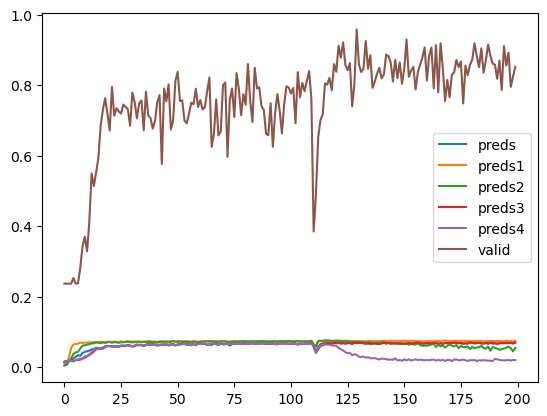

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)

  0%|          | 0/200 [00:00<?, ?it/s]

***训练集***

main branch： 0.2225

准确识别驾驶员： 0.05875

无法准确识别驾驶员： 0.055

准确识别行为： 0.20375

无法准确识别行为： 0.21

flag1 0.05875 flag2 0.20375


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  0%|          | 1/200 [00:06<19:58,  6.02s/it]

valid-f1: 0.03830093592512599

valid-precision: 0.023686553873552983

valid-recall: 0.1

process: 1  loss: 194.6520972251892  train_correct: 0.0 valid_loss 79.47066187858582  val_correct: 0.23686553873552982

The model has been saved!!

The best val_acc is  0.23686553873552982

***训练集***

main branch： 0.24625

准确识别驾驶员： 0.16875

无法准确识别驾驶员： 0.10125

准确识别行为： 0.23375

无法准确识别行为： 0.23375

flag1 0.16875 flag2 0.23375


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  1%|          | 2/200 [00:12<20:11,  6.12s/it]

valid-f1: 0.03830093592512599

valid-precision: 0.023686553873552983

valid-recall: 0.1

process: 2  loss: 187.1573085784912  train_correct: 0.0 valid_loss 79.18328261375427  val_correct: 0.23686553873552982

***训练集***

main branch： 0.2825

准确识别驾驶员： 0.50375

无法准确识别驾驶员： 0.235

准确识别行为： 0.2525

无法准确识别行为： 0.25375

flag1 0.50375 flag2 0.2525


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 3/200 [00:18<19:55,  6.07s/it]

valid-f1: 0.03830093592512599

valid-precision: 0.023686553873552983

valid-recall: 0.1

process: 3  loss: 163.9729471206665  train_correct: 0.0 valid_loss 78.88144278526306  val_correct: 0.23686553873552982

***训练集***

main branch： 0.285

准确识别驾驶员： 0.74625

无法准确识别驾驶员： 0.3575

准确识别行为： 0.2175

无法准确识别行为： 0.22

flag1 0.74625 flag2 0.2175


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 4/200 [00:24<19:43,  6.04s/it]

valid-f1: 0.03830093592512599

valid-precision: 0.023686553873552983

valid-recall: 0.1

process: 4  loss: 135.08921718597412  train_correct: 0.0 valid_loss 78.87611854076385  val_correct: 0.23686553873552982

***训练集***

main branch： 0.33125

准确识别驾驶员： 0.85125

无法准确识别驾驶员： 0.40625

准确识别行为： 0.205

无法准确识别行为： 0.2125

flag1 0.85125 flag2 0.205


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  2%|▎         | 5/200 [00:30<19:28,  5.99s/it]

valid-f1: 0.03830093592512599

valid-precision: 0.023686553873552983

valid-recall: 0.1

process: 5  loss: 120.40569162368774  train_correct: 0.0 valid_loss 78.51214873790741  val_correct: 0.23686553873552982

***训练集***

main branch： 0.4025

准确识别驾驶员： 0.895

无法准确识别驾驶员： 0.61375

准确识别行为： 0.25375

无法准确识别行为： 0.28625

flag1 0.895 flag2 0.25375


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  3%|▎         | 6/200 [00:36<19:24,  6.00s/it]

valid-f1: 0.05819405024703038

valid-precision: 0.07767002134797193

valid-recall: 0.11159420289855074

process: 6  loss: 112.0141441822052  train_correct: 0.0 valid_loss 77.71832025051117  val_correct: 0.25111308993766696

The model has been saved!!

The best val_acc is  0.25111308993766696

***训练集***

main branch： 0.46125

准确识别驾驶员： 0.8975

无法准确识别驾驶员： 0.635

准确识别行为： 0.2625

无法准确识别行为： 0.30875

flag1 0.8975 flag2 0.2625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  4%|▎         | 7/200 [00:42<19:29,  6.06s/it]

valid-f1: 0.03830093592512599

valid-precision: 0.023686553873552983

valid-recall: 0.1

process: 7  loss: 103.91000723838806  train_correct: 0.0 valid_loss 77.53623056411743  val_correct: 0.23686553873552982

***训练集***

main branch： 0.48375

准确识别驾驶员： 0.9025

无法准确识别驾驶员： 0.72875

准确识别行为： 0.26

无法准确识别行为： 0.2775

flag1 0.9025 flag2 0.26


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 8/200 [00:48<19:28,  6.09s/it]

valid-f1: 0.0895049189722691

valid-precision: 0.08122286408124217

valid-recall: 0.14237768333878173

process: 8  loss: 100.37580442428589  train_correct: 0.0 valid_loss 75.03817796707153  val_correct: 0.28851291184327693

The model has been saved!!

The best val_acc is  0.28851291184327693

***训练集***

main branch： 0.4925

准确识别驾驶员： 0.905

无法准确识别驾驶员： 0.8075

准确识别行为： 0.28375

无法准确识别行为： 0.31375

flag1 0.905 flag2 0.28375


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 9/200 [00:54<19:15,  6.05s/it]

valid-f1: 0.12158555358724099

valid-precision: 0.09322295259815154

valid-recall: 0.18735425520322546

process: 9  loss: 97.24491167068481  train_correct: 0.0 valid_loss 72.56292653083801  val_correct: 0.2831700801424755

***训练集***

main branch： 0.57875

准确识别驾驶员： 0.91375

无法准确识别驾驶员： 0.84125

准确识别行为： 0.33

无法准确识别行为： 0.3825

flag1 0.91375 flag2 0.33


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  5%|▌         | 10/200 [01:00<19:05,  6.03s/it]

valid-f1: 0.15838450424417555

valid-precision: 0.12355053064203499

valid-recall: 0.2401819766808325

process: 10  loss: 88.83030891418457  train_correct: 0.0 valid_loss 65.99603390693665  val_correct: 0.38023152270703475

The model has been saved!!

The best val_acc is  0.38023152270703475

***训练集***

main branch： 0.6175

准确识别驾驶员： 0.91625

无法准确识别驾驶员： 0.84

准确识别行为： 0.39

无法准确识别行为： 0.42125

flag1 0.91625 flag2 0.39


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  6%|▌         | 11/200 [01:06<18:55,  6.01s/it]

valid-f1: 0.1425853450272769

valid-precision: 0.16724740753449313

valid-recall: 0.20925683774654025

process: 11  loss: 82.57148337364197  train_correct: 0.0 valid_loss 62.57442486286163  val_correct: 0.3268032056990205

***训练集***

main branch： 0.6275

准确识别驾驶员： 0.945

无法准确识别驾驶员： 0.8775

准确识别行为： 0.455

无法准确识别行为： 0.485

flag1 0.945 flag2 0.455


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  6%|▌         | 12/200 [01:12<18:46,  5.99s/it]

valid-f1: 0.42453951134264345

valid-precision: 0.4953509152244987

valid-recall: 0.4558042669255483

process: 12  loss: 74.07812976837158  train_correct: 0.0 valid_loss 54.25058603286743  val_correct: 0.5191451469278717

The model has been saved!!

The best val_acc is  0.5191451469278717

***训练集***

main branch： 0.6875

准确识别驾驶员： 0.9375

无法准确识别驾驶员： 0.9075

准确识别行为： 0.54

无法准确识别行为： 0.6

flag1 0.9375 flag2 0.54


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  6%|▋         | 13/200 [01:18<19:06,  6.13s/it]

valid-f1: 0.44777893642517325

valid-precision: 0.5252402718590743

valid-recall: 0.4865769859431187

process: 13  loss: 66.8020601272583  train_correct: 0.0 valid_loss 49.1749792098999  val_correct: 0.5342831700801425

The model has been saved!!

The best val_acc is  0.5342831700801425

***训练集***

main branch： 0.69125

准确识别驾驶员： 0.9325

无法准确识别驾驶员： 0.9025

准确识别行为： 0.59625

无法准确识别行为： 0.6325

flag1 0.9325 flag2 0.59625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  7%|▋         | 14/200 [01:24<18:52,  6.09s/it]

valid-f1: 0.45182333452745393

valid-precision: 0.5190933748235247

valid-recall: 0.48284079764628957

process: 14  loss: 64.53698790073395  train_correct: 0.0 valid_loss 48.35378661751747  val_correct: 0.5235975066785397

***训练集***

main branch： 0.71

准确识别驾驶员： 0.945

无法准确识别驾驶员： 0.93375

准确识别行为： 0.62125

无法准确识别行为： 0.64375

flag1 0.945 flag2 0.62125


  8%|▊         | 15/200 [01:30<18:41,  6.06s/it]

valid-f1: 0.5098610084056274

valid-precision: 0.7259381734883728

valid-recall: 0.574156025769298

process: 15  loss: 58.2810355424881  train_correct: 0.0 valid_loss 41.04692907631397  val_correct: 0.5796972395369546

The model has been saved!!

The best val_acc is  0.5796972395369546

***训练集***

main branch： 0.69

准确识别驾驶员： 0.95625

无法准确识别驾驶员： 0.9275

准确识别行为： 0.6375

无法准确识别行为： 0.65

flag1 0.95625 flag2 0.6375


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  8%|▊         | 16/200 [01:36<18:34,  6.06s/it]

valid-f1: 0.6042920986746179

valid-precision: 0.6595559558429293

valid-recall: 0.6715064010487352

process: 16  loss: 56.35221707820892  train_correct: 0.0 valid_loss 41.85703948140144  val_correct: 0.653606411398041

The model has been saved!!

The best val_acc is  0.653606411398041

***训练集***

main branch： 0.7375

准确识别驾驶员： 0.9325

无法准确识别驾驶员： 0.92625

准确识别行为： 0.70375

无法准确识别行为： 0.71375

flag1 0.9325 flag2 0.70375


  8%|▊         | 17/200 [01:42<18:27,  6.05s/it]

valid-f1: 0.6846784679302286

valid-precision: 0.8033410512080822

valid-recall: 0.7126410558676004

process: 17  loss: 51.78315246105194  train_correct: 0.0 valid_loss 35.66114059090614  val_correct: 0.711487088156723

The model has been saved!!

The best val_acc is  0.711487088156723

***训练集***

main branch： 0.75875

准确识别驾驶员： 0.95875

无法准确识别驾驶员： 0.925

准确识别行为： 0.745

无法准确识别行为： 0.74125

flag1 0.95875 flag2 0.745


  9%|▉         | 18/200 [01:49<18:40,  6.15s/it]

valid-f1: 0.6234471246491323

valid-precision: 0.6918917117759276

valid-recall: 0.6196077446580879

process: 18  loss: 45.25116193294525  train_correct: 0.0 valid_loss 33.21620452404022  val_correct: 0.6322350845948352

***训练集***

main branch： 0.72875

准确识别驾驶员： 0.93125

无法准确识别驾驶员： 0.9125

准确识别行为： 0.7075

无法准确识别行为： 0.71125

flag1 0.93125 flag2 0.7075


 10%|▉         | 19/200 [01:55<18:29,  6.13s/it]

valid-f1: 0.6553262013785867

valid-precision: 0.7939422933702504

valid-recall: 0.6586892527762094

process: 19  loss: 52.349524974823  train_correct: 0.0 valid_loss 31.36734828352928  val_correct: 0.6856634016028496

***训练集***

main branch： 0.78125

准确识别驾驶员： 0.955

无法准确识别驾驶员： 0.92625

准确识别行为： 0.7525

无法准确识别行为： 0.76875

flag1 0.955 flag2 0.7525


 10%|█         | 20/200 [02:01<18:20,  6.11s/it]

valid-f1: 0.720506684572514

valid-precision: 0.823947481454413

valid-recall: 0.774579997424391

process: 20  loss: 42.328890919685364  train_correct: 0.0 valid_loss 30.59416601061821  val_correct: 0.7453250222617988

The model has been saved!!

The best val_acc is  0.7453250222617988

***训练集***

main branch： 0.725

准确识别驾驶员： 0.94

无法准确识别驾驶员： 0.91

准确识别行为： 0.73125

无法准确识别行为： 0.72875

flag1 0.94 flag2 0.73125


 10%|█         | 21/200 [02:07<18:09,  6.09s/it]

valid-f1: 0.7462824377995865

valid-precision: 0.7690466323942482

valid-recall: 0.7813080494384843

process: 21  loss: 48.23520529270172  train_correct: 0.0 valid_loss 28.906098403036594  val_correct: 0.7515583259127337

The model has been saved!!

The best val_acc is  0.7515583259127337

***训练集***

main branch： 0.785

准确识别驾驶员： 0.95

无法准确识别驾驶员： 0.93875

准确识别行为： 0.7725

无法准确识别行为： 0.77875

flag1 0.95 flag2 0.7725


 11%|█         | 22/200 [02:13<18:17,  6.17s/it]

valid-f1: 0.7782746470763993

valid-precision: 0.8072649042326059

valid-recall: 0.8245640451590109

process: 22  loss: 40.10282480716705  train_correct: 0.0 valid_loss 26.451154053211212  val_correct: 0.7809439002671416

The model has been saved!!

The best val_acc is  0.7809439002671416

***训练集***

main branch： 0.7825

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.9425

准确识别行为： 0.78125

无法准确识别行为： 0.7925

flag1 0.965 flag2 0.78125


 12%|█▏        | 23/200 [02:20<18:25,  6.25s/it]

valid-f1: 0.7035132217637826

valid-precision: 0.7710725082182309

valid-recall: 0.7452841028790684

process: 23  loss: 38.81532645225525  train_correct: 0.0 valid_loss 32.80964194238186  val_correct: 0.703472840605521

***训练集***

main branch： 0.78375

准确识别驾驶员： 0.95875

无法准确识别驾驶员： 0.9425

准确识别行为： 0.7775

无法准确识别行为： 0.78375

flag1 0.95875 flag2 0.7775


 12%|█▏        | 24/200 [02:26<18:17,  6.23s/it]

valid-f1: 0.7526643894401358

valid-precision: 0.7827777624574622

valid-recall: 0.769522046222275

process: 24  loss: 38.08700346946716  train_correct: 0.0 valid_loss 24.936021763831377  val_correct: 0.7453250222617988

***训练集***

main branch： 0.80375

准确识别驾驶员： 0.95125

无法准确识别驾驶员： 0.9375

准确识别行为： 0.80375

无法准确识别行为： 0.81625

flag1 0.95125 flag2 0.80375


 12%|█▎        | 25/200 [02:32<18:01,  6.18s/it]

valid-f1: 0.7515970025492973

valid-precision: 0.8497399192809529

valid-recall: 0.7333100868112311

process: 25  loss: 36.67105311155319  train_correct: 0.0 valid_loss 29.399675838649273  val_correct: 0.7542297417631345

***训练集***

main branch： 0.765

准确识别驾驶员： 0.9475

无法准确识别驾驶员： 0.92625

准确识别行为： 0.77375

无法准确识别行为： 0.7675

flag1 0.9475 flag2 0.77375


 13%|█▎        | 26/200 [02:38<17:51,  6.16s/it]

valid-f1: 0.7825114129472901

valid-precision: 0.806178066678612

valid-recall: 0.8061653838152696

process: 26  loss: 41.77608174085617  train_correct: 0.0 valid_loss 22.28329013288021  val_correct: 0.761353517364203

***训练集***

main branch： 0.7975

准确识别驾驶员： 0.9525

无法准确识别驾驶员： 0.9375

准确识别行为： 0.79875

无法准确识别行为： 0.80375

flag1 0.9525 flag2 0.79875


 14%|█▎        | 27/200 [02:44<17:54,  6.21s/it]

valid-f1: 0.7439844515055519

valid-precision: 0.7922707917202857

valid-recall: 0.7812307382421799

process: 27  loss: 36.826550245285034  train_correct: 0.0 valid_loss 29.136209294199944  val_correct: 0.7275155832591274

***训练集***

main branch： 0.81375

准确识别驾驶员： 0.94625

无法准确识别驾驶员： 0.9325

准确识别行为： 0.80375

无法准确识别行为： 0.795

flag1 0.94625 flag2 0.80375


 14%|█▍        | 28/200 [02:51<17:56,  6.26s/it]

valid-f1: 0.8265983203018511

valid-precision: 0.829093815060736

valid-recall: 0.8405916768205097

process: 28  loss: 34.98695623874664  train_correct: 0.0 valid_loss 19.165242914110422  val_correct: 0.8103294746215495

The model has been saved!!

The best val_acc is  0.8103294746215495

***训练集***

main branch： 0.795

准确识别驾驶员： 0.945

无法准确识别驾驶员： 0.9375

准确识别行为： 0.8

无法准确识别行为： 0.78375

flag1 0.945 flag2 0.8


 14%|█▍        | 29/200 [02:57<17:51,  6.27s/it]

valid-f1: 0.7832897012560791

valid-precision: 0.8125774655434362

valid-recall: 0.8145737763380785

process: 29  loss: 38.265371799468994  train_correct: 0.0 valid_loss 22.15962217748165  val_correct: 0.7711487088156723

***训练集***

main branch： 0.8

准确识别驾驶员： 0.95

无法准确识别驾驶员： 0.9325

准确识别行为： 0.79125

无法准确识别行为： 0.80125

flag1 0.95 flag2 0.79125


 15%|█▌        | 30/200 [03:03<17:46,  6.28s/it]

valid-f1: 0.8268863584845629

valid-precision: 0.8348774653921849

valid-recall: 0.8556777318791049

process: 30  loss: 34.75170361995697  train_correct: 0.0 valid_loss 17.391947969794273  val_correct: 0.8183437221727515

The model has been saved!!

The best val_acc is  0.8183437221727515

***训练集***

main branch： 0.7975

准确识别驾驶员： 0.95125

无法准确识别驾驶员： 0.9225

准确识别行为： 0.81875

无法准确识别行为： 0.815

flag1 0.95125 flag2 0.81875


 16%|█▌        | 31/200 [03:09<17:32,  6.23s/it]

valid-f1: 0.8003993971112932

valid-precision: 0.8149922167314123

valid-recall: 0.825586865715012

process: 31  loss: 35.11581325531006  train_correct: 0.0 valid_loss 23.145727694034576  val_correct: 0.8032056990204809

***训练集***

main branch： 0.80875

准确识别驾驶员： 0.95625

无法准确识别驾驶员： 0.93625

准确识别行为： 0.8125

无法准确识别行为： 0.80375

flag1 0.95625 flag2 0.8125


 16%|█▌        | 32/200 [03:16<17:26,  6.23s/it]

valid-f1: 0.8141714802382444

valid-precision: 0.8139967056648956

valid-recall: 0.8424335971681509

process: 32  loss: 34.97185659408569  train_correct: 0.0 valid_loss 18.260384127497673  val_correct: 0.8236865538735529

The model has been saved!!

The best val_acc is  0.8236865538735529

***训练集***

main branch： 0.7975

准确识别驾驶员： 0.955

无法准确识别驾驶员： 0.92625

准确识别行为： 0.79125

无法准确识别行为： 0.7875

flag1 0.955 flag2 0.79125


 16%|█▋        | 33/200 [03:22<17:33,  6.31s/it]

valid-f1: 0.7492092422116264

valid-precision: 0.7727739440745005

valid-recall: 0.7936962366390283

process: 33  loss: 36.47160243988037  train_correct: 0.0 valid_loss 27.64250771701336  val_correct: 0.7444345503116652

***训练集***

main branch： 0.82

准确识别驾驶员： 0.9625

无法准确识别驾驶员： 0.9475

准确识别行为： 0.83

无法准确识别行为： 0.825

flag1 0.9625 flag2 0.83


 17%|█▋        | 34/200 [03:28<17:17,  6.25s/it]

valid-f1: 0.8279377439463695

valid-precision: 0.8310372789045942

valid-recall: 0.8666013881872004

process: 34  loss: 31.065440356731415  train_correct: 0.0 valid_loss 17.909902200102806  val_correct: 0.8147818343722173

***训练集***

main branch： 0.82375

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.94625

准确识别行为： 0.82875

无法准确识别行为： 0.8225

flag1 0.9725 flag2 0.82875


 18%|█▊        | 35/200 [03:34<17:04,  6.21s/it]

valid-f1: 0.853510017005154

valid-precision: 0.8683542133542135

valid-recall: 0.87598388263148

process: 35  loss: 31.473114252090454  train_correct: 0.0 valid_loss 17.97704254463315  val_correct: 0.8299198575244879

The model has been saved!!

The best val_acc is  0.8299198575244879

***训练集***

main branch： 0.8125

准确识别驾驶员： 0.93625

无法准确识别驾驶员： 0.9175

准确识别行为： 0.81

无法准确识别行为： 0.815

flag1 0.93625 flag2 0.81


 18%|█▊        | 36/200 [03:41<16:52,  6.17s/it]

valid-f1: 0.7866388243994523

valid-precision: 0.8044415521564512

valid-recall: 0.814135836957347

process: 36  loss: 34.924154460430145  train_correct: 0.0 valid_loss 19.84931429848075  val_correct: 0.780053428317008

***训练集***

main branch： 0.83

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.94375

准确识别行为： 0.825

无法准确识别行为： 0.8275

flag1 0.96625 flag2 0.825


 18%|█▊        | 37/200 [03:47<16:46,  6.18s/it]

valid-f1: 0.7294027018038125

valid-precision: 0.7602239925024771

valid-recall: 0.768644833427442

process: 37  loss: 31.410094439983368  train_correct: 0.0 valid_loss 28.368165116757154  val_correct: 0.730186999109528

***训练集***

main branch： 0.83125

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.955

准确识别行为： 0.84125

无法准确识别行为： 0.82375

flag1 0.97 flag2 0.84125


 19%|█▉        | 38/200 [03:53<16:58,  6.29s/it]

valid-f1: 0.7531550685246031

valid-precision: 0.7818764034825237

valid-recall: 0.7990281765018608

process: 38  loss: 27.981917291879654  train_correct: 0.0 valid_loss 27.21576152741909  val_correct: 0.742653606411398

***训练集***

main branch： 0.82125

准确识别驾驶员： 0.96125

无法准确识别驾驶员： 0.945

准确识别行为： 0.8125

无法准确识别行为： 0.81625

flag1 0.96125 flag2 0.8125


 20%|█▉        | 39/200 [03:59<16:38,  6.20s/it]

valid-f1: 0.7374524232188022

valid-precision: 0.7475916891320356

valid-recall: 0.7829323704518212

process: 39  loss: 29.98769301176071  train_correct: 0.0 valid_loss 26.410507652908564  val_correct: 0.7105966162065895

***训练集***

main branch： 0.82875

准确识别驾驶员： 0.96375

无法准确识别驾驶员： 0.92375

准确识别行为： 0.825

无法准确识别行为： 0.82375

flag1 0.96375 flag2 0.825


 20%|██        | 40/200 [04:05<16:24,  6.15s/it]

valid-f1: 0.7983215679065505

valid-precision: 0.8061135761508602

valid-recall: 0.8403358098804323

process: 40  loss: 30.266790568828583  train_correct: 0.0 valid_loss 25.31600195914507  val_correct: 0.7818343722172751

***训练集***

main branch： 0.8275

准确识别驾驶员： 0.955

无法准确识别驾驶员： 0.93

准确识别行为： 0.84125

无法准确识别行为： 0.82875

flag1 0.955 flag2 0.84125


 20%|██        | 41/200 [04:11<16:11,  6.11s/it]

valid-f1: 0.8192973730286868

valid-precision: 0.8423556734664249

valid-recall: 0.8333807509551215

process: 41  loss: 30.484441339969635  train_correct: 0.0 valid_loss 21.44777803681791  val_correct: 0.8174532502226179

***训练集***

main branch： 0.83875

准确识别驾驶员： 0.95875

无法准确识别驾驶员： 0.93625

准确识别行为： 0.8375

无法准确识别行为： 0.83625

flag1 0.95875 flag2 0.8375


 21%|██        | 42/200 [04:17<15:59,  6.07s/it]

valid-f1: 0.7604029353348821

valid-precision: 0.8073260178225571

valid-recall: 0.7917864886194406

process: 42  loss: 28.536290645599365  train_correct: 0.0 valid_loss 27.885399697348475  val_correct: 0.7462154942119323

***训练集***

main branch： 0.8175

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.9425

准确识别行为： 0.8375

无法准确识别行为： 0.82125

flag1 0.965 flag2 0.8375


 22%|██▏       | 43/200 [04:24<16:01,  6.13s/it]

valid-f1: 0.7643653563214198

valid-precision: 0.7850914488591417

valid-recall: 0.7915109578953972

process: 43  loss: 31.170476615428925  train_correct: 0.0 valid_loss 28.990535393357277  val_correct: 0.7310774710596616

***训练集***

main branch： 0.815

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.955

准确识别行为： 0.81375

无法准确识别行为： 0.80875

flag1 0.96625 flag2 0.81375


 22%|██▏       | 44/200 [04:30<15:51,  6.10s/it]

valid-f1: 0.85153595995557

valid-precision: 0.8408610830542587

valid-recall: 0.8962101465785677

process: 44  loss: 31.35217034816742  train_correct: 0.0 valid_loss 18.158882182091475  val_correct: 0.8441674087266251

The model has been saved!!

The best val_acc is  0.8441674087266251

***训练集***

main branch： 0.83625

准确识别驾驶员： 0.9625

无法准确识别驾驶员： 0.955

准确识别行为： 0.8375

无法准确识别行为： 0.83

flag1 0.9625 flag2 0.8375


 22%|██▎       | 45/200 [04:36<15:43,  6.09s/it]

valid-f1: 0.7550769422775021

valid-precision: 0.7957986250804228

valid-recall: 0.7852556225874303

process: 45  loss: 28.768466591835022  train_correct: 0.0 valid_loss 21.054659966379404  val_correct: 0.7462154942119323

***训练集***

main branch： 0.865

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.9575

准确识别行为： 0.86875

无法准确识别行为： 0.85625

flag1 0.97625 flag2 0.86875


 23%|██▎       | 46/200 [04:42<15:30,  6.05s/it]

valid-f1: 0.7642812359211887

valid-precision: 0.7857254863257049

valid-recall: 0.7913470864248897

process: 46  loss: 23.66626799106598  train_correct: 0.0 valid_loss 22.09178590029478  val_correct: 0.7444345503116652

***训练集***

main branch： 0.84375

准确识别驾驶员： 0.9475

无法准确识别驾驶员： 0.9325

准确识别行为： 0.86

无法准确识别行为： 0.85375

flag1 0.9475 flag2 0.86


 24%|██▎       | 47/200 [04:48<15:20,  6.02s/it]

valid-f1: 0.8245181216423558

valid-precision: 0.8371223035863752

valid-recall: 0.850006363075013

process: 47  loss: 28.089854180812836  train_correct: 0.0 valid_loss 17.350356934592128  val_correct: 0.8183437221727515

***训练集***

main branch： 0.855

准确识别驾驶员： 0.96125

无法准确识别驾驶员： 0.93875

准确识别行为： 0.8625

无法准确识别行为： 0.8525

flag1 0.96125 flag2 0.8625


 24%|██▍       | 48/200 [04:54<15:20,  6.05s/it]

valid-f1: 0.8486222144230233

valid-precision: 0.8474265836821084

valid-recall: 0.8856492647957179

process: 48  loss: 25.937004059553146  train_correct: 0.0 valid_loss 18.494761349633336  val_correct: 0.8450578806767587

The model has been saved!!

The best val_acc is  0.8450578806767587

***训练集***

main branch： 0.855

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.96625

准确识别行为： 0.85625

无法准确识别行为： 0.85375

flag1 0.9775 flag2 0.85625


 24%|██▍       | 49/200 [05:00<15:22,  6.11s/it]

valid-f1: 0.7903177988262844

valid-precision: 0.8159879620199577

valid-recall: 0.8161437222833104

process: 49  loss: 24.148149132728577  train_correct: 0.0 valid_loss 23.303572185337543  val_correct: 0.773820124666073

***训练集***

main branch： 0.85125

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.96

准确识别行为： 0.86

无法准确识别行为： 0.87375

flag1 0.97375 flag2 0.86


 25%|██▌       | 50/200 [05:06<15:14,  6.10s/it]

valid-f1: 0.8171368846719389

valid-precision: 0.8351887478299304

valid-recall: 0.8288349364848221

process: 50  loss: 24.755398988723755  train_correct: 0.0 valid_loss 18.508707178756595  val_correct: 0.7773820124666073

***训练集***

main branch： 0.8375

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.95375

准确识别行为： 0.85875

无法准确识别行为： 0.8575

flag1 0.9675 flag2 0.85875


 26%|██▌       | 51/200 [05:12<15:05,  6.08s/it]

valid-f1: 0.819313495868075

valid-precision: 0.8349560099289327

valid-recall: 0.8499028335000874

process: 51  loss: 26.74021887779236  train_correct: 0.0 valid_loss 20.39431358128786  val_correct: 0.7978628673196795

***训练集***

main branch： 0.87375

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.95375

准确识别行为： 0.875

无法准确识别行为： 0.8725

flag1 0.97 flag2 0.875


 26%|██▌       | 52/200 [05:18<14:56,  6.06s/it]

valid-f1: 0.7695127832044422

valid-precision: 0.8315888649188434

valid-recall: 0.7821072840203274

process: 52  loss: 24.030010163784027  train_correct: 0.0 valid_loss 23.969562850892544  val_correct: 0.7649154051647373

***训练集***

main branch： 0.86625

准确识别驾驶员： 0.9625

无法准确识别驾驶员： 0.95

准确识别行为： 0.8675

无法准确识别行为： 0.86125

flag1 0.9625 flag2 0.8675


 26%|██▋       | 53/200 [05:24<14:48,  6.04s/it]

valid-f1: 0.8034002628788987

valid-precision: 0.8341741903083367

valid-recall: 0.8265348912465618

process: 53  loss: 25.554543405771255  train_correct: 0.0 valid_loss 18.7684966288507  val_correct: 0.7720391807658059

***训练集***

main branch： 0.86875

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.96375

准确识别行为： 0.87375

无法准确识别行为： 0.87

flag1 0.97375 flag2 0.87375


 27%|██▋       | 54/200 [05:30<14:56,  6.14s/it]

valid-f1: 0.7606345733693544

valid-precision: 0.7656063227697358

valid-recall: 0.7993101297380474

process: 54  loss: 24.51545810699463  train_correct: 0.0 valid_loss 26.634016375988722  val_correct: 0.7266251113089938

***训练集***

main branch： 0.84875

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.96375

准确识别行为： 0.8575

无法准确识别行为： 0.85375

flag1 0.9775 flag2 0.8575


 28%|██▊       | 55/200 [05:36<14:41,  6.08s/it]

valid-f1: 0.803027884595713

valid-precision: 0.8280295960264032

valid-recall: 0.823976730363458

process: 55  loss: 24.88323324918747  train_correct: 0.0 valid_loss 19.328573539853096  val_correct: 0.7818343722172751

***训练集***

main branch： 0.865

准确识别驾驶员： 0.96

无法准确识别驾驶员： 0.93875

准确识别行为： 0.86625

无法准确识别行为： 0.86875

flag1 0.96 flag2 0.86625


 28%|██▊       | 56/200 [05:42<14:30,  6.05s/it]

valid-f1: 0.8297672544301316

valid-precision: 0.8328943696634372

valid-recall: 0.8604756423337658

process: 56  loss: 25.15061131119728  train_correct: 0.0 valid_loss 19.323630112223327  val_correct: 0.8165627782724845

***训练集***

main branch： 0.86125

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.955

准确识别行为： 0.8625

无法准确识别行为： 0.8525

flag1 0.96875 flag2 0.8625


 28%|██▊       | 57/200 [05:48<14:19,  6.01s/it]

valid-f1: 0.8315950225962159

valid-precision: 0.826293419771418

valid-recall: 0.8520229823570784

process: 57  loss: 24.91888591647148  train_correct: 0.0 valid_loss 22.573005167767406  val_correct: 0.8032056990204809

***训练集***

main branch： 0.835

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.9725

准确识别行为： 0.8475

无法准确识别行为： 0.84375

flag1 0.975 flag2 0.8475


 29%|██▉       | 58/200 [05:54<14:14,  6.02s/it]

valid-f1: 0.809416977116539

valid-precision: 0.8347230914649486

valid-recall: 0.829148566409436

process: 58  loss: 24.952668964862823  train_correct: 0.0 valid_loss 19.463689064607024  val_correct: 0.7889581478183437

***训练集***

main branch： 0.85875

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.95

准确识别行为： 0.875

无法准确识别行为： 0.86

flag1 0.96875 flag2 0.875


 30%|██▉       | 59/200 [06:01<14:22,  6.12s/it]

valid-f1: 0.8758382696868168

valid-precision: 0.8889500618189657

valid-recall: 0.8801528524869486

process: 59  loss: 23.93246152997017  train_correct: 0.0 valid_loss 15.460024759173393  val_correct: 0.8610863757791629

The model has been saved!!

The best val_acc is  0.8610863757791629

***训练集***

main branch： 0.86125

准确识别驾驶员： 0.96375

无法准确识别驾驶员： 0.94625

准确识别行为： 0.86625

无法准确识别行为： 0.8625

flag1 0.96375 flag2 0.86625


 30%|███       | 60/200 [06:07<14:15,  6.11s/it]

valid-f1: 0.7436623513179097

valid-precision: 0.7752730948672724

valid-recall: 0.7751249797748653

process: 60  loss: 26.46428346633911  train_correct: 0.0 valid_loss 25.679554084315896  val_correct: 0.7275155832591274

***训练集***

main branch： 0.86125

准确识别驾驶员： 0.95875

无法准确识别驾驶员： 0.94375

准确识别行为： 0.86625

无法准确识别行为： 0.85375

flag1 0.95875 flag2 0.86625


 30%|███       | 61/200 [06:13<14:05,  6.08s/it]

valid-f1: 0.7799721254107048

valid-precision: 0.7767041434539875

valid-recall: 0.8219132382999661

process: 61  loss: 25.339211732149124  train_correct: 0.0 valid_loss 20.35616674274206  val_correct: 0.7791629563668745

***训练集***

main branch： 0.88375

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.9475

准确识别行为： 0.89125

无法准确识别行为： 0.8875

flag1 0.96625 flag2 0.89125


 31%|███       | 62/200 [06:19<13:57,  6.07s/it]

valid-f1: 0.8052988053365852

valid-precision: 0.8311420814957113

valid-recall: 0.8510757361123495

process: 62  loss: 21.530421435832977  train_correct: 0.0 valid_loss 22.295643039047718  val_correct: 0.7907390917186109

***训练集***

main branch： 0.86625

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.9725

准确识别行为： 0.8775

无法准确识别行为： 0.875

flag1 0.9825 flag2 0.8775


 32%|███▏      | 63/200 [06:25<13:50,  6.06s/it]

valid-f1: 0.7332447814848513

valid-precision: 0.7505203699887242

valid-recall: 0.7867049474806912

process: 63  loss: 21.479632675647736  train_correct: 0.0 valid_loss 28.41718778386712  val_correct: 0.711487088156723

***训练集***

main branch： 0.875

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.96375

准确识别行为： 0.885

无法准确识别行为： 0.87625

flag1 0.98 flag2 0.885


 32%|███▏      | 64/200 [06:31<13:54,  6.14s/it]

valid-f1: 0.8475152076817214

valid-precision: 0.8563525503487034

valid-recall: 0.8702563820618741

process: 64  loss: 21.870753675699234  train_correct: 0.0 valid_loss 18.913021566346288  val_correct: 0.804986642920748

***训练集***

main branch： 0.875

准确识别驾驶员： 0.9575

无法准确识别驾驶员： 0.94375

准确识别行为： 0.88625

无法准确识别行为： 0.875

flag1 0.9575 flag2 0.88625


 32%|███▎      | 65/200 [06:37<13:39,  6.07s/it]

valid-f1: 0.8165876736412272

valid-precision: 0.831886871123438

valid-recall: 0.8553877942550712

process: 65  loss: 22.528826981782913  train_correct: 0.0 valid_loss 18.33081493154168  val_correct: 0.8032056990204809

***训练集***

main branch： 0.8875

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.96375

准确识别行为： 0.88875

无法准确识别行为： 0.89375

flag1 0.97625 flag2 0.88875


 33%|███▎      | 66/200 [06:43<13:30,  6.05s/it]

valid-f1: 0.8045801090014187

valid-precision: 0.8076789596883971

valid-recall: 0.8291943561142645

process: 66  loss: 20.323342114686966  train_correct: 0.0 valid_loss 18.092748509719968  val_correct: 0.7898486197684773

***训练集***

main branch： 0.88

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.94875

准确识别行为： 0.88125

无法准确识别行为： 0.8875

flag1 0.96875 flag2 0.88125


 34%|███▎      | 67/200 [06:49<13:20,  6.02s/it]

valid-f1: 0.8289841670309152

valid-precision: 0.8341202424785165

valid-recall: 0.8447528174850829

process: 67  loss: 20.994489282369614  train_correct: 0.0 valid_loss 16.188704014290124  val_correct: 0.8165627782724845

***训练集***

main branch： 0.86625

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.96375

准确识别行为： 0.875

无法准确识别行为： 0.85875

flag1 0.96625 flag2 0.875


 34%|███▍      | 68/200 [06:55<13:14,  6.02s/it]

valid-f1: 0.8019941976112286

valid-precision: 0.8029907540311771

valid-recall: 0.8269844737007208

process: 68  loss: 24.880344301462173  train_correct: 0.0 valid_loss 19.19606928806752  val_correct: 0.7907390917186109

***训练集***

main branch： 0.84375

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.96125

准确识别行为： 0.86375

无法准确识别行为： 0.84375

flag1 0.97875 flag2 0.86375


 34%|███▍      | 69/200 [07:01<13:16,  6.08s/it]

valid-f1: 0.8452182310919509

valid-precision: 0.8429970122420342

valid-recall: 0.8767152003856807

process: 69  loss: 25.73727971315384  train_correct: 0.0 valid_loss 16.295886343345046  val_correct: 0.8406055209260909

***训练集***

main branch： 0.87625

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.95875

准确识别行为： 0.86875

无法准确识别行为： 0.87875

flag1 0.97625 flag2 0.86875


 35%|███▌      | 70/200 [07:07<13:08,  6.07s/it]

valid-f1: 0.8082219616885007

valid-precision: 0.8280968158391374

valid-recall: 0.8461150306596531

process: 70  loss: 22.905072957277298  train_correct: 0.0 valid_loss 26.13935407437384  val_correct: 0.7845057880676759

***训练集***

main branch： 0.83375

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.95

准确识别行为： 0.84375

无法准确识别行为： 0.84625

flag1 0.9675 flag2 0.84375


 36%|███▌      | 71/200 [07:13<13:00,  6.05s/it]

valid-f1: 0.8163463196668875

valid-precision: 0.8441850759042764

valid-recall: 0.8510656086857459

process: 71  loss: 26.166495084762573  train_correct: 0.0 valid_loss 20.003397374413908  val_correct: 0.7951914514692787

***训练集***

main branch： 0.8575

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.9525

准确识别行为： 0.86875

无法准确识别行为： 0.865

flag1 0.96875 flag2 0.86875


 36%|███▌      | 72/200 [07:19<12:53,  6.05s/it]

valid-f1: 0.8028821046035359

valid-precision: 0.8106114536391275

valid-recall: 0.8356132161761453

process: 72  loss: 23.50646260380745  train_correct: 0.0 valid_loss 20.537900009192526  val_correct: 0.780053428317008

***训练集***

main branch： 0.86875

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.95

准确识别行为： 0.87625

无法准确识别行为： 0.88125

flag1 0.98 flag2 0.87625


 36%|███▋      | 73/200 [07:25<12:47,  6.04s/it]

valid-f1: 0.8535815076801914

valid-precision: 0.8712236427218697

valid-recall: 0.8658582754646827

process: 73  loss: 21.123040288686752  train_correct: 0.0 valid_loss 16.37111806869507  val_correct: 0.8227960819234195

***训练集***

main branch： 0.87875

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.94

准确识别行为： 0.8875

无法准确识别行为： 0.87625

flag1 0.97 flag2 0.8875


 37%|███▋      | 74/200 [07:31<12:39,  6.03s/it]

valid-f1: 0.8128091999837981

valid-precision: 0.8334760391569119

valid-recall: 0.824497350094604

process: 74  loss: 21.335542112588882  train_correct: 0.0 valid_loss 18.25248872395605  val_correct: 0.7943009795191451

***训练集***

main branch： 0.8425

准确识别驾驶员： 0.94875

无法准确识别驾驶员： 0.94625

准确识别行为： 0.85875

无法准确识别行为： 0.8575

flag1 0.94875 flag2 0.85875


 38%|███▊      | 75/200 [07:38<12:45,  6.12s/it]

valid-f1: 0.8081593310504834

valid-precision: 0.8482547703979761

valid-recall: 0.8082627319286357

process: 75  loss: 25.661906868219376  train_correct: 0.0 valid_loss 18.537251303438097  val_correct: 0.7853962600178095

***训练集***

main branch： 0.84875

准确识别驾驶员： 0.96

无法准确识别驾驶员： 0.95

准确识别行为： 0.8525

无法准确识别行为： 0.84625

flag1 0.96 flag2 0.8525


 38%|███▊      | 76/200 [07:44<12:35,  6.09s/it]

valid-f1: 0.8742153144820536

valid-precision: 0.8704860675508546

valid-recall: 0.8964113016401345

process: 76  loss: 26.54430714249611  train_correct: 0.0 valid_loss 18.268761835992336  val_correct: 0.8575244879786287

***训练集***

main branch： 0.86625

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.95375

准确识别行为： 0.8675

无法准确识别行为： 0.86625

flag1 0.96625 flag2 0.8675


 38%|███▊      | 77/200 [07:50<12:25,  6.06s/it]

valid-f1: 0.793152437459476

valid-precision: 0.8132888655553122

valid-recall: 0.8144931960996035

process: 77  loss: 22.980619430541992  train_correct: 0.0 valid_loss 20.325081082992256  val_correct: 0.773820124666073

***训练集***

main branch： 0.86375

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.9625

准确识别行为： 0.8675

无法准确识别行为： 0.87125

flag1 0.96875 flag2 0.8675


 39%|███▉      | 78/200 [07:56<12:17,  6.05s/it]

valid-f1: 0.8447893400029937

valid-precision: 0.854978939668546

valid-recall: 0.8618067434726473

process: 78  loss: 22.3862242102623  train_correct: 0.0 valid_loss 19.51881332602352  val_correct: 0.8263579697239537

***训练集***

main branch： 0.8775

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.96875

准确识别行为： 0.8775

无法准确识别行为： 0.87125

flag1 0.9825 flag2 0.8775


 40%|███▉      | 79/200 [08:02<12:10,  6.04s/it]

valid-f1: 0.8428421562189176

valid-precision: 0.8576735029676206

valid-recall: 0.8713500087504664

process: 79  loss: 23.125624001026154  train_correct: 0.0 valid_loss 16.500823007314466  val_correct: 0.8379341050756901

***训练集***

main branch： 0.88125

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.97

准确识别行为： 0.88875

无法准确识别行为： 0.8775

flag1 0.975 flag2 0.88875


 40%|████      | 80/200 [08:08<12:17,  6.14s/it]

valid-f1: 0.810418845026663

valid-precision: 0.8155030036769227

valid-recall: 0.8497095142335416

process: 80  loss: 20.962705463171005  train_correct: 0.0 valid_loss 19.92464290931821  val_correct: 0.8067675868210151

***训练集***

main branch： 0.88625

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.9675

准确识别行为： 0.8875

无法准确识别行为： 0.87

flag1 0.97875 flag2 0.8875


 40%|████      | 81/200 [08:14<12:05,  6.10s/it]

valid-f1: 0.8148562109355548

valid-precision: 0.8283731550395654

valid-recall: 0.8468039565316452

process: 81  loss: 21.22383353114128  train_correct: 0.0 valid_loss 23.913009035866708  val_correct: 0.7934105075690115

***训练集***

main branch： 0.8675

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.96625

准确识别行为： 0.88

无法准确识别行为： 0.8775

flag1 0.98125 flag2 0.88


 41%|████      | 82/200 [08:20<11:55,  6.06s/it]

valid-f1: 0.8282411576857379

valid-precision: 0.8306601460543728

valid-recall: 0.8485053608989535

process: 82  loss: 21.818454191088676  train_correct: 0.0 valid_loss 19.68933243304491  val_correct: 0.8130008904719501

***训练集***

main branch： 0.885

准确识别驾驶员： 0.96125

无法准确识别驾驶员： 0.96

准确识别行为： 0.88125

无法准确识别行为： 0.88125

flag1 0.96125 flag2 0.88125


 42%|████▏     | 83/200 [08:26<11:48,  6.05s/it]

valid-f1: 0.8250972480438087

valid-precision: 0.826643177679545

valid-recall: 0.8502693393562959

process: 83  loss: 21.05120551586151  train_correct: 0.0 valid_loss 24.071249773725867  val_correct: 0.7871772039180766

***训练集***

main branch： 0.86625

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.94375

准确识别行为： 0.86625

无法准确识别行为： 0.875

flag1 0.965 flag2 0.86625


 42%|████▏     | 84/200 [08:32<11:40,  6.04s/it]

valid-f1: 0.6984892628036173

valid-precision: 0.7791501057664296

valid-recall: 0.7510211926390415

process: 84  loss: 22.587032973766327  train_correct: 0.0 valid_loss 34.4168057423085  val_correct: 0.667853962600178

***训练集***

main branch： 0.865

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.96375

准确识别行为： 0.8725

无法准确识别行为： 0.8675

flag1 0.9775 flag2 0.8725


 42%|████▎     | 85/200 [08:39<11:49,  6.17s/it]

valid-f1: 0.8015820474927974

valid-precision: 0.8237692592432238

valid-recall: 0.8367578762452904

process: 85  loss: 22.340927720069885  train_correct: 0.0 valid_loss 21.81806576717645  val_correct: 0.7782724844167409

***训练集***

main branch： 0.9025

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.94875

准确识别行为： 0.90125

无法准确识别行为： 0.9

flag1 0.97875 flag2 0.90125

预热结束


 43%|████▎     | 86/200 [08:45<11:38,  6.13s/it]

valid-f1: 0.8590370000138472

valid-precision: 0.875083857891185

valid-recall: 0.8631867613698276

process: 86  loss: 17.345875844359398  train_correct: 0.0 valid_loss 14.52094617113471  val_correct: 0.8512911843276937

***训练集***

main branch： 0.74625

准确识别驾驶员： 0.76875

无法准确识别驾驶员： 0.75

准确识别行为： 0.75125

无法准确识别行为： 0.7375

flag1 0.76875 flag2 0.75125


 44%|████▎     | 87/200 [08:51<11:29,  6.10s/it]

valid-f1: 0.3572534702865389

valid-precision: 0.7379230721803508

valid-recall: 0.3650353915090757

process: 87  loss: 322.5266418457031  train_correct: 0.0 valid_loss 69.41560208797455  val_correct: 0.38023152270703475

***训练集***

main branch： 0.59125

准确识别驾驶员： 0.7625

无法准确识别驾驶员： 0.78

准确识别行为： 0.615

无法准确识别行为： 0.57

flag1 0.7625 flag2 0.615


 44%|████▍     | 88/200 [08:57<11:21,  6.09s/it]

valid-f1: 0.7311959912836802

valid-precision: 0.7346408333639887

valid-recall: 0.7657451335849504

process: 88  loss: 137.42624855041504  train_correct: 0.0 valid_loss 41.24331471323967  val_correct: 0.7079252003561888

***训练集***

main branch： 0.71125

准确识别驾驶员： 0.9575

无法准确识别驾驶员： 0.96

准确识别行为： 0.805

无法准确识别行为： 0.76625

flag1 0.9575 flag2 0.805


 44%|████▍     | 89/200 [09:03<11:11,  6.05s/it]

valid-f1: 0.7690722974837089

valid-precision: 0.7885211554091438

valid-recall: 0.80785326953748

process: 89  loss: 106.29806351661682  train_correct: 0.0 valid_loss 42.363785326480865  val_correct: 0.7542297417631345

***训练集***

main branch： 0.79625

准确识别驾驶员： 0.985

无法准确识别驾驶员： 0.98625

准确识别行为： 0.85875

无法准确识别行为： 0.84375

flag1 0.985 flag2 0.85875


 45%|████▌     | 90/200 [09:09<11:18,  6.17s/it]

valid-f1: 0.7771408870743858

valid-precision: 0.8009848687274864

valid-recall: 0.8112999626866904

process: 90  loss: 92.31849789619446  train_correct: 0.0 valid_loss 43.78740328550339  val_correct: 0.748886910062333

***训练集***

main branch： 0.82875

准确识别驾驶员： 0.9875

无法准确识别驾驶员： 0.9875

准确识别行为： 0.8775

无法准确识别行为： 0.8375

flag1 0.9875 flag2 0.8775


 46%|████▌     | 91/200 [09:15<11:07,  6.12s/it]

valid-f1: 0.8143584341203768

valid-precision: 0.8176575150990999

valid-recall: 0.846679419233195

process: 91  loss: 83.26817846298218  train_correct: 0.0 valid_loss 41.78434735536575  val_correct: 0.7916295636687445

***训练集***

main branch： 0.865

准确识别驾驶员： 0.98625

无法准确识别驾驶员： 0.985

准确识别行为： 0.89

无法准确识别行为： 0.85375

flag1 0.98625 flag2 0.89


 46%|████▌     | 92/200 [09:21<10:55,  6.07s/it]

valid-f1: 0.8138846743221707

valid-precision: 0.8435097291231738

valid-recall: 0.8348740494186719

process: 92  loss: 74.85407090187073  train_correct: 0.0 valid_loss 40.7268905043602  val_correct: 0.8014247551202137

***训练集***

main branch： 0.87625

准确识别驾驶员： 0.98625

无法准确识别驾驶员： 0.98625

准确识别行为： 0.89625

无法准确识别行为： 0.85125

flag1 0.98625 flag2 0.89625


 46%|████▋     | 93/200 [09:27<10:49,  6.07s/it]

valid-f1: 0.8254753732232594

valid-precision: 0.8364599667934067

valid-recall: 0.8524237339065713

process: 93  loss: 67.11420178413391  train_correct: 0.0 valid_loss 37.32915818691254  val_correct: 0.8121104185218165

***训练集***

main branch： 0.91125

准确识别驾驶员： 0.99

无法准确识别驾驶员： 0.98625

准确识别行为： 0.91875

无法准确识别行为： 0.85875

flag1 0.99 flag2 0.91875


 47%|████▋     | 94/200 [09:33<10:44,  6.08s/it]

valid-f1: 0.8214073545510334

valid-precision: 0.8223043069106728

valid-recall: 0.851387681984936

process: 94  loss: 59.68120837211609  train_correct: 0.0 valid_loss 35.93762511014938  val_correct: 0.8121104185218165

***训练集***

main branch： 0.90375

准确识别驾驶员： 0.98875

无法准确识别驾驶员： 0.9825

准确识别行为： 0.9

无法准确识别行为： 0.83625

flag1 0.98875 flag2 0.9


 48%|████▊     | 95/200 [09:40<10:45,  6.15s/it]

valid-f1: 0.8416489907195173

valid-precision: 0.8480380655875562

valid-recall: 0.8593931270864908

process: 95  loss: 55.70786380767822  train_correct: 0.0 valid_loss 34.69185256958008  val_correct: 0.8477292965271594

***训练集***

main branch： 0.9175

准确识别驾驶员： 0.9875

无法准确识别驾驶员： 0.98375

准确识别行为： 0.8975

无法准确识别行为： 0.81375

flag1 0.9875 flag2 0.8975


 48%|████▊     | 96/200 [09:46<10:39,  6.14s/it]

valid-f1: 0.8334957986942776

valid-precision: 0.8719476644219236

valid-recall: 0.8410145653990048

process: 96  loss: 50.06382167339325  train_correct: 0.0 valid_loss 38.02853441238403  val_correct: 0.8219056099732859

***训练集***

main branch： 0.9025

准确识别驾驶员： 0.9875

无法准确识别驾驶员： 0.975

准确识别行为： 0.8875

无法准确识别行为： 0.765

flag1 0.9875 flag2 0.8875


 48%|████▊     | 97/200 [09:52<10:32,  6.14s/it]

valid-f1: 0.8458569452621619

valid-precision: 0.8678361231903775

valid-recall: 0.856468655168884

process: 97  loss: 48.85563063621521  train_correct: 0.0 valid_loss 36.425312876701355  val_correct: 0.8495102404274265

***训练集***

main branch： 0.88375

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.9725

准确识别行为： 0.8725

无法准确识别行为： 0.725

flag1 0.98 flag2 0.8725


 49%|████▉     | 98/200 [09:58<10:27,  6.15s/it]

valid-f1: 0.8305773079144482

valid-precision: 0.8386412698522013

valid-recall: 0.859015248926004

process: 98  loss: 49.58398699760437  train_correct: 0.0 valid_loss 34.156572461128235  val_correct: 0.8379341050756901

***训练集***

main branch： 0.88

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.9725

准确识别行为： 0.875

无法准确识别行为： 0.7025

flag1 0.97375 flag2 0.875


 50%|████▉     | 99/200 [10:04<10:19,  6.13s/it]

valid-f1: 0.8252593717569093

valid-precision: 0.8354801446865265

valid-recall: 0.8587794717359933

process: 99  loss: 47.87187337875366  train_correct: 0.0 valid_loss 34.94002050161362  val_correct: 0.8058771148708815

***训练集***

main branch： 0.90875

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.975

准确识别行为： 0.9075

无法准确识别行为： 0.65125

flag1 0.98125 flag2 0.9075


 50%|█████     | 100/200 [10:10<10:18,  6.19s/it]

valid-f1: 0.8709701005194267

valid-precision: 0.8828625030831223

valid-recall: 0.8770423324450783

process: 100  loss: 42.78173780441284  train_correct: 0.0 valid_loss 30.327231645584106  val_correct: 0.8726625111308994

The model has been saved!!

The best val_acc is  0.8726625111308994

***训练集***

main branch： 0.87625

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.95625

准确识别行为： 0.8725

无法准确识别行为： 0.59875

flag1 0.9775 flag2 0.8725


 50%|█████     | 101/200 [10:17<10:12,  6.18s/it]

valid-f1: 0.8908235025875294

valid-precision: 0.902471718717405

valid-recall: 0.8987149626371593

process: 101  loss: 43.393627405166626  train_correct: 0.0 valid_loss 25.370754063129425  val_correct: 0.8824577025823687

The model has been saved!!

The best val_acc is  0.8824577025823687

***训练集***

main branch： 0.88125

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.955

准确识别行为： 0.88

无法准确识别行为： 0.565

flag1 0.97625 flag2 0.88


 51%|█████     | 102/200 [10:23<10:02,  6.14s/it]

valid-f1: 0.8658573923658288

valid-precision: 0.8721691229910539

valid-recall: 0.8964878797784974

process: 102  loss: 41.377251386642456  train_correct: 0.0 valid_loss 31.719404995441437  val_correct: 0.8664292074799644

***训练集***

main branch： 0.8925

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.9675

准确识别行为： 0.89125

无法准确识别行为： 0.55

flag1 0.98125 flag2 0.89125


 52%|█████▏    | 103/200 [10:29<09:52,  6.11s/it]

valid-f1: 0.8283514378615477

valid-precision: 0.8310535014431725

valid-recall: 0.8630330305341747

process: 103  loss: 39.93005418777466  train_correct: 0.0 valid_loss 27.882973358035088  val_correct: 0.8210151380231523

***训练集***

main branch： 0.8775

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.955

准确识别行为： 0.865

无法准确识别行为： 0.4925

flag1 0.97875 flag2 0.865


 52%|█████▏    | 104/200 [10:35<09:45,  6.10s/it]

valid-f1: 0.8880095924836203

valid-precision: 0.8886149328256957

valid-recall: 0.9007171122800415

process: 104  loss: 39.90908420085907  train_correct: 0.0 valid_loss 23.05145651102066  val_correct: 0.8869100623330365

The model has been saved!!

The best val_acc is  0.8869100623330365

***训练集***

main branch： 0.905

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.9475

准确识别行为： 0.8825

无法准确识别行为： 0.5125

flag1 0.97375 flag2 0.8825


 52%|█████▎    | 105/200 [10:41<09:39,  6.10s/it]

valid-f1: 0.8163091318069089

valid-precision: 0.8291091503010106

valid-recall: 0.8472831023540406

process: 105  loss: 37.55153155326843  train_correct: 0.0 valid_loss 26.708378598093987  val_correct: 0.8076580587711487

***训练集***

main branch： 0.8975

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.92625

准确识别行为： 0.895

无法准确识别行为： 0.45

flag1 0.9675 flag2 0.895


 53%|█████▎    | 106/200 [10:47<09:37,  6.14s/it]

valid-f1: 0.8607616024329531

valid-precision: 0.8633918019108243

valid-recall: 0.8911111408296761

process: 106  loss: 34.99407458305359  train_correct: 0.0 valid_loss 26.233106940984726  val_correct: 0.8388245770258237

***训练集***

main branch： 0.905

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.92875

准确识别行为： 0.89125

无法准确识别行为： 0.42375

flag1 0.98125 flag2 0.89125


 54%|█████▎    | 107/200 [10:53<09:29,  6.13s/it]

valid-f1: 0.8511818755773737

valid-precision: 0.8482441975719471

valid-recall: 0.8831885477858018

process: 107  loss: 34.47234225273132  train_correct: 0.0 valid_loss 22.62625451385975  val_correct: 0.8370436331255565

***训练集***

main branch： 0.8925

准确识别驾驶员： 0.95875

无法准确识别驾驶员： 0.92625

准确识别行为： 0.89375

无法准确识别行为： 0.43875

flag1 0.95875 flag2 0.89375


 54%|█████▍    | 108/200 [10:59<09:21,  6.10s/it]

valid-f1: 0.8931548349305383

valid-precision: 0.9135943685885282

valid-recall: 0.8905034390984049

process: 108  loss: 36.61889624595642  train_correct: 0.0 valid_loss 25.21899327635765  val_correct: 0.8762243989314337

***训练集***

main branch： 0.8875

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.935

准确识别行为： 0.88125

无法准确识别行为： 0.4025

flag1 0.97125 flag2 0.88125


 55%|█████▍    | 109/200 [11:05<09:15,  6.10s/it]

valid-f1: 0.8279285462000947

valid-precision: 0.8402744178154812

valid-recall: 0.8485171558672702

process: 109  loss: 35.176517367362976  train_correct: 0.0 valid_loss 23.221760496497154  val_correct: 0.8281389136242209

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.9125

准确识别行为： 0.8925

无法准确识别行为： 0.3775

flag1 0.97375 flag2 0.8925


 55%|█████▌    | 110/200 [11:11<09:07,  6.08s/it]

valid-f1: 0.8739580696316123

valid-precision: 0.8842550069394729

valid-recall: 0.8918015757443675

process: 110  loss: 34.23472994565964  train_correct: 0.0 valid_loss 23.579409196972847  val_correct: 0.8655387355298308

***训练集***

main branch： 0.88125

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.9425

准确识别行为： 0.87875

无法准确识别行为： 0.3625

flag1 0.9825 flag2 0.87875


 56%|█████▌    | 111/200 [11:18<09:11,  6.19s/it]

valid-f1: 0.9414432885323002

valid-precision: 0.9424797278161419

valid-recall: 0.941641815342044

process: 111  loss: 32.978230476379395  train_correct: 0.0 valid_loss 21.03231333196163  val_correct: 0.9456812110418522

The model has been saved!!

The best val_acc is  0.9456812110418522

***训练集***

main branch： 0.8875

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.935

准确识别行为： 0.88375

无法准确识别行为： 0.3825

flag1 0.9825 flag2 0.88375


 56%|█████▌    | 112/200 [11:24<09:01,  6.16s/it]

valid-f1: 0.9155046410649827

valid-precision: 0.9189567929301077

valid-recall: 0.9254442826433673

process: 112  loss: 31.42454308271408  train_correct: 0.0 valid_loss 19.9462488591671  val_correct: 0.9056099732858415

***训练集***

main branch： 0.88

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.91625

准确识别行为： 0.8725

无法准确识别行为： 0.33125

flag1 0.9775 flag2 0.8725


 56%|█████▋    | 113/200 [11:30<08:52,  6.13s/it]

valid-f1: 0.9387931436663971

valid-precision: 0.9452233204848695

valid-recall: 0.937145171888879

process: 113  loss: 34.49322086572647  train_correct: 0.0 valid_loss 15.60080261528492  val_correct: 0.9385574354407836

***训练集***

main branch： 0.89125

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.89625

准确识别行为： 0.88875

无法准确识别行为： 0.33625

flag1 0.9725 flag2 0.88875


 57%|█████▋    | 114/200 [11:36<08:44,  6.09s/it]

valid-f1: 0.897861361737568

valid-precision: 0.8985232070698533

valid-recall: 0.9146876050468729

process: 114  loss: 31.29167467355728  train_correct: 0.0 valid_loss 18.506036520004272  val_correct: 0.8913624220837043

***训练集***

main branch： 0.8925

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.86

准确识别行为： 0.89625

无法准确识别行为： 0.3075

flag1 0.97375 flag2 0.89625


 57%|█████▊    | 115/200 [11:42<08:36,  6.08s/it]

valid-f1: 0.8935180230113181

valid-precision: 0.9079896757239402

valid-recall: 0.9108038541676986

process: 115  loss: 31.953573524951935  train_correct: 0.0 valid_loss 19.689450159668922  val_correct: 0.8913624220837043

***训练集***

main branch： 0.8825

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.9

准确识别行为： 0.88375

无法准确识别行为： 0.33125

flag1 0.97375 flag2 0.88375


 58%|█████▊    | 116/200 [11:48<08:37,  6.16s/it]

valid-f1: 0.9334680497640268

valid-precision: 0.9385079659474265

valid-recall: 0.9352831518849826

process: 116  loss: 31.0101135969162  train_correct: 0.0 valid_loss 15.947693586349487  val_correct: 0.9367764915405165

***训练集***

main branch： 0.88125

准确识别驾驶员： 0.9575

无法准确识别驾驶员： 0.85625

准确识别行为： 0.87125

无法准确识别行为： 0.3025

flag1 0.9575 flag2 0.87125


 58%|█████▊    | 117/200 [11:54<08:26,  6.10s/it]

valid-f1: 0.7367854718993863

valid-precision: 0.7729573243500043

valid-recall: 0.7626170168504265

process: 117  loss: 34.47656983137131  train_correct: 0.0 valid_loss 28.287688806653023  val_correct: 0.7266251113089938

***训练集***

main branch： 0.87875

准确识别驾驶员： 0.96

无法准确识别驾驶员： 0.855

准确识别行为： 0.89375

无法准确识别行为： 0.315

flag1 0.96 flag2 0.89375


 59%|█████▉    | 118/200 [12:00<08:18,  6.08s/it]

valid-f1: 0.9003586529816034

valid-precision: 0.9046731741197686

valid-recall: 0.9125223169914246

process: 118  loss: 32.50705748796463  train_correct: 0.0 valid_loss 17.36869305372238  val_correct: 0.9145146927871772

***训练集***

main branch： 0.89625

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.91

准确识别行为： 0.8925

无法准确识别行为： 0.29

flag1 0.97125 flag2 0.8925


 60%|█████▉    | 119/200 [12:06<08:11,  6.07s/it]

valid-f1: 0.8989217440395327

valid-precision: 0.9170131662728471

valid-recall: 0.9075163930907639

process: 119  loss: 28.98906773328781  train_correct: 0.0 valid_loss 16.982203766703606  val_correct: 0.9029385574354408

***训练集***

main branch： 0.8875

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.88375

准确识别行为： 0.88375

无法准确识别行为： 0.28

flag1 0.97625 flag2 0.88375


 60%|██████    | 120/200 [12:12<08:05,  6.07s/it]

valid-f1: 0.8326855321213584

valid-precision: 0.8480966060732003

valid-recall: 0.8682683916642727

process: 120  loss: 30.27663254737854  train_correct: 0.0 valid_loss 18.61924935877323  val_correct: 0.8423864648263579

***训练集***

main branch： 0.86875

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.8775

准确识别行为： 0.8725

无法准确识别行为： 0.285

flag1 0.975 flag2 0.8725


 60%|██████    | 121/200 [12:19<08:04,  6.14s/it]

valid-f1: 0.7996411460824548

valid-precision: 0.8112697303601308

valid-recall: 0.8522350375279437

process: 121  loss: 31.501172959804535  train_correct: 0.0 valid_loss 27.692716971039772  val_correct: 0.7898486197684773

***训练集***

main branch： 0.8875

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.8725

准确识别行为： 0.8825

无法准确识别行为： 0.305

flag1 0.9775 flag2 0.8825


 61%|██████    | 122/200 [12:25<08:00,  6.16s/it]

valid-f1: 0.902391622474282

valid-precision: 0.9052797518890822

valid-recall: 0.9157722104998992

process: 122  loss: 30.18455880880356  train_correct: 0.0 valid_loss 14.936116859316826  val_correct: 0.9073909171861086

***训练集***

main branch： 0.88375

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.87125

准确识别行为： 0.8925

无法准确识别行为： 0.3225

flag1 0.96625 flag2 0.8925


 62%|██████▏   | 123/200 [12:31<07:52,  6.13s/it]

valid-f1: 0.8329220649239627

valid-precision: 0.8343306436344307

valid-recall: 0.8698338534082242

process: 123  loss: 30.566985428333282  train_correct: 0.0 valid_loss 18.949158668518066  val_correct: 0.8343722172751559

***训练集***

main branch： 0.875

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.81875

准确识别行为： 0.885

无法准确识别行为： 0.27625

flag1 0.97625 flag2 0.885


 62%|██████▏   | 124/200 [12:37<07:45,  6.12s/it]

valid-f1: 0.7947078421843872

valid-precision: 0.8316004300795378

valid-recall: 0.8389823141516507

process: 124  loss: 30.190037965774536  train_correct: 0.0 valid_loss 22.42238812893629  val_correct: 0.7809439002671416

***训练集***

main branch： 0.88125

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.8325

准确识别行为： 0.885

无法准确识别行为： 0.2975

flag1 0.9675 flag2 0.885


 62%|██████▎   | 125/200 [12:43<07:38,  6.11s/it]

valid-f1: 0.8036313752802965

valid-precision: 0.8405686110335069

valid-recall: 0.8326469467476333

process: 125  loss: 28.779183745384216  train_correct: 0.0 valid_loss 21.382641151547432  val_correct: 0.8236865538735529

***训练集***

main branch： 0.90125

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.845

准确识别行为： 0.885

无法准确识别行为： 0.26625

flag1 0.9775 flag2 0.885


 63%|██████▎   | 126/200 [12:50<07:42,  6.25s/it]

valid-f1: 0.7939880658439604

valid-precision: 0.8606117708090419

valid-recall: 0.8203874211219748

process: 126  loss: 28.057634115219116  train_correct: 0.0 valid_loss 26.646728351712227  val_correct: 0.7889581478183437

***训练集***

main branch： 0.89375

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.84625

准确识别行为： 0.90125

无法准确识别行为： 0.3125

flag1 0.9725 flag2 0.90125


 64%|██████▎   | 127/200 [12:56<07:31,  6.19s/it]

valid-f1: 0.8031744498641388

valid-precision: 0.8201497722461152

valid-recall: 0.837676302085913

process: 127  loss: 26.20616614818573  train_correct: 0.0 valid_loss 19.524696610867977  val_correct: 0.8005342831700801

***训练集***

main branch： 0.89375

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.84

准确识别行为： 0.88875

无法准确识别行为： 0.25625

flag1 0.97125 flag2 0.88875


 64%|██████▍   | 128/200 [13:02<07:21,  6.13s/it]

valid-f1: 0.846578197019754

valid-precision: 0.8607973959618525

valid-recall: 0.880734022143633

process: 128  loss: 27.139755249023438  train_correct: 0.0 valid_loss 19.149725139141083  val_correct: 0.8370436331255565

***训练集***

main branch： 0.885

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.80125

准确识别行为： 0.89625

无法准确识别行为： 0.24

flag1 0.9725 flag2 0.89625


 64%|██████▍   | 129/200 [13:08<07:18,  6.18s/it]

valid-f1: 0.7949067757794195

valid-precision: 0.8255734938992335

valid-recall: 0.8296022368173398

process: 129  loss: 27.579860270023346  train_correct: 0.0 valid_loss 21.87605630606413  val_correct: 0.7943009795191451

***训练集***

main branch： 0.85625

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.79625

准确识别行为： 0.85

无法准确识别行为： 0.255

flag1 0.97125 flag2 0.85


 65%|██████▌   | 130/200 [13:14<07:13,  6.19s/it]

valid-f1: 0.8551761464796523

valid-precision: 0.8946111791473094

valid-recall: 0.8647362312236455

process: 130  loss: 30.876264452934265  train_correct: 0.0 valid_loss 18.386020116508007  val_correct: 0.8486197684772929

***训练集***

main branch： 0.88375

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.7725

准确识别行为： 0.89375

无法准确识别行为： 0.2575

flag1 0.97375 flag2 0.89375


 66%|██████▌   | 131/200 [13:21<07:09,  6.22s/it]

valid-f1: 0.8146368107352451

valid-precision: 0.8496696938387078

valid-recall: 0.8391334297535671

process: 131  loss: 26.833204448223114  train_correct: 0.0 valid_loss 17.90181615948677  val_correct: 0.8076580587711487

***训练集***

main branch： 0.88375

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.83625

准确识别行为： 0.8825

无法准确识别行为： 0.26875

flag1 0.97625 flag2 0.8825


 66%|██████▌   | 132/200 [13:27<07:00,  6.19s/it]

valid-f1: 0.8539085556303603

valid-precision: 0.8581497764137491

valid-recall: 0.865423707490069

process: 132  loss: 26.88313764333725  train_correct: 0.0 valid_loss 17.268126651644707  val_correct: 0.8539626001780944

***训练集***

main branch： 0.87

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.87875

准确识别行为： 0.8775

无法准确识别行为： 0.3

flag1 0.9675 flag2 0.8775


 66%|██████▋   | 133/200 [13:33<06:52,  6.16s/it]

valid-f1: 0.8351112510139252

valid-precision: 0.8352757420253358

valid-recall: 0.8700403644156504

process: 133  loss: 29.24127572774887  train_correct: 0.0 valid_loss 18.075019381940365  val_correct: 0.8290293855743545

***训练集***

main branch： 0.905

准确识别驾驶员： 0.9875

无法准确识别驾驶员： 0.83625

准确识别行为： 0.91125

无法准确识别行为： 0.2675

flag1 0.9875 flag2 0.91125


 67%|██████▋   | 134/200 [13:39<06:43,  6.11s/it]

valid-f1: 0.83166000524898

valid-precision: 0.8733187986760719

valid-recall: 0.8309905990272123

process: 134  loss: 23.520774215459824  train_correct: 0.0 valid_loss 18.082118302583694  val_correct: 0.8325912733748887

***训练集***

main branch： 0.89125

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.8075

准确识别行为： 0.88875

无法准确识别行为： 0.24125

flag1 0.97 flag2 0.88875


 68%|██████▊   | 135/200 [13:45<06:37,  6.11s/it]

valid-f1: 0.8414118662748628

valid-precision: 0.8813661592685886

valid-recall: 0.842545038485542

process: 135  loss: 26.239427030086517  train_correct: 0.0 valid_loss 15.825571447610855  val_correct: 0.8521816562778273

***训练集***

main branch： 0.8825

准确识别驾驶员： 0.9525

无法准确识别驾驶员： 0.80625

准确识别行为： 0.87125

无法准确识别行为： 0.26875

flag1 0.9525 flag2 0.87125


 68%|██████▊   | 136/200 [13:51<06:33,  6.15s/it]

valid-f1: 0.8978863715310512

valid-precision: 0.8907484266868536

valid-recall: 0.9162578250633171

process: 136  loss: 29.52715015411377  train_correct: 0.0 valid_loss 16.76875364780426  val_correct: 0.8869100623330365

***训练集***

main branch： 0.87875

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.8425

准确识别行为： 0.8875

无法准确识别行为： 0.235

flag1 0.97625 flag2 0.8875


 68%|██████▊   | 137/200 [13:57<06:26,  6.13s/it]

valid-f1: 0.8505266356006762

valid-precision: 0.8488335417968967

valid-recall: 0.8780464038885091

process: 137  loss: 26.066495835781097  train_correct: 0.0 valid_loss 19.905385188758373  val_correct: 0.8414959928762245

***训练集***

main branch： 0.865

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.83

准确识别行为： 0.875

无法准确识别行为： 0.24

flag1 0.965 flag2 0.875


 69%|██████▉   | 138/200 [14:03<06:20,  6.13s/it]

valid-f1: 0.8059051830347143

valid-precision: 0.8100625674339886

valid-recall: 0.8512650763932228

process: 138  loss: 28.071839928627014  train_correct: 0.0 valid_loss 22.43355841189623  val_correct: 0.792520035618878

***训练集***

main branch： 0.9075

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.81125

准确识别行为： 0.91125

无法准确识别行为： 0.25875

flag1 0.96875 flag2 0.91125


 70%|██████▉   | 139/200 [14:09<06:11,  6.09s/it]

valid-f1: 0.8206412859597005

valid-precision: 0.8551276465634153

valid-recall: 0.8500893934440844

process: 139  loss: 24.52360823750496  train_correct: 0.0 valid_loss 20.152041547000408  val_correct: 0.8156723063223509

***训练集***

main branch： 0.9

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.8

准确识别行为： 0.88875

无法准确识别行为： 0.2325

flag1 0.97375 flag2 0.88875


 70%|███████   | 140/200 [14:15<06:04,  6.08s/it]

valid-f1: 0.8362084546473744

valid-precision: 0.850098910325188

valid-recall: 0.8657610231111376

process: 140  loss: 24.7425896525383  train_correct: 0.0 valid_loss 18.81333826482296  val_correct: 0.8370436331255565

***训练集***

main branch： 0.89125

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.81625

准确识别行为： 0.8825

无法准确识别行为： 0.26875

flag1 0.97625 flag2 0.8825


 70%|███████   | 141/200 [14:21<05:56,  6.05s/it]

valid-f1: 0.7593617462464708

valid-precision: 0.7687806622956412

valid-recall: 0.7937354189161969

process: 141  loss: 26.67422240972519  train_correct: 0.0 valid_loss 22.26242784410715  val_correct: 0.7506678539626002

***训练集***

main branch： 0.88

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.77875

准确识别行为： 0.88

无法准确识别行为： 0.235

flag1 0.97 flag2 0.88


 71%|███████   | 142/200 [14:28<05:54,  6.10s/it]

valid-f1: 0.8306365652860077

valid-precision: 0.8626558457198368

valid-recall: 0.8560054186850525

process: 142  loss: 27.346587777137756  train_correct: 0.0 valid_loss 19.8530220836401  val_correct: 0.8156723063223509

***训练集***

main branch： 0.8975

准确识别驾驶员： 0.96375

无法准确识别驾驶员： 0.74

准确识别行为： 0.90375

无法准确识别行为： 0.26625

flag1 0.96375 flag2 0.90375


 72%|███████▏  | 143/200 [14:34<05:46,  6.07s/it]

valid-f1: 0.8746085729763247

valid-precision: 0.9019564400952664

valid-recall: 0.8654145277554888

process: 143  loss: 24.669948756694794  train_correct: 0.0 valid_loss 15.045780247077346  val_correct: 0.8726625111308994

***训练集***

main branch： 0.9

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.72

准确识别行为： 0.905

无法准确识别行为： 0.2775

flag1 0.97875 flag2 0.905


 72%|███████▏  | 144/200 [14:40<05:37,  6.03s/it]

valid-f1: 0.8842299610598319

valid-precision: 0.9152042392072073

valid-recall: 0.8750960404964981

process: 144  loss: 22.204353153705597  train_correct: 0.0 valid_loss 15.639069095253944  val_correct: 0.8895814781834372

***训练集***

main branch： 0.87875

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.7975

准确识别行为： 0.8925

无法准确识别行为： 0.28125

flag1 0.965 flag2 0.8925


 72%|███████▎  | 145/200 [14:46<05:31,  6.04s/it]

valid-f1: 0.8283181303808045

valid-precision: 0.8327912501624708

valid-recall: 0.8588727616141805

process: 145  loss: 26.794617295265198  train_correct: 0.0 valid_loss 17.659577749669552  val_correct: 0.8236865538735529

***训练集***

main branch： 0.8925

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.7425

准确识别行为： 0.88875

无法准确识别行为： 0.235

flag1 0.9675 flag2 0.88875


 73%|███████▎  | 146/200 [14:52<05:24,  6.00s/it]

valid-f1: 0.8883935648172306

valid-precision: 0.8809280763211502

valid-recall: 0.9065561532289221

process: 146  loss: 27.265013575553894  train_correct: 0.0 valid_loss 15.431034982204437  val_correct: 0.8851291184327693

***训练集***

main branch： 0.89375

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.79375

准确识别行为： 0.90375

无法准确识别行为： 0.27

flag1 0.9825 flag2 0.90375


 74%|███████▎  | 147/200 [14:58<05:22,  6.09s/it]

valid-f1: 0.7571924765110435

valid-precision: 0.8096846732762725

valid-recall: 0.786545807866174

process: 147  loss: 23.7473803460598  train_correct: 0.0 valid_loss 23.034046445041895  val_correct: 0.7586821015138023

***训练集***

main branch： 0.87125

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.74125

准确识别行为： 0.8675

无法准确识别行为： 0.2725

flag1 0.975 flag2 0.8675


 74%|███████▍  | 148/200 [15:04<05:15,  6.07s/it]

valid-f1: 0.8546548393349653

valid-precision: 0.8657059357143803

valid-recall: 0.878203922190192

process: 148  loss: 26.42919534444809  train_correct: 0.0 valid_loss 17.14148335531354  val_correct: 0.8575244879786287

***训练集***

main branch： 0.87375

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.755

准确识别行为： 0.875

无法准确识别行为： 0.23875

flag1 0.98 flag2 0.875


 74%|███████▍  | 149/200 [15:10<05:08,  6.04s/it]

valid-f1: 0.853556498217522

valid-precision: 0.857042900389436

valid-recall: 0.8762400995902141

process: 149  loss: 25.655667006969452  train_correct: 0.0 valid_loss 15.917217062786222  val_correct: 0.8512911843276937

***训练集***

main branch： 0.88375

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.75875

准确识别行为： 0.8875

无法准确识别行为： 0.245

flag1 0.97875 flag2 0.8875


 75%|███████▌  | 150/200 [15:16<05:03,  6.07s/it]

valid-f1: 0.8580588352561037

valid-precision: 0.8505302715219049

valid-recall: 0.8886236440904633

process: 150  loss: 24.7359037399292  train_correct: 0.0 valid_loss 16.337072575464845  val_correct: 0.8486197684772929

***训练集***

main branch： 0.89375

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.68125

准确识别行为： 0.8875

无法准确识别行为： 0.26375

flag1 0.975 flag2 0.8875


 76%|███████▌  | 151/200 [15:22<04:55,  6.04s/it]

valid-f1: 0.7991500433858321

valid-precision: 0.8192125060460951

valid-recall: 0.8099826476599933

process: 151  loss: 25.281569838523865  train_correct: 0.0 valid_loss 21.55675821378827  val_correct: 0.7764915405164737

***训练集***

main branch： 0.90875

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.71625

准确识别行为： 0.9125

无法准确识别行为： 0.26

flag1 0.97625 flag2 0.9125


 76%|███████▌  | 152/200 [15:28<04:54,  6.13s/it]

valid-f1: 0.9162499517267213

valid-precision: 0.9171324803952391

valid-recall: 0.9250597805449063

process: 152  loss: 22.18004548549652  train_correct: 0.0 valid_loss 11.521151926368475  val_correct: 0.9243098842386465

***训练集***

main branch： 0.90375

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.7125

准确识别行为： 0.88875

无法准确识别行为： 0.245

flag1 0.98375 flag2 0.88875


 76%|███████▋  | 153/200 [15:34<04:45,  6.09s/it]

valid-f1: 0.8854816103405982

valid-precision: 0.8863391565503601

valid-recall: 0.9049210476784847

process: 153  loss: 21.842182099819183  train_correct: 0.0 valid_loss 13.411906015127897  val_correct: 0.8904719501335708

***训练集***

main branch： 0.88125

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.69625

准确识别行为： 0.88625

无法准确识别行为： 0.24625

flag1 0.9825 flag2 0.88625


 77%|███████▋  | 154/200 [15:40<04:38,  6.05s/it]

valid-f1: 0.8200649477265791

valid-precision: 0.8369960151714354

valid-recall: 0.8589908995149269

process: 154  loss: 25.10745644569397  train_correct: 0.0 valid_loss 21.223844558000565  val_correct: 0.8210151380231523

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.8225

准确识别行为： 0.89

无法准确识别行为： 0.26125

flag1 0.98 flag2 0.89


 78%|███████▊  | 155/200 [15:46<04:31,  6.04s/it]

valid-f1: 0.8867056688520103

valid-precision: 0.8939209571410249

valid-recall: 0.8940586809579942

process: 155  loss: 22.679267168045044  train_correct: 0.0 valid_loss 15.13358386605978  val_correct: 0.8771148708815673

***训练集***

main branch： 0.9

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.71875

准确识别行为： 0.88625

无法准确识别行为： 0.27

flag1 0.97875 flag2 0.88625


 78%|███████▊  | 156/200 [15:52<04:24,  6.01s/it]

valid-f1: 0.8532091698506692

valid-precision: 0.8813504878705885

valid-recall: 0.8694800142649113

process: 156  loss: 24.747048914432526  train_correct: 0.0 valid_loss 19.631410412490368  val_correct: 0.8432769367764915

***训练集***

main branch： 0.88125

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.79125

准确识别行为： 0.89125

无法准确识别行为： 0.2425

flag1 0.98 flag2 0.89125


 78%|███████▊  | 157/200 [15:58<04:21,  6.09s/it]

valid-f1: 0.8183546473565168

valid-precision: 0.8465899650003943

valid-recall: 0.8368588203050447

process: 157  loss: 26.028112053871155  train_correct: 0.0 valid_loss 19.883265748620033  val_correct: 0.8103294746215495

***训练集***

main branch： 0.9175

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.74

准确识别行为： 0.92

无法准确识别行为： 0.2475

flag1 0.97375 flag2 0.92


 79%|███████▉  | 158/200 [16:05<04:15,  6.09s/it]

valid-f1: 0.8779088811669992

valid-precision: 0.8962717868191582

valid-recall: 0.8847523353839144

process: 158  loss: 21.770554423332214  train_correct: 0.0 valid_loss 17.603307493031025  val_correct: 0.8717720391807658

***训练集***

main branch： 0.89125

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.72

准确识别行为： 0.90125

无法准确识别行为： 0.29875

flag1 0.965 flag2 0.90125


 80%|███████▉  | 159/200 [16:11<04:07,  6.05s/it]

valid-f1: 0.754602013604259

valid-precision: 0.8127212765648701

valid-recall: 0.7634643162583666

process: 159  loss: 23.84341397881508  train_correct: 0.0 valid_loss 22.801682073622942  val_correct: 0.7595725734639359

***训练集***

main branch： 0.90125

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.7175

准确识别行为： 0.89875

无法准确识别行为： 0.2675

flag1 0.98 flag2 0.89875


 80%|████████  | 160/200 [16:17<04:01,  6.03s/it]

valid-f1: 0.8260686908475204

valid-precision: 0.8478990190085571

valid-recall: 0.8632034235787096

process: 160  loss: 23.95635825395584  train_correct: 0.0 valid_loss 21.550657622516155  val_correct: 0.8343722172751559

***训练集***

main branch： 0.89

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.73625

准确识别行为： 0.89

无法准确识别行为： 0.26625

flag1 0.9725 flag2 0.89


 80%|████████  | 161/200 [16:23<03:54,  6.02s/it]

valid-f1: 0.779092684183851

valid-precision: 0.7919782861883556

valid-recall: 0.8341038630832681

process: 161  loss: 25.157415568828583  train_correct: 0.0 valid_loss 20.617866601794958  val_correct: 0.7827248441674087

***训练集***

main branch： 0.89125

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.78125

准确识别行为： 0.89875

无法准确识别行为： 0.27

flag1 0.96625 flag2 0.89875


 81%|████████  | 162/200 [16:29<03:50,  6.07s/it]

valid-f1: 0.7773613122875634

valid-precision: 0.8158672893112294

valid-recall: 0.8087756545513981

process: 162  loss: 24.041108340024948  train_correct: 0.0 valid_loss 25.34882317855954  val_correct: 0.7773820124666073

***训练集***

main branch： 0.89

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.685

准确识别行为： 0.89875

无法准确识别行为： 0.2425

flag1 0.965 flag2 0.89875


 82%|████████▏ | 163/200 [16:35<03:44,  6.07s/it]

valid-f1: 0.7724651987724684

valid-precision: 0.7844923224744699

valid-recall: 0.8280533018976955

process: 163  loss: 24.175800144672394  train_correct: 0.0 valid_loss 24.292637832462788  val_correct: 0.7649154051647373

***训练集***

main branch： 0.8975

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.71125

准确识别行为： 0.9125

无法准确识别行为： 0.265

flag1 0.97875 flag2 0.9125


 82%|████████▏ | 164/200 [16:41<03:37,  6.05s/it]

valid-f1: 0.8395006819912482

valid-precision: 0.8796683400292838

valid-recall: 0.8477048748353097

process: 164  loss: 22.81147187948227  train_correct: 0.0 valid_loss 17.22591384500265  val_correct: 0.8557435440783615

***训练集***

main branch： 0.90375

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.66875

准确识别行为： 0.91125

无法准确识别行为： 0.25

flag1 0.9775 flag2 0.91125


 82%|████████▎ | 165/200 [16:47<03:31,  6.05s/it]

valid-f1: 0.8273946050631261

valid-precision: 0.8249882576491835

valid-recall: 0.8599460773144985

process: 165  loss: 21.996194809675217  train_correct: 0.0 valid_loss 18.108117885887623  val_correct: 0.8174532502226179

***训练集***

main branch： 0.9025

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.71

准确识别行为： 0.8975

无法准确识别行为： 0.235

flag1 0.98125 flag2 0.8975


 83%|████████▎ | 166/200 [16:53<03:24,  6.03s/it]

valid-f1: 0.796664672822587

valid-precision: 0.826239179736038

valid-recall: 0.8281390960933296

process: 166  loss: 21.61909371614456  train_correct: 0.0 valid_loss 24.318592987954617  val_correct: 0.7853962600178095

***训练集***

main branch： 0.8825

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.69

准确识别行为： 0.8925

无法准确识别行为： 0.27125

flag1 0.975 flag2 0.8925


 84%|████████▎ | 167/200 [16:59<03:18,  6.01s/it]

valid-f1: 0.8826585214857573

valid-precision: 0.8791860723613422

valid-recall: 0.9118805511803224

process: 167  loss: 24.332477509975433  train_correct: 0.0 valid_loss 13.114743858575821  val_correct: 0.8753339269813001

***训练集***

main branch： 0.90625

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.65875

准确识别行为： 0.90875

无法准确识别行为： 0.26625

flag1 0.98 flag2 0.90875


 84%|████████▍ | 168/200 [17:05<03:15,  6.12s/it]

valid-f1: 0.9074079991803373

valid-precision: 0.9105847159233761

valid-recall: 0.9218715431530077

process: 168  loss: 20.459947258234024  train_correct: 0.0 valid_loss 11.20518771186471  val_correct: 0.9180765805877115

***训练集***

main branch： 0.89375

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.7125

准确识别行为： 0.89625

无法准确识别行为： 0.25875

flag1 0.97125 flag2 0.89625


 84%|████████▍ | 169/200 [17:11<03:08,  6.07s/it]

valid-f1: 0.8069096606015126

valid-precision: 0.824873243618606

valid-recall: 0.8407617198463881

process: 169  loss: 23.229956209659576  train_correct: 0.0 valid_loss 21.785260744392872  val_correct: 0.7934105075690115

***训练集***

main branch： 0.8825

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.57875

准确识别行为： 0.88875

无法准确识别行为： 0.255

flag1 0.97625 flag2 0.88875


 85%|████████▌ | 170/200 [17:17<03:02,  6.07s/it]

valid-f1: 0.8067552079576545

valid-precision: 0.838244136710523

valid-recall: 0.8357483663044304

process: 170  loss: 22.559255123138428  train_correct: 0.0 valid_loss 24.233724646270275  val_correct: 0.7916295636687445

***训练集***

main branch： 0.89125

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.6825

准确识别行为： 0.89375

无法准确识别行为： 0.2375

flag1 0.97625 flag2 0.89375


 86%|████████▌ | 171/200 [17:23<02:55,  6.06s/it]

valid-f1: 0.761996605924492

valid-precision: 0.7969736619567483

valid-recall: 0.8068195521742432

process: 171  loss: 23.09434860944748  train_correct: 0.0 valid_loss 26.322024777531624  val_correct: 0.7542297417631345

***训练集***

main branch： 0.91125

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.69875

准确识别行为： 0.91625

无法准确识别行为： 0.2625

flag1 0.97875 flag2 0.91625


 86%|████████▌ | 172/200 [17:29<02:48,  6.03s/it]

valid-f1: 0.8281466823970559

valid-precision: 0.8326247439615893

valid-recall: 0.8672641287011995

process: 172  loss: 20.336134552955627  train_correct: 0.0 valid_loss 19.566081285476685  val_correct: 0.8317008014247551

***训练集***

main branch： 0.8875

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.6975

准确识别行为： 0.88625

无法准确识别行为： 0.23625

flag1 0.96625 flag2 0.88625


 86%|████████▋ | 173/200 [17:35<02:45,  6.12s/it]

valid-f1: 0.7839932930666512

valid-precision: 0.7917382650861758

valid-recall: 0.82515712535621

process: 173  loss: 24.60048073530197  train_correct: 0.0 valid_loss 23.990995708853006  val_correct: 0.7684772929652716

***训练集***

main branch： 0.90125

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.67625

准确识别行为： 0.9075

无法准确识别行为： 0.27625

flag1 0.97875 flag2 0.9075


 87%|████████▋ | 174/200 [17:41<02:38,  6.08s/it]

valid-f1: 0.8099645449455009

valid-precision: 0.8146446925289492

valid-recall: 0.8435234892237181

process: 174  loss: 21.92204323410988  train_correct: 0.0 valid_loss 19.33234418183565  val_correct: 0.8165627782724845

***训练集***

main branch： 0.90125

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.78375

准确识别行为： 0.90625

无法准确识别行为： 0.25625

flag1 0.97625 flag2 0.90625


 88%|████████▊ | 175/200 [17:48<02:31,  6.07s/it]

valid-f1: 0.8433762350372241

valid-precision: 0.846676914892648

valid-recall: 0.8905608883869753

process: 175  loss: 22.311894416809082  train_correct: 0.0 valid_loss 25.473641224205494  val_correct: 0.8227960819234195

***训练集***

main branch： 0.88625

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.73125

准确识别行为： 0.8875

无法准确识别行为： 0.21875

flag1 0.98375 flag2 0.8875


 88%|████████▊ | 176/200 [17:54<02:25,  6.05s/it]

valid-f1: 0.8344025824262067

valid-precision: 0.8339419923468917

valid-recall: 0.8745828735210885

process: 176  loss: 23.28681880235672  train_correct: 0.0 valid_loss 18.804232847876847  val_correct: 0.8236865538735529

***训练集***

main branch： 0.9125

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.5

准确识别行为： 0.91875

无法准确识别行为： 0.27375

flag1 0.965 flag2 0.91875


 88%|████████▊ | 177/200 [17:59<02:18,  6.03s/it]

valid-f1: 0.8145653132562499

valid-precision: 0.8332623881650548

valid-recall: 0.8447135559584072

process: 177  loss: 21.126486152410507  train_correct: 0.0 valid_loss 19.863331481814384  val_correct: 0.8014247551202137

***训练集***

main branch： 0.8925

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.6475

准确识别行为： 0.905

无法准确识别行为： 0.2575

flag1 0.975 flag2 0.905


 89%|████████▉ | 178/200 [18:06<02:15,  6.15s/it]

valid-f1: 0.8078628690183771

valid-precision: 0.8283255898964095

valid-recall: 0.8271493159776911

process: 178  loss: 23.30590957403183  train_correct: 0.0 valid_loss 19.401883885264397  val_correct: 0.8023152270703473

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.96375

无法准确识别驾驶员： 0.6875

准确识别行为： 0.90625

无法准确识别行为： 0.25875

flag1 0.96375 flag2 0.90625


 90%|████████▉ | 179/200 [18:12<02:07,  6.09s/it]

valid-f1: 0.8366995295036903

valid-precision: 0.8467321941882788

valid-recall: 0.868495104691901

process: 179  loss: 22.926279306411743  train_correct: 0.0 valid_loss 18.01460641808808  val_correct: 0.8343722172751559

***训练集***

main branch： 0.88625

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.585

准确识别行为： 0.88875

无法准确识别行为： 0.26625

flag1 0.9775 flag2 0.88875


 90%|█████████ | 180/200 [18:18<02:01,  6.08s/it]

valid-f1: 0.7793157272405808

valid-precision: 0.8114783003553787

valid-recall: 0.8111144561007262

process: 180  loss: 22.75969335436821  train_correct: 0.0 valid_loss 22.633019706234336  val_correct: 0.7693677649154052

***训练集***

main branch： 0.84125

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.62

准确识别行为： 0.845

无法准确识别行为： 0.22

flag1 0.96625 flag2 0.845


 90%|█████████ | 181/200 [18:24<01:55,  6.06s/it]

valid-f1: 0.8330890819088103

valid-precision: 0.8744525288507425

valid-recall: 0.868493037600589

process: 181  loss: 29.527703762054443  train_correct: 0.0 valid_loss 25.488542089238763  val_correct: 0.8183437221727515

***训练集***

main branch： 0.90125

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.59

准确识别行为： 0.905

无法准确识别行为： 0.2725

flag1 0.9725 flag2 0.905


 91%|█████████ | 182/200 [18:30<01:48,  6.03s/it]

valid-f1: 0.7860618917169921

valid-precision: 0.8346920869074811

valid-recall: 0.8141102228562183

process: 182  loss: 21.055743932724  train_correct: 0.0 valid_loss 24.846664460375905  val_correct: 0.7764915405164737

***训练集***

main branch： 0.895

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.58625

准确识别行为： 0.8925

无法准确识别行为： 0.21125

flag1 0.97875 flag2 0.8925


 92%|█████████▏| 183/200 [18:36<01:44,  6.12s/it]

valid-f1: 0.8384958235697516

valid-precision: 0.8828078486816295

valid-recall: 0.8491939664708543

process: 183  loss: 23.30354779958725  train_correct: 0.0 valid_loss 21.54622369725257  val_correct: 0.8192341941228851

***训练集***

main branch： 0.91

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.68125

准确识别行为： 0.91

无法准确识别行为： 0.26375

flag1 0.9675 flag2 0.91


 92%|█████████▏| 184/200 [18:42<01:37,  6.07s/it]

valid-f1: 0.8815402706171879

valid-precision: 0.9078473150831534

valid-recall: 0.8987742115499552

process: 184  loss: 21.23803648352623  train_correct: 0.0 valid_loss 16.722776172682643  val_correct: 0.8815672306322351

***训练集***

main branch： 0.89375

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.61125

准确识别行为： 0.895

无法准确识别行为： 0.22875

flag1 0.9825 flag2 0.895


 92%|█████████▎| 185/200 [18:48<01:31,  6.07s/it]

valid-f1: 0.8691823482350909

valid-precision: 0.8846160073087244

valid-recall: 0.8925929778332524

process: 185  loss: 23.55404382944107  train_correct: 0.0 valid_loss 14.596638355404139  val_correct: 0.8664292074799644

***训练集***

main branch： 0.895

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.5475

准确识别行为： 0.90125

无法准确识别行为： 0.26375

flag1 0.9775 flag2 0.90125


 93%|█████████▎| 186/200 [18:54<01:24,  6.04s/it]

valid-f1: 0.7737857397061876

valid-precision: 0.824303541681689

valid-recall: 0.7983817911049033

process: 186  loss: 21.77759826183319  train_correct: 0.0 valid_loss 24.59238471649587  val_correct: 0.773820124666073

***训练集***

main branch： 0.91625

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.535

准确识别行为： 0.92

无法准确识别行为： 0.25

flag1 0.97625 flag2 0.92


 94%|█████████▎| 187/200 [19:00<01:18,  6.02s/it]

valid-f1: 0.8565905779830313

valid-precision: 0.8757260137684263

valid-recall: 0.8792646041982426

process: 187  loss: 19.010290026664734  train_correct: 0.0 valid_loss 17.990914907306433  val_correct: 0.8619768477292965

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.61875

准确识别行为： 0.8975

无法准确识别行为： 0.26875

flag1 0.9725 flag2 0.8975


 94%|█████████▍| 188/200 [19:06<01:13,  6.09s/it]

valid-f1: 0.8418079491271919

valid-precision: 0.8564032564052486

valid-recall: 0.8631330169957172

process: 188  loss: 22.724059522151947  train_correct: 0.0 valid_loss 18.516091000288725  val_correct: 0.8272484416740873

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.605

准确识别行为： 0.9075

无法准确识别行为： 0.25

flag1 0.975 flag2 0.9075


 94%|█████████▍| 189/200 [19:12<01:06,  6.04s/it]

valid-f1: 0.8564666319815701

valid-precision: 0.8693568678773408

valid-recall: 0.8832234637978346

process: 189  loss: 20.949479818344116  train_correct: 0.0 valid_loss 14.927657954394817  val_correct: 0.8557435440783615

***训练集***

main branch： 0.90375

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.5725

准确识别行为： 0.90875

无法准确识别行为： 0.25875

flag1 0.97875 flag2 0.90875


 95%|█████████▌| 190/200 [19:18<01:00,  6.05s/it]

valid-f1: 0.8534014856643986

valid-precision: 0.866694875208918

valid-recall: 0.8665998527279992

process: 190  loss: 19.839461982250214  train_correct: 0.0 valid_loss 13.379878718405962  val_correct: 0.8601959038290294

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.54125

准确识别行为： 0.89625

无法准确识别行为： 0.245

flag1 0.9775 flag2 0.89625


 96%|█████████▌| 191/200 [19:24<00:54,  6.04s/it]

valid-f1: 0.8232381423593178

valid-precision: 0.8573012681348906

valid-recall: 0.8572026608022032

process: 191  loss: 22.119663059711456  train_correct: 0.0 valid_loss 21.438278626650572  val_correct: 0.8130008904719501

***训练集***

main branch： 0.90875

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.69625

准确识别行为： 0.90875

无法准确识别行为： 0.2675

flag1 0.97 flag2 0.90875


 96%|█████████▌| 192/200 [19:30<00:48,  6.02s/it]

valid-f1: 0.810711797905955

valid-precision: 0.8470479521871601

valid-recall: 0.8325014083297836

process: 192  loss: 20.36105227470398  train_correct: 0.0 valid_loss 18.834284406155348  val_correct: 0.8058771148708815

***训练集***

main branch： 0.8975

准确识别驾驶员： 0.9625

无法准确识别驾驶员： 0.61125

准确识别行为： 0.90125

无法准确识别行为： 0.2575

flag1 0.9625 flag2 0.90125


 96%|█████████▋| 193/200 [19:36<00:42,  6.02s/it]

valid-f1: 0.7948350309916266

valid-precision: 0.8218379507970646

valid-recall: 0.842675595444474

process: 193  loss: 21.412252694368362  train_correct: 0.0 valid_loss 21.41727701574564  val_correct: 0.7818343722172751

***训练集***

main branch： 0.9075

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.61

准确识别行为： 0.9125

无法准确识别行为： 0.235

flag1 0.98375 flag2 0.9125


 97%|█████████▋| 194/200 [19:43<00:36,  6.10s/it]

valid-f1: 0.8245810224054443

valid-precision: 0.8642423062491306

valid-recall: 0.84620058050264

process: 194  loss: 19.660997807979584  train_correct: 0.0 valid_loss 17.435522930696607  val_correct: 0.8201246660730187

***训练集***

main branch： 0.9075

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.595

准确识别行为： 0.91625

无法准确识别行为： 0.22375

flag1 0.98375 flag2 0.91625


 98%|█████████▊| 195/200 [19:49<00:30,  6.07s/it]

valid-f1: 0.8532407852640962

valid-precision: 0.8807887623600621

valid-recall: 0.8621660409257663

process: 195  loss: 19.821857005357742  train_correct: 0.0 valid_loss 17.765479534864426  val_correct: 0.8388245770258237

***训练集***

main branch： 0.89625

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.6525

准确识别行为： 0.9

无法准确识别行为： 0.25

flag1 0.97625 flag2 0.9


 98%|█████████▊| 196/200 [19:55<00:24,  6.05s/it]

valid-f1: 0.8132547816977537

valid-precision: 0.8468714191197174

valid-recall: 0.8349706677761597

process: 196  loss: 21.630700558423996  train_correct: 0.0 valid_loss 20.528777491301298  val_correct: 0.8076580587711487

***训练集***

main branch： 0.93125

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.59875

准确识别行为： 0.91875

无法准确识别行为： 0.3225

flag1 0.97125 flag2 0.91875


 98%|█████████▊| 197/200 [20:01<00:18,  6.01s/it]

valid-f1: 0.8437615190699395

valid-precision: 0.8631241557620101

valid-recall: 0.876625942326171

process: 197  loss: 18.807530850172043  train_correct: 0.0 valid_loss 18.069688316434622  val_correct: 0.8414959928762245

***训练集***

main branch： 0.9025

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.605

准确识别行为： 0.9025

无法准确识别行为： 0.26375

flag1 0.97625 flag2 0.9025


 99%|█████████▉| 198/200 [20:07<00:12,  6.01s/it]

valid-f1: 0.8804397694135823

valid-precision: 0.8851777809433893

valid-recall: 0.8970676328502414

process: 198  loss: 20.37158852815628  train_correct: 0.0 valid_loss 11.841623835265636  val_correct: 0.8984861976847729

***训练集***

main branch： 0.915

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.63875

准确识别行为： 0.91

无法准确识别行为： 0.235

flag1 0.98375 flag2 0.91


100%|█████████▉| 199/200 [20:13<00:06,  6.07s/it]

valid-f1: 0.8866865543051073

valid-precision: 0.8883537159762621

valid-recall: 0.909151171736984

process: 199  loss: 19.217283606529236  train_correct: 0.0 valid_loss 14.348963871598244  val_correct: 0.8878005342831701

***训练集***

main branch： 0.895

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.54625

准确识别行为： 0.90375

无法准确识别行为： 0.2225

flag1 0.97125 flag2 0.90375


100%|██████████| 200/200 [20:19<00:00,  6.10s/it]

valid-f1: 0.8288846577021639

valid-precision: 0.8733315531209408

valid-recall: 0.8388845631866226

process: 200  loss: 20.985791698098183  train_correct: 0.0 valid_loss 20.60606426745653  val_correct: 0.8165627782724845


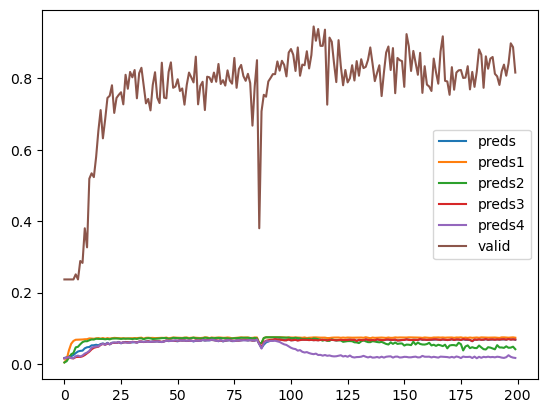

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)

  0%|          | 0/200 [00:00<?, ?it/s]

***训练集***

main branch： 0.2025

准确识别驾驶员： 0.0575

无法准确识别驾驶员： 0.06

准确识别行为： 0.19875

无法准确识别行为： 0.19375

flag1 0.0575 flag2 0.19875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  0%|          | 1/200 [00:06<20:04,  6.05s/it]

valid-f1: 0.03830093592512599

valid-precision: 0.023686553873552983

valid-recall: 0.1

process: 1  loss: 195.26093196868896  train_correct: 0.0 valid_loss 79.79375159740448  val_correct: 0.23686553873552982

The model has been saved!!

The best val_acc is  0.23686553873552982

***训练集***

main branch： 0.22375

准确识别驾驶员： 0.1225

无法准确识别驾驶员： 0.09125

准确识别行为： 0.23125

无法准确识别行为： 0.23125

flag1 0.1225 flag2 0.23125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  1%|          | 2/200 [00:12<19:48,  6.00s/it]

valid-f1: 0.03830093592512599

valid-precision: 0.023686553873552983

valid-recall: 0.1

process: 2  loss: 188.59792709350586  train_correct: 0.0 valid_loss 79.15807366371155  val_correct: 0.23686553873552982

***训练集***

main branch： 0.2375

准确识别驾驶员： 0.4175

无法准确识别驾驶员： 0.21875

准确识别行为： 0.20625

无法准确识别行为： 0.20875

flag1 0.4175 flag2 0.20625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 3/200 [00:18<19:46,  6.02s/it]

valid-f1: 0.03830093592512599

valid-precision: 0.023686553873552983

valid-recall: 0.1

process: 3  loss: 166.35469388961792  train_correct: 0.0 valid_loss 79.26170206069946  val_correct: 0.23686553873552982

***训练集***

main branch： 0.295

准确识别驾驶员： 0.71125

无法准确识别驾驶员： 0.34125

准确识别行为： 0.22

无法准确识别行为： 0.225

flag1 0.71125 flag2 0.22


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 4/200 [00:24<20:05,  6.15s/it]

valid-f1: 0.03830093592512599

valid-precision: 0.023686553873552983

valid-recall: 0.1

process: 4  loss: 136.5956506729126  train_correct: 0.0 valid_loss 78.73112940788269  val_correct: 0.23686553873552982

***训练集***

main branch： 0.30375

准确识别驾驶员： 0.85375

无法准确识别驾驶员： 0.58875

准确识别行为： 0.2475

无法准确识别行为： 0.2475

flag1 0.85375 flag2 0.2475


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  2%|▎         | 5/200 [00:30<19:48,  6.10s/it]

valid-f1: 0.03830093592512599

valid-precision: 0.023686553873552983

valid-recall: 0.1

process: 5  loss: 121.55595350265503  train_correct: 0.0 valid_loss 78.34772193431854  val_correct: 0.23686553873552982

***训练集***

main branch： 0.34125

准确识别驾驶员： 0.86875

无法准确识别驾驶员： 0.63875

准确识别行为： 0.2075

无法准确识别行为： 0.22625

flag1 0.86875 flag2 0.2075


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  3%|▎         | 6/200 [00:36<19:36,  6.06s/it]

valid-f1: 0.03830093592512599

valid-precision: 0.023686553873552983

valid-recall: 0.1

process: 6  loss: 115.98179006576538  train_correct: 0.0 valid_loss 77.90955054759979  val_correct: 0.23686553873552982

***训练集***

main branch： 0.4225

准确识别驾驶员： 0.91375

无法准确识别驾驶员： 0.65125

准确识别行为： 0.26625

无法准确识别行为： 0.30875

flag1 0.91375 flag2 0.26625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  4%|▎         | 7/200 [00:42<19:23,  6.03s/it]

valid-f1: 0.03830093592512599

valid-precision: 0.023686553873552983

valid-recall: 0.1

process: 7  loss: 102.62984037399292  train_correct: 0.0 valid_loss 77.49828004837036  val_correct: 0.23686553873552982

***训练集***

main branch： 0.5175

准确识别驾驶员： 0.915

无法准确识别驾驶员： 0.795

准确识别行为： 0.25625

无法准确识别行为： 0.2875

flag1 0.915 flag2 0.25625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 8/200 [00:48<19:20,  6.04s/it]

valid-f1: 0.057802314113203926

valid-precision: 0.060067829457364344

valid-recall: 0.11194290073008609

process: 8  loss: 97.9360716342926  train_correct: 0.0 valid_loss 75.51948273181915  val_correct: 0.25111308993766696

The model has been saved!!

The best val_acc is  0.25111308993766696

***训练集***

main branch： 0.5

准确识别驾驶员： 0.9325

无法准确识别驾驶员： 0.80375

准确识别行为： 0.30625

无法准确识别行为： 0.32

flag1 0.9325 flag2 0.30625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 9/200 [00:54<19:32,  6.14s/it]

valid-f1: 0.09840259445685798

valid-precision: 0.07290595225898985

valid-recall: 0.16774000217936144

process: 9  loss: 94.44213247299194  train_correct: 0.0 valid_loss 71.38040459156036  val_correct: 0.3196794300979519

The model has been saved!!

The best val_acc is  0.3196794300979519

***训练集***

main branch： 0.52625

准确识别驾驶员： 0.88375

无法准确识别驾驶员： 0.81875

准确识别行为： 0.335

无法准确识别行为： 0.35625

flag1 0.88375 flag2 0.335


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  5%|▌         | 10/200 [01:00<19:18,  6.10s/it]

valid-f1: 0.09818033387546264

valid-precision: 0.0685575810762296

valid-recall: 0.1782499727579819

process: 10  loss: 93.62449193000793  train_correct: 0.0 valid_loss 69.92510831356049  val_correct: 0.3089937666963491

***训练集***

main branch： 0.6375

准确识别驾驶员： 0.92875

无法准确识别驾驶员： 0.85875

准确识别行为： 0.36625

无法准确识别行为： 0.41

flag1 0.92875 flag2 0.36625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  6%|▌         | 11/200 [01:06<19:11,  6.09s/it]

valid-f1: 0.24441334132500986

valid-precision: 0.29329394130565317

valid-recall: 0.28666594021285097

process: 11  loss: 79.56587016582489  train_correct: 0.0 valid_loss 64.64653694629669  val_correct: 0.352626892252894

The model has been saved!!

The best val_acc is  0.352626892252894

***训练集***

main branch： 0.61875

准确识别驾驶员： 0.92

无法准确识别驾驶员： 0.8925

准确识别行为： 0.42875

无法准确识别行为： 0.4875

flag1 0.92 flag2 0.42875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  6%|▌         | 12/200 [01:12<18:58,  6.06s/it]

valid-f1: 0.26097425078660796

valid-precision: 0.29613680820179256

valid-recall: 0.31220293817547823

process: 12  loss: 78.85141491889954  train_correct: 0.0 valid_loss 60.39033800363541  val_correct: 0.3846838824577026

The model has been saved!!

The best val_acc is  0.3846838824577026

***训练集***

main branch： 0.665

准确识别驾驶员： 0.9275

无法准确识别驾驶员： 0.91125

准确识别行为： 0.53625

无法准确识别行为： 0.5625

flag1 0.9275 flag2 0.53625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  6%|▋         | 13/200 [01:18<18:52,  6.06s/it]

valid-f1: 0.5306557234155596

valid-precision: 0.672101562110482

valid-recall: 0.5381262444649172

process: 13  loss: 71.81465220451355  train_correct: 0.0 valid_loss 50.32225173711777  val_correct: 0.6179875333926982

The model has been saved!!

The best val_acc is  0.6179875333926982

***训练集***

main branch： 0.695

准确识别驾驶员： 0.93125

无法准确识别驾驶员： 0.90875

准确识别行为： 0.6025

无法准确识别行为： 0.62375

flag1 0.93125 flag2 0.6025


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  7%|▋         | 14/200 [01:25<18:57,  6.12s/it]

valid-f1: 0.37524413037840665

valid-precision: 0.4537542950178657

valid-recall: 0.3924847031940853

process: 14  loss: 63.59113585948944  train_correct: 0.0 valid_loss 47.966426730155945  val_correct: 0.47996438112199463

***训练集***

main branch： 0.72375

准确识别驾驶员： 0.93375

无法准确识别驾驶员： 0.9175

准确识别行为： 0.65125

无法准确识别行为： 0.66875

flag1 0.93375 flag2 0.65125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  8%|▊         | 15/200 [01:31<18:45,  6.08s/it]

valid-f1: 0.4760882175741342

valid-precision: 0.5035165244998596

valid-recall: 0.5117354123120713

process: 15  loss: 58.660900592803955  train_correct: 0.0 valid_loss 42.17094707489014  val_correct: 0.5414069456812111

***训练集***

main branch： 0.73375

准确识别驾驶员： 0.92375

无法准确识别驾驶员： 0.91125

准确识别行为： 0.68

无法准确识别行为： 0.68125

flag1 0.92375 flag2 0.68


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

  8%|▊         | 16/200 [01:37<18:36,  6.07s/it]

valid-f1: 0.6521935901285714

valid-precision: 0.665208338756447

valid-recall: 0.697234918653683

process: 16  loss: 55.799278140068054  train_correct: 0.0 valid_loss 35.61557027697563  val_correct: 0.6918967052537845

The model has been saved!!

The best val_acc is  0.6918967052537845

***训练集***

main branch： 0.735

准确识别驾驶员： 0.91

无法准确识别驾驶员： 0.90375

准确识别行为： 0.68625

无法准确识别行为： 0.68875

flag1 0.91 flag2 0.68625


  8%|▊         | 17/200 [01:43<18:25,  6.04s/it]

valid-f1: 0.638323924885962

valid-precision: 0.67155794961036

valid-recall: 0.6774376355909537

process: 17  loss: 55.16584241390228  train_correct: 0.0 valid_loss 43.76499253511429  val_correct: 0.6464826357969724

***训练集***

main branch： 0.72625

准确识别驾驶员： 0.9425

无法准确识别驾驶员： 0.9

准确识别行为： 0.72125

无法准确识别行为： 0.7175

flag1 0.9425 flag2 0.72125


  9%|▉         | 18/200 [01:49<18:25,  6.07s/it]

valid-f1: 0.7050057903632184

valid-precision: 0.7649908023965007

valid-recall: 0.702833133558534

process: 18  loss: 51.04164481163025  train_correct: 0.0 valid_loss 32.52136331796646  val_correct: 0.705253784505788

The model has been saved!!

The best val_acc is  0.705253784505788

***训练集***

main branch： 0.75125

准确识别驾驶员： 0.94375

无法准确识别驾驶员： 0.93125

准确识别行为： 0.74

无法准确识别行为： 0.73625

flag1 0.94375 flag2 0.74


 10%|▉         | 19/200 [01:55<18:25,  6.11s/it]

valid-f1: 0.703242980668499

valid-precision: 0.784154057111106

valid-recall: 0.7411842253855985

process: 19  loss: 47.82978844642639  train_correct: 0.0 valid_loss 30.45936670899391  val_correct: 0.7275155832591274

The model has been saved!!

The best val_acc is  0.7275155832591274

***训练集***

main branch： 0.775

准确识别驾驶员： 0.93625

无法准确识别驾驶员： 0.91375

准确识别行为： 0.75125

无法准确识别行为： 0.74875

flag1 0.93625 flag2 0.75125


 10%|█         | 20/200 [02:01<18:28,  6.16s/it]

valid-f1: 0.7390155399929629

valid-precision: 0.8265072515087967

valid-recall: 0.7192755406302316

process: 20  loss: 44.86211681365967  train_correct: 0.0 valid_loss 27.408604741096497  val_correct: 0.7711487088156723

The model has been saved!!

The best val_acc is  0.7711487088156723

***训练集***

main branch： 0.7675

准确识别驾驶员： 0.96375

无法准确识别驾驶员： 0.94625

准确识别行为： 0.75625

无法准确识别行为： 0.75625

flag1 0.96375 flag2 0.75625


 10%|█         | 21/200 [02:07<18:16,  6.13s/it]

valid-f1: 0.7578056013856826

valid-precision: 0.7741929650647397

valid-recall: 0.7662226118656326

process: 21  loss: 42.313008069992065  train_correct: 0.0 valid_loss 25.901494473218918  val_correct: 0.7595725734639359

***训练集***

main branch： 0.73875

准确识别驾驶员： 0.9475

无法准确识别驾驶员： 0.92125

准确识别行为： 0.75625

无法准确识别行为： 0.75625

flag1 0.9475 flag2 0.75625


 11%|█         | 22/200 [02:13<18:06,  6.11s/it]

valid-f1: 0.7750142352958663

valid-precision: 0.7975577671780755

valid-recall: 0.7845575995324279

process: 22  loss: 45.53610837459564  train_correct: 0.0 valid_loss 28.20225116610527  val_correct: 0.7845057880676759

The model has been saved!!

The best val_acc is  0.7845057880676759

***训练集***

main branch： 0.755

准确识别驾驶员： 0.93875

无法准确识别驾驶员： 0.91375

准确识别行为： 0.7675

无法准确识别行为： 0.75875

flag1 0.93875 flag2 0.7675


 12%|█▏        | 23/200 [02:19<17:52,  6.06s/it]

valid-f1: 0.7569810025421452

valid-precision: 0.7760574284883839

valid-recall: 0.7706395534290271

process: 23  loss: 43.734772086143494  train_correct: 0.0 valid_loss 28.536384522914886  val_correct: 0.7435440783615316

***训练集***

main branch： 0.78375

准确识别驾驶员： 0.96125

无法准确识别驾驶员： 0.9275

准确识别行为： 0.7875

无法准确识别行为： 0.7875

flag1 0.96125 flag2 0.7875


 12%|█▏        | 24/200 [02:25<17:43,  6.04s/it]

valid-f1: 0.7493266185529672

valid-precision: 0.7778902843637051

valid-recall: 0.7632695077614986

process: 24  loss: 40.65235233306885  train_correct: 0.0 valid_loss 25.294182024896145  val_correct: 0.7524487978628673

***训练集***

main branch： 0.80125

准确识别驾驶员： 0.9475

无法准确识别驾驶员： 0.925

准确识别行为： 0.8

无法准确识别行为： 0.79125

flag1 0.9475 flag2 0.8


 12%|█▎        | 25/200 [02:32<17:51,  6.13s/it]

valid-f1: 0.7399499066730187

valid-precision: 0.7838224041814585

valid-recall: 0.7739856921618935

process: 25  loss: 37.889612555503845  train_correct: 0.0 valid_loss 32.38504005223513  val_correct: 0.7355298308103295

***训练集***

main branch： 0.79875

准确识别驾驶员： 0.94375

无法准确识别驾驶员： 0.9225

准确识别行为： 0.7975

无法准确识别行为： 0.80375

flag1 0.94375 flag2 0.7975


 13%|█▎        | 26/200 [02:38<17:37,  6.08s/it]

valid-f1: 0.7809427456923108

valid-precision: 0.7897661682803454

valid-recall: 0.8027925578108643

process: 26  loss: 36.413854360580444  train_correct: 0.0 valid_loss 23.704556927084923  val_correct: 0.7747105966162066

***训练集***

main branch： 0.825

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.95

准确识别行为： 0.81625

无法准确识别行为： 0.81625

flag1 0.96625 flag2 0.81625


 14%|█▎        | 27/200 [02:44<17:29,  6.07s/it]

valid-f1: 0.8115911648951801

valid-precision: 0.8178023241891713

valid-recall: 0.8250149451362268

process: 27  loss: 32.4402682185173  train_correct: 0.0 valid_loss 22.767593597993255  val_correct: 0.8058771148708815

The model has been saved!!

The best val_acc is  0.8058771148708815

***训练集***

main branch： 0.795

准确识别驾驶员： 0.94375

无法准确识别驾驶员： 0.92125

准确识别行为： 0.81875

无法准确识别行为： 0.81125

flag1 0.94375 flag2 0.81875


 14%|█▍        | 28/200 [02:50<17:22,  6.06s/it]

valid-f1: 0.8110277221806376

valid-precision: 0.8129344233762843

valid-recall: 0.8272618337675546

process: 28  loss: 35.62995618581772  train_correct: 0.0 valid_loss 18.1899299249053  val_correct: 0.8174532502226179

The model has been saved!!

The best val_acc is  0.8174532502226179

***训练集***

main branch： 0.81625

准确识别驾驶员： 0.95375

无法准确识别驾驶员： 0.95125

准确识别行为： 0.8175

无法准确识别行为： 0.82125

flag1 0.95375 flag2 0.8175


 14%|█▍        | 29/200 [02:56<17:12,  6.04s/it]

valid-f1: 0.7207327187234945

valid-precision: 0.7391952569179383

valid-recall: 0.7666505393919583

process: 29  loss: 33.88277608156204  train_correct: 0.0 valid_loss 34.20507872104645  val_correct: 0.7088156723063224

***训练集***

main branch： 0.78

准确识别驾驶员： 0.94125

无法准确识别驾驶员： 0.93375

准确识别行为： 0.77125

无法准确识别行为： 0.78

flag1 0.94125 flag2 0.77125


 15%|█▌        | 30/200 [03:02<17:25,  6.15s/it]

valid-f1: 0.828382028800498

valid-precision: 0.8568200598786948

valid-recall: 0.8281484706496147

process: 30  loss: 40.45055848360062  train_correct: 0.0 valid_loss 20.433670402504504  val_correct: 0.8486197684772929

The model has been saved!!

The best val_acc is  0.8486197684772929

***训练集***

main branch： 0.78875

准确识别驾驶员： 0.95875

无法准确识别驾驶员： 0.93625

准确识别行为： 0.79375

无法准确识别行为： 0.7975

flag1 0.95875 flag2 0.79375


 16%|█▌        | 31/200 [03:08<17:12,  6.11s/it]

valid-f1: 0.8259201436764017

valid-precision: 0.8430630688720532

valid-recall: 0.8220547118785106

process: 31  loss: 37.16266655921936  train_correct: 0.0 valid_loss 19.694841347634792  val_correct: 0.8076580587711487

***训练集***

main branch： 0.8275

准确识别驾驶员： 0.96

无法准确识别驾驶员： 0.95625

准确识别行为： 0.83125

无法准确识别行为： 0.8275

flag1 0.96 flag2 0.83125


 16%|█▌        | 32/200 [03:14<17:00,  6.08s/it]

valid-f1: 0.6528438572402157

valid-precision: 0.7293093882779498

valid-recall: 0.6830317922606253

process: 32  loss: 30.15329271554947  train_correct: 0.0 valid_loss 37.66296324133873  val_correct: 0.634906500445236

***训练集***

main branch： 0.81

准确识别驾驶员： 0.9575

无法准确识别驾驶员： 0.945

准确识别行为： 0.8125

无法准确识别行为： 0.8225

flag1 0.9575 flag2 0.8125


 16%|█▋        | 33/200 [03:20<16:52,  6.06s/it]

valid-f1: 0.7580904762677138

valid-precision: 0.7569181865482998

valid-recall: 0.7916568826545944

process: 33  loss: 33.97045212984085  train_correct: 0.0 valid_loss 28.29879593849182  val_correct: 0.7408726625111309

***训练集***

main branch： 0.80875

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.96625

准确识别行为： 0.82375

无法准确识别行为： 0.82

flag1 0.9775 flag2 0.82375


 17%|█▋        | 34/200 [03:26<16:41,  6.03s/it]

valid-f1: 0.7951338508100569

valid-precision: 0.7979689741549405

valid-recall: 0.8386506483600306

process: 34  loss: 31.36662620306015  train_correct: 0.0 valid_loss 29.70638658106327  val_correct: 0.7907390917186109

***训练集***

main branch： 0.84375

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.95625

准确识别行为： 0.83875

无法准确识别行为： 0.83875

flag1 0.965 flag2 0.83875


 18%|█▊        | 35/200 [03:33<16:51,  6.13s/it]

valid-f1: 0.7698976007552616

valid-precision: 0.8096622803987781

valid-recall: 0.7883003061012215

process: 35  loss: 28.855411529541016  train_correct: 0.0 valid_loss 25.91210789233446  val_correct: 0.7373107747105966

***训练集***

main branch： 0.82875

准确识别驾驶员： 0.95125

无法准确识别驾驶员： 0.945

准确识别行为： 0.8225

无法准确识别行为： 0.82

flag1 0.95125 flag2 0.8225


 18%|█▊        | 36/200 [03:39<16:40,  6.10s/it]

valid-f1: 0.8019942134763793

valid-precision: 0.8310345277849629

valid-recall: 0.810833576034949

process: 36  loss: 31.175390422344208  train_correct: 0.0 valid_loss 20.517505560070276  val_correct: 0.7773820124666073

***训练集***

main branch： 0.84375

准确识别驾驶员： 0.95625

无法准确识别驾驶员： 0.93625

准确识别行为： 0.84875

无法准确识别行为： 0.835

flag1 0.95625 flag2 0.84875


 18%|█▊        | 37/200 [03:45<16:29,  6.07s/it]

valid-f1: 0.758865595855172

valid-precision: 0.7753240599110198

valid-recall: 0.7875307240433098

process: 37  loss: 28.463226675987244  train_correct: 0.0 valid_loss 22.78301740437746  val_correct: 0.7355298308103295

***训练集***

main branch： 0.835

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.95875

准确识别行为： 0.84125

无法准确识别行为： 0.83875

flag1 0.97875 flag2 0.84125


 19%|█▉        | 38/200 [03:51<16:18,  6.04s/it]

valid-f1: 0.7680183030982782

valid-precision: 0.8075043288223132

valid-recall: 0.7813624674334056

process: 38  loss: 27.597757071256638  train_correct: 0.0 valid_loss 27.187650449573994  val_correct: 0.742653606411398

***训练集***

main branch： 0.845

准确识别驾驶员： 0.9625

无法准确识别驾驶员： 0.94625

准确识别行为： 0.8525

无法准确识别行为： 0.84875

flag1 0.9625 flag2 0.8525


 20%|█▉        | 39/200 [03:56<16:09,  6.02s/it]

valid-f1: 0.8012916325450486

valid-precision: 0.79541965250464

valid-recall: 0.8263207458699448

process: 39  loss: 28.126658737659454  train_correct: 0.0 valid_loss 22.550819598138332  val_correct: 0.7836153161175423

***训练集***

main branch： 0.855

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.9575

准确识别行为： 0.85625

无法准确识别行为： 0.8525

flag1 0.97625 flag2 0.85625


 20%|██        | 40/200 [04:03<16:17,  6.11s/it]

valid-f1: 0.739686331719692

valid-precision: 0.7795885341926295

valid-recall: 0.7851884057971015

process: 40  loss: 25.60612380504608  train_correct: 0.0 valid_loss 33.84241021052003  val_correct: 0.7203918076580588

***训练集***

main branch： 0.82125

准确识别驾驶员： 0.96

无法准确识别驾驶员： 0.94375

准确识别行为： 0.81875

无法准确识别行为： 0.81625

flag1 0.96 flag2 0.81875


 20%|██        | 41/200 [04:09<16:05,  6.07s/it]

valid-f1: 0.8086360704582669

valid-precision: 0.802932740263954

valid-recall: 0.8499824726506648

process: 41  loss: 30.941097855567932  train_correct: 0.0 valid_loss 22.51726422831416  val_correct: 0.8023152270703473

***训练集***

main branch： 0.8075

准确识别驾驶员： 0.945

无法准确识别驾驶员： 0.9325

准确识别行为： 0.81375

无法准确识别行为： 0.81125

flag1 0.945 flag2 0.81375


 21%|██        | 42/200 [04:15<15:54,  6.04s/it]

valid-f1: 0.8418943028967452

valid-precision: 0.848610752606081

valid-recall: 0.8498966190179005

process: 42  loss: 33.62815219163895  train_correct: 0.0 valid_loss 18.62484908150509  val_correct: 0.8290293855743545

***训练集***

main branch： 0.82875

准确识别驾驶员： 0.9575

无法准确识别驾驶员： 0.94375

准确识别行为： 0.83875

无法准确识别行为： 0.825

flag1 0.9575 flag2 0.83875


 22%|██▏       | 43/200 [04:21<15:46,  6.03s/it]

valid-f1: 0.7881766985790553

valid-precision: 0.7936596385608399

valid-recall: 0.8077259386939021

process: 43  loss: 31.005635023117065  train_correct: 0.0 valid_loss 20.538323551416397  val_correct: 0.7782724844167409

***训练集***

main branch： 0.85

准确识别驾驶员： 0.95875

无法准确识别驾驶员： 0.93625

准确识别行为： 0.8575

无法准确识别行为： 0.85625

flag1 0.95875 flag2 0.8575


 22%|██▏       | 44/200 [04:27<15:41,  6.04s/it]

valid-f1: 0.7331444970501199

valid-precision: 0.7787494993535776

valid-recall: 0.7508574499489831

process: 44  loss: 28.069089770317078  train_correct: 0.0 valid_loss 29.17946771532297  val_correct: 0.711487088156723

***训练集***

main branch： 0.85875

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.95375

准确识别行为： 0.8525

无法准确识别行为： 0.8675

flag1 0.965 flag2 0.8525


 22%|██▎       | 45/200 [04:33<15:45,  6.10s/it]

valid-f1: 0.7507062790809884

valid-precision: 0.74776455600197

valid-recall: 0.7891778325920202

process: 45  loss: 26.03031587600708  train_correct: 0.0 valid_loss 29.52254495024681  val_correct: 0.7337488869100623

***训练集***

main branch： 0.86875

准确识别驾驶员： 0.96

无法准确识别驾驶员： 0.93375

准确识别行为： 0.86375

无法准确识别行为： 0.86625

flag1 0.96 flag2 0.86375


 23%|██▎       | 46/200 [04:39<15:34,  6.07s/it]

valid-f1: 0.6927454783396375

valid-precision: 0.7857208622694507

valid-recall: 0.732096717419372

process: 46  loss: 25.84600719809532  train_correct: 0.0 valid_loss 31.1241315305233  val_correct: 0.6794300979519146

***训练集***

main branch： 0.8525

准确识别驾驶员： 0.96375

无法准确识别驾驶员： 0.95

准确识别行为： 0.865

无法准确识别行为： 0.86625

flag1 0.96375 flag2 0.865


 24%|██▎       | 47/200 [04:45<15:29,  6.07s/it]

valid-f1: 0.8642190198859753

valid-precision: 0.8682793020238069

valid-recall: 0.8914654125432155

process: 47  loss: 25.05883577466011  train_correct: 0.0 valid_loss 19.49146362580359  val_correct: 0.8423864648263579

***训练集***

main branch： 0.88

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.95

准确识别行为： 0.87375

无法准确识别行为： 0.8825

flag1 0.97125 flag2 0.87375


 24%|██▍       | 48/200 [04:51<15:18,  6.04s/it]

valid-f1: 0.8090183671167759

valid-precision: 0.8306351122632296

valid-recall: 0.8346247899062545

process: 48  loss: 23.33253738284111  train_correct: 0.0 valid_loss 20.765304195694625  val_correct: 0.786286731967943

***训练集***

main branch： 0.84625

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.965

准确识别行为： 0.84375

无法准确识别行为： 0.845

flag1 0.97 flag2 0.84375


 24%|██▍       | 49/200 [04:57<15:12,  6.04s/it]

valid-f1: 0.8255475077873534

valid-precision: 0.8294074807732628

valid-recall: 0.8515949425606177

process: 49  loss: 28.407241702079773  train_correct: 0.0 valid_loss 26.288486052304506  val_correct: 0.8023152270703473

***训练集***

main branch： 0.8275

准确识别驾驶员： 0.95875

无法准确识别驾驶员： 0.9475

准确识别行为： 0.8425

无法准确识别行为： 0.83

flag1 0.95875 flag2 0.8425


 25%|██▌       | 50/200 [05:03<15:11,  6.08s/it]

valid-f1: 0.7355458931074564

valid-precision: 0.8087669159741478

valid-recall: 0.744228162633197

process: 50  loss: 27.934228479862213  train_correct: 0.0 valid_loss 34.760152156464756  val_correct: 0.6901157613535174

***训练集***

main branch： 0.86125

准确识别驾驶员： 0.95375

无法准确识别驾驶员： 0.93625

准确识别行为： 0.875

无法准确识别行为： 0.86625

flag1 0.95375 flag2 0.875


 26%|██▌       | 51/200 [05:10<15:14,  6.14s/it]

valid-f1: 0.8339399906433931

valid-precision: 0.8356314601098982

valid-recall: 0.8678082558174092

process: 51  loss: 25.81166309118271  train_correct: 0.0 valid_loss 21.28517565317452  val_correct: 0.8103294746215495

***训练集***

main branch： 0.8575

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.95375

准确识别行为： 0.86375

无法准确识别行为： 0.8675

flag1 0.975 flag2 0.86375


 26%|██▌       | 52/200 [05:16<15:06,  6.13s/it]

valid-f1: 0.8427924588863774

valid-precision: 0.8729911639350032

valid-recall: 0.842836772431738

process: 52  loss: 23.632463216781616  train_correct: 0.0 valid_loss 17.352096857503057  val_correct: 0.8495102404274265

The model has been saved!!

The best val_acc is  0.8495102404274265

***训练集***

main branch： 0.875

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.9575

准确识别行为： 0.8775

无法准确识别行为： 0.87

flag1 0.975 flag2 0.8775


 26%|██▋       | 53/200 [05:22<14:53,  6.08s/it]

valid-f1: 0.7800380620064782

valid-precision: 0.8039344035106785

valid-recall: 0.8078564395177666

process: 53  loss: 24.255876511335373  train_correct: 0.0 valid_loss 27.87002718448639  val_correct: 0.7818343722172751

***训练集***

main branch： 0.81875

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.9625

准确识别行为： 0.83375

无法准确识别行为： 0.83125

flag1 0.97625 flag2 0.83375


 27%|██▋       | 54/200 [05:28<14:45,  6.07s/it]

valid-f1: 0.7897695495980319

valid-precision: 0.8252174565279281

valid-recall: 0.8052220835355847

process: 54  loss: 27.361292600631714  train_correct: 0.0 valid_loss 19.351148687303066  val_correct: 0.7764915405164737

***训练集***

main branch： 0.8425

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.95125

准确识别行为： 0.845

无法准确识别行为： 0.85

flag1 0.975 flag2 0.845


 28%|██▊       | 55/200 [05:34<14:39,  6.07s/it]

valid-f1: 0.7814366897180711

valid-precision: 0.8262729480389371

valid-recall: 0.7817385426676045

process: 55  loss: 26.930207192897797  train_correct: 0.0 valid_loss 18.424055526033044  val_correct: 0.7782724844167409

***训练集***

main branch： 0.865

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.955

准确识别行为： 0.87625

无法准确识别行为： 0.865

flag1 0.975 flag2 0.87625


 28%|██▊       | 56/200 [05:40<14:44,  6.14s/it]

valid-f1: 0.74785958584413

valid-precision: 0.8281697746503024

valid-recall: 0.7594087689579679

process: 56  loss: 22.865313827991486  train_correct: 0.0 valid_loss 25.54687391780317  val_correct: 0.7453250222617988

***训练集***

main branch： 0.87375

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.96

准确识别行为： 0.8725

无法准确识别行为： 0.86875

flag1 0.965 flag2 0.8725


 28%|██▊       | 57/200 [05:46<14:35,  6.12s/it]

valid-f1: 0.8247153045774848

valid-precision: 0.859418593348851

valid-recall: 0.8194865028183106

process: 57  loss: 23.19367280602455  train_correct: 0.0 valid_loss 21.197141079232097  val_correct: 0.8210151380231523

***训练集***

main branch： 0.85375

准确识别驾驶员： 0.9625

无法准确识别驾驶员： 0.9575

准确识别行为： 0.85625

无法准确识别行为： 0.86125

flag1 0.9625 flag2 0.85625


 29%|██▉       | 58/200 [05:52<14:22,  6.08s/it]

valid-f1: 0.7770828859712071

valid-precision: 0.8014393526292751

valid-recall: 0.8151275652900367

process: 58  loss: 25.25879117846489  train_correct: 0.0 valid_loss 26.39687931537628  val_correct: 0.7658058771148709

***训练集***

main branch： 0.8325

准确识别驾驶员： 0.95625

无法准确识别驾驶员： 0.94

准确识别行为： 0.84

无法准确识别行为： 0.83875

flag1 0.95625 flag2 0.84


 30%|██▉       | 59/200 [05:58<14:16,  6.08s/it]

valid-f1: 0.7695130773173707

valid-precision: 0.7916005093476894

valid-recall: 0.7974484267321796

process: 59  loss: 28.33116263151169  train_correct: 0.0 valid_loss 28.908580124378204  val_correct: 0.7479964381121995

***训练集***

main branch： 0.85875

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.96

准确识别行为： 0.87125

无法准确识别行为： 0.87

flag1 0.975 flag2 0.87125


 30%|███       | 60/200 [06:04<14:11,  6.08s/it]

valid-f1: 0.7786684885217869

valid-precision: 0.8061108230234474

valid-recall: 0.8012238501391821

process: 60  loss: 23.446328788995743  train_correct: 0.0 valid_loss 24.24571462161839  val_correct: 0.7497773820124666

***训练集***

main branch： 0.8525

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.955

准确识别行为： 0.8525

无法准确识别行为： 0.845

flag1 0.97375 flag2 0.8525


 30%|███       | 61/200 [06:11<14:12,  6.13s/it]

valid-f1: 0.7319216447100481

valid-precision: 0.8168415754495033

valid-recall: 0.7355261671966478

process: 61  loss: 26.817298233509064  train_correct: 0.0 valid_loss 28.250364122912288  val_correct: 0.692787177203918

***训练集***

main branch： 0.85

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.95375

准确识别行为： 0.855

无法准确识别行为： 0.85

flag1 0.97 flag2 0.855


 31%|███       | 62/200 [06:17<14:00,  6.09s/it]

valid-f1: 0.7889686716119747

valid-precision: 0.8083161450168534

valid-recall: 0.811431269213878

process: 62  loss: 27.59656810760498  train_correct: 0.0 valid_loss 21.831696789711714  val_correct: 0.780053428317008

***训练集***

main branch： 0.87

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.97375

准确识别行为： 0.87625

无法准确识别行为： 0.88125

flag1 0.98 flag2 0.87625


 32%|███▏      | 63/200 [06:23<13:51,  6.07s/it]

valid-f1: 0.7388937192335515

valid-precision: 0.7948855430534745

valid-recall: 0.7671602986385596

process: 63  loss: 23.094766199588776  train_correct: 0.0 valid_loss 32.7719908375293  val_correct: 0.7212822796081924

***训练集***

main branch： 0.86125

准确识别驾驶员： 0.9625

无法准确识别驾驶员： 0.94625

准确识别行为： 0.8625

无法准确识别行为： 0.8625

flag1 0.9625 flag2 0.8625


 32%|███▏      | 64/200 [06:29<13:44,  6.06s/it]

valid-f1: 0.8341790247002896

valid-precision: 0.8607260765871002

valid-recall: 0.855517423334357

process: 64  loss: 24.646611660718918  train_correct: 0.0 valid_loss 22.748175321146846  val_correct: 0.8067675868210151

***训练集***

main branch： 0.86375

准确识别驾驶员： 0.96

无法准确识别驾驶员： 0.95125

准确识别行为： 0.8725

无法准确识别行为： 0.87125

flag1 0.96 flag2 0.8725


 32%|███▎      | 65/200 [06:35<13:39,  6.07s/it]

valid-f1: 0.8581480227096371

valid-precision: 0.8656960629655721

valid-recall: 0.8741966972767887

process: 65  loss: 23.19340482354164  train_correct: 0.0 valid_loss 16.929757038131356  val_correct: 0.8263579697239537

***训练集***

main branch： 0.88

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.95625

准确识别行为： 0.89

无法准确识别行为： 0.88625

flag1 0.97125 flag2 0.89


 33%|███▎      | 66/200 [06:41<13:45,  6.16s/it]

valid-f1: 0.8858625490152647

valid-precision: 0.899314433960406

valid-recall: 0.8909094607401243

process: 66  loss: 20.60130888223648  train_correct: 0.0 valid_loss 16.76222976669669  val_correct: 0.8664292074799644

The model has been saved!!

The best val_acc is  0.8664292074799644

***训练集***

main branch： 0.8575

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.9575

准确识别行为： 0.8625

无法准确识别行为： 0.85

flag1 0.97125 flag2 0.8625


 34%|███▎      | 67/200 [06:47<13:33,  6.12s/it]

valid-f1: 0.7410324314665889

valid-precision: 0.7983781664903251

valid-recall: 0.765587129880036

process: 67  loss: 24.333680242300034  train_correct: 0.0 valid_loss 29.75673683360219  val_correct: 0.717720391807658

***训练集***

main branch： 0.86875

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.95

准确识别行为： 0.87875

无法准确识别行为： 0.88

flag1 0.97875 flag2 0.87875


 34%|███▍      | 68/200 [06:53<13:26,  6.11s/it]

valid-f1: 0.7603767234532652

valid-precision: 0.7979176912454777

valid-recall: 0.7905076657387871

process: 68  loss: 21.79595375061035  train_correct: 0.0 valid_loss 30.929313138127327  val_correct: 0.7382012466607302

***训练集***

main branch： 0.86625

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.9525

准确识别行为： 0.86375

无法准确识别行为： 0.86875

flag1 0.975 flag2 0.86375


 34%|███▍      | 69/200 [06:59<13:19,  6.11s/it]

valid-f1: 0.7794744021991968

valid-precision: 0.8005322542264881

valid-recall: 0.8040924148315453

process: 69  loss: 22.78275430202484  train_correct: 0.0 valid_loss 22.754239428788424  val_correct: 0.7693677649154052

***训练集***

main branch： 0.86125

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.9625

准确识别行为： 0.8775

无法准确识别行为： 0.8775

flag1 0.975 flag2 0.8775


 35%|███▌      | 70/200 [07:05<13:17,  6.14s/it]

valid-f1: 0.6951092632561211

valid-precision: 0.772619760378708

valid-recall: 0.7159358574301367

process: 70  loss: 21.27239429950714  train_correct: 0.0 valid_loss 36.62714745104313  val_correct: 0.6776491540516474

***训练集***

main branch： 0.8475

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.965

准确识别行为： 0.85375

无法准确识别行为： 0.85125

flag1 0.97875 flag2 0.85375


 36%|███▌      | 71/200 [07:12<13:15,  6.16s/it]

valid-f1: 0.7799138693518826

valid-precision: 0.8319524888694207

valid-recall: 0.7973210397535341

process: 71  loss: 23.540679037570953  train_correct: 0.0 valid_loss 30.76188313961029  val_correct: 0.780053428317008

***训练集***

main branch： 0.89

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.965

准确识别行为： 0.8775

无法准确识别行为： 0.8825

flag1 0.98125 flag2 0.8775


 36%|███▌      | 72/200 [07:18<13:06,  6.14s/it]

valid-f1: 0.6755794855281677

valid-precision: 0.7283263764021869

valid-recall: 0.7038647739242705

process: 72  loss: 21.666262805461884  train_correct: 0.0 valid_loss 36.265779715031385  val_correct: 0.659839715048976

***训练集***

main branch： 0.87

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.975

准确识别行为： 0.88375

无法准确识别行为： 0.88

flag1 0.98125 flag2 0.88375


 36%|███▋      | 73/200 [07:24<12:57,  6.12s/it]

valid-f1: 0.8059015767521623

valid-precision: 0.811662099800418

valid-recall: 0.8162982291037212

process: 73  loss: 20.404719173908234  train_correct: 0.0 valid_loss 21.356058998033404  val_correct: 0.7916295636687445

***训练集***

main branch： 0.88125

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.97

准确识别行为： 0.885

无法准确识别行为： 0.8925

flag1 0.98125 flag2 0.885


 37%|███▋      | 74/200 [07:30<12:47,  6.09s/it]

valid-f1: 0.7521613350064531

valid-precision: 0.7915999320322258

valid-recall: 0.77532514091553

process: 74  loss: 18.526070296764374  train_correct: 0.0 valid_loss 29.286424186080694  val_correct: 0.7141585040071238

***训练集***

main branch： 0.88375

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.97

准确识别行为： 0.87875

无法准确识别行为： 0.88875

flag1 0.98 flag2 0.87875


 38%|███▊      | 75/200 [07:36<12:41,  6.09s/it]

valid-f1: 0.72537908043502

valid-precision: 0.7557700858970121

valid-recall: 0.7604056319983094

process: 75  loss: 19.70979741215706  train_correct: 0.0 valid_loss 35.353927452117205  val_correct: 0.6901157613535174

***训练集***

main branch： 0.865

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.97125

准确识别行为： 0.87375

无法准确识别行为： 0.8725

flag1 0.97875 flag2 0.87375


 38%|███▊      | 76/200 [07:42<12:38,  6.12s/it]

valid-f1: 0.7732422551287865

valid-precision: 0.8162822347781414

valid-recall: 0.7733989816438329

process: 76  loss: 22.385550558567047  train_correct: 0.0 valid_loss 22.834442239254713  val_correct: 0.7373107747105966

***训练集***

main branch： 0.85125

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.965

准确识别行为： 0.87125

无法准确识别行为： 0.86375

flag1 0.96625 flag2 0.87125


 38%|███▊      | 77/200 [07:48<12:30,  6.10s/it]

valid-f1: 0.8292900449536136

valid-precision: 0.847906646601111

valid-recall: 0.8469466221548603

process: 77  loss: 24.30679202079773  train_correct: 0.0 valid_loss 17.38597723841667  val_correct: 0.8058771148708815

***训练集***

main branch： 0.86875

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.9625

准确识别行为： 0.86625

无法准确识别行为： 0.8675

flag1 0.9775 flag2 0.86625


 39%|███▉      | 78/200 [07:54<12:23,  6.09s/it]

valid-f1: 0.8813250569983481

valid-precision: 0.875608719075804

valid-recall: 0.9071808308650414

process: 78  loss: 21.336108803749084  train_correct: 0.0 valid_loss 13.77740113902837  val_correct: 0.8753339269813001

The model has been saved!!

The best val_acc is  0.8753339269813001

***训练集***

main branch： 0.88

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.97125

准确识别行为： 0.875

无法准确识别行为： 0.88375

flag1 0.975 flag2 0.875


 40%|███▉      | 79/200 [08:00<12:14,  6.07s/it]

valid-f1: 0.8349984244050728

valid-precision: 0.8585991039888041

valid-recall: 0.846453782678039

process: 79  loss: 21.27624487876892  train_correct: 0.0 valid_loss 19.61197715625167  val_correct: 0.811219946571683

***训练集***

main branch： 0.88375

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.95875

准确识别行为： 0.8975

无法准确识别行为： 0.89625

flag1 0.97125 flag2 0.8975


 40%|████      | 80/200 [08:06<12:06,  6.06s/it]

valid-f1: 0.7843638184616195

valid-precision: 0.8031707649703625

valid-recall: 0.8221771127423301

process: 80  loss: 18.811902165412903  train_correct: 0.0 valid_loss 24.467477943748236  val_correct: 0.7666963490650045

***训练集***

main branch： 0.875

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.9625

准确识别行为： 0.87625

无法准确识别行为： 0.8775

flag1 0.97125 flag2 0.87625


 40%|████      | 81/200 [08:12<12:00,  6.06s/it]

valid-f1: 0.7669827988050895

valid-precision: 0.7886015030743113

valid-recall: 0.8107739936138106

process: 81  loss: 21.08037957549095  train_correct: 0.0 valid_loss 32.07731080055237  val_correct: 0.7497773820124666

***训练集***

main branch： 0.86125

准确识别驾驶员： 0.96

无法准确识别驾驶员： 0.94875

准确识别行为： 0.86625

无法准确识别行为： 0.86125

flag1 0.96 flag2 0.86625


 41%|████      | 82/200 [08:19<12:02,  6.12s/it]

valid-f1: 0.7879628876473048

valid-precision: 0.7951934516745883

valid-recall: 0.8207520580106392

process: 82  loss: 24.346074521541595  train_correct: 0.0 valid_loss 19.96098013781011  val_correct: 0.7693677649154052

***训练集***

main branch： 0.875

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.96

准确识别行为： 0.8775

无法准确识别行为： 0.86875

flag1 0.96875 flag2 0.8775


 42%|████▏     | 83/200 [08:25<11:54,  6.11s/it]

valid-f1: 0.8490738623473995

valid-precision: 0.8638085526024902

valid-recall: 0.8628218405037626

process: 83  loss: 22.271762669086456  train_correct: 0.0 valid_loss 16.93510643951595  val_correct: 0.8414959928762245

***训练集***

main branch： 0.87375

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.9675

准确识别行为： 0.88375

无法准确识别行为： 0.88125

flag1 0.9825 flag2 0.88375


 42%|████▏     | 84/200 [08:31<11:45,  6.09s/it]

valid-f1: 0.8158089569422788

valid-precision: 0.8400251372167069

valid-recall: 0.8385955666504865

process: 84  loss: 21.376574456691742  train_correct: 0.0 valid_loss 21.957097093574703  val_correct: 0.7818343722172751

***训练集***

main branch： 0.86625

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.96

准确识别行为： 0.87875

无法准确识别行为： 0.87625

flag1 0.9675 flag2 0.87875


 42%|████▎     | 85/200 [08:37<11:39,  6.08s/it]

valid-f1: 0.776502255514425

valid-precision: 0.8370994238761306

valid-recall: 0.7956483171036947

process: 85  loss: 21.209169447422028  train_correct: 0.0 valid_loss 20.80500204768032  val_correct: 0.7773820124666073

***训练集***

main branch： 0.88125

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.965

准确识别行为： 0.8925

无法准确识别行为： 0.8925

flag1 0.97125 flag2 0.8925


 43%|████▎     | 86/200 [08:43<11:28,  6.04s/it]

valid-f1: 0.8536151974957178

valid-precision: 0.8703858503360813

valid-recall: 0.867392846411153

process: 86  loss: 20.110501050949097  train_correct: 0.0 valid_loss 16.47938171029091  val_correct: 0.8495102404274265

***训练集***

main branch： 0.8675

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.965

准确识别行为： 0.8875

无法准确识别行为： 0.88375

flag1 0.9775 flag2 0.8875


 44%|████▎     | 87/200 [08:49<11:29,  6.10s/it]

valid-f1: 0.7794138661499275

valid-precision: 0.7999263175093867

valid-recall: 0.8059707899524833

process: 87  loss: 21.553094685077667  train_correct: 0.0 valid_loss 22.806264236569405  val_correct: 0.7577916295636687

***训练集***

main branch： 0.8925

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.98375

准确识别行为： 0.88875

无法准确识别行为： 0.88375

flag1 0.97875 flag2 0.88875


 44%|████▍     | 88/200 [08:55<11:21,  6.08s/it]

valid-f1: 0.8078143094202824

valid-precision: 0.8100707555580936

valid-recall: 0.8262761845324775

process: 88  loss: 19.952147662639618  train_correct: 0.0 valid_loss 16.993735073134303  val_correct: 0.8085485307212823

***训练集***

main branch： 0.88

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.97375

准确识别行为： 0.89125

无法准确识别行为： 0.88875

flag1 0.98375 flag2 0.89125


 44%|████▍     | 89/200 [09:01<11:11,  6.05s/it]

valid-f1: 0.8497408644911149

valid-precision: 0.8719950685212865

valid-recall: 0.8536084975284061

process: 89  loss: 18.792004138231277  train_correct: 0.0 valid_loss 14.874383432790637  val_correct: 0.8397150489759573

***训练集***

main branch： 0.87875

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.97625

准确识别行为： 0.8875

无法准确识别行为： 0.89

flag1 0.9825 flag2 0.8875


 45%|████▌     | 90/200 [09:07<11:05,  6.05s/it]

valid-f1: 0.865363019384022

valid-precision: 0.8678095122769636

valid-recall: 0.8764567413263065

process: 90  loss: 19.278567373752594  train_correct: 0.0 valid_loss 12.979817919433117  val_correct: 0.8557435440783615

***训练集***

main branch： 0.89125

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.97625

准确识别行为： 0.88375

无法准确识别行为： 0.88875

flag1 0.9775 flag2 0.88375


 46%|████▌     | 91/200 [09:13<10:58,  6.04s/it]

valid-f1: 0.8179689038084312

valid-precision: 0.802354475545938

valid-recall: 0.8574394517254929

process: 91  loss: 19.367682054638863  train_correct: 0.0 valid_loss 22.12293091416359  val_correct: 0.8005342831700801

***训练集***

main branch： 0.85375

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.9775

准确识别行为： 0.86875

无法准确识别行为： 0.865

flag1 0.9825 flag2 0.86875


 46%|████▌     | 92/200 [09:19<11:00,  6.11s/it]

valid-f1: 0.6935575578902907

valid-precision: 0.7475281669017388

valid-recall: 0.7289248516548288

process: 92  loss: 23.11551532149315  train_correct: 0.0 valid_loss 28.4242437556386  val_correct: 0.6794300979519146

***训练集***

main branch： 0.875

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.96375

准确识别行为： 0.8775

无法准确识别行为： 0.88125

flag1 0.97125 flag2 0.8775


 46%|████▋     | 93/200 [09:25<10:51,  6.09s/it]

valid-f1: 0.8117126918508818

valid-precision: 0.8540260948125203

valid-recall: 0.8190797613269011

process: 93  loss: 21.819649696350098  train_correct: 0.0 valid_loss 17.03917983546853  val_correct: 0.8165627782724845

***训练集***

main branch： 0.89125

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.96875

准确识别行为： 0.89125

无法准确识别行为： 0.89

flag1 0.9775 flag2 0.89125


 47%|████▋     | 94/200 [09:31<10:40,  6.05s/it]

valid-f1: 0.8621863637437883

valid-precision: 0.8772424207385121

valid-recall: 0.8619167549968465

process: 94  loss: 18.916883885860443  train_correct: 0.0 valid_loss 13.680347250308841  val_correct: 0.8655387355298308

***训练集***

main branch： 0.89375

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.98125

准确识别行为： 0.8975

无法准确识别行为： 0.89125

flag1 0.9825 flag2 0.8975


 48%|████▊     | 95/200 [09:37<10:33,  6.03s/it]

valid-f1: 0.8029794631037666

valid-precision: 0.8696463169864002

valid-recall: 0.7992618304654918

process: 95  loss: 18.09015890955925  train_correct: 0.0 valid_loss 17.113637959584594  val_correct: 0.8103294746215495

***训练集***

main branch： 0.89

准确识别驾驶员： 0.985

无法准确识别驾驶员： 0.98

准确识别行为： 0.90375

无法准确识别行为： 0.90625

flag1 0.985 flag2 0.90375

预热结束


 48%|████▊     | 96/200 [09:43<10:27,  6.04s/it]

valid-f1: 0.8644038327853067

valid-precision: 0.8890551968641788

valid-recall: 0.8712365168520775

process: 96  loss: 17.41629758477211  train_correct: 0.0 valid_loss 15.362101301550865  val_correct: 0.8566340160284951

***训练集***

main branch： 0.77125

准确识别驾驶员： 0.85375

无法准确识别驾驶员： 0.86625

准确识别行为： 0.78

无法准确识别行为： 0.76875

flag1 0.85375 flag2 0.78


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

 48%|████▊     | 97/200 [09:50<10:29,  6.11s/it]

valid-f1: 0.3317857410847113

valid-precision: 0.5378313882999202

valid-recall: 0.335684600169726

process: 97  loss: 292.89761686325073  train_correct: 0.0 valid_loss 66.8038067817688  val_correct: 0.3561887800534283

***训练集***

main branch： 0.57875

准确识别驾驶员： 0.83875

无法准确识别驾驶员： 0.84125

准确识别行为： 0.6425

无法准确识别行为： 0.58875

flag1 0.83875 flag2 0.6425


 49%|████▉     | 98/200 [09:56<10:21,  6.09s/it]

valid-f1: 0.6400249071957747

valid-precision: 0.7086881605013295

valid-recall: 0.6378736069422569

process: 98  loss: 135.64316654205322  train_correct: 0.0 valid_loss 47.18292701244354  val_correct: 0.622439893143366

***训练集***

main branch： 0.74

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.975

准确识别行为： 0.8075

无法准确识别行为： 0.7725

flag1 0.97 flag2 0.8075


 50%|████▉     | 99/200 [10:02<10:11,  6.06s/it]

valid-f1: 0.6995704806838952

valid-precision: 0.7311200159466438

valid-recall: 0.7311444982680679

process: 99  loss: 107.90284895896912  train_correct: 0.0 valid_loss 44.166191041469574  val_correct: 0.6812110418521816

***训练集***

main branch： 0.7775

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.99

准确识别行为： 0.8775

无法准确识别行为： 0.84375

flag1 0.98375 flag2 0.8775


 50%|█████     | 100/200 [10:08<10:06,  6.07s/it]

valid-f1: 0.7643048521718516

valid-precision: 0.7853861315541801

valid-recall: 0.8014697745681728

process: 100  loss: 94.14473795890808  train_correct: 0.0 valid_loss 41.93606048822403  val_correct: 0.7560106856634016

***训练集***

main branch： 0.84375

准确识别驾驶员： 0.98625

无法准确识别驾驶员： 0.99

准确识别行为： 0.89375

无法准确识别行为： 0.8625

flag1 0.98625 flag2 0.89375


 50%|█████     | 101/200 [10:14<10:01,  6.08s/it]

valid-f1: 0.8125819196479874

valid-precision: 0.8186858671486725

valid-recall: 0.8350576077875849

process: 101  loss: 83.537921667099  train_correct: 0.0 valid_loss 40.544871389865875  val_correct: 0.7943009795191451

***训练集***

main branch： 0.85625

准确识别驾驶员： 0.9875

无法准确识别驾驶员： 0.9875

准确识别行为： 0.87875

无法准确识别行为： 0.86125

flag1 0.9875 flag2 0.87875


 51%|█████     | 102/200 [10:20<09:57,  6.10s/it]

valid-f1: 0.7927873450333562

valid-precision: 0.8172642553064572

valid-recall: 0.8040680290977773

process: 102  loss: 77.13869571685791  train_correct: 0.0 valid_loss 40.07822543382645  val_correct: 0.761353517364203

***训练集***

main branch： 0.895

准确识别驾驶员： 0.98625

无法准确识别驾驶员： 0.985

准确识别行为： 0.925

无法准确识别行为： 0.86875

flag1 0.98625 flag2 0.925


 52%|█████▏    | 103/200 [10:26<09:51,  6.10s/it]

valid-f1: 0.832756013303998

valid-precision: 0.8529866931463159

valid-recall: 0.8358603491601203

process: 103  loss: 67.03196024894714  train_correct: 0.0 valid_loss 36.02962774038315  val_correct: 0.8076580587711487

***训练集***

main branch： 0.9025

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.98

准确识别行为： 0.905

无法准确识别行为： 0.8625

flag1 0.98125 flag2 0.905


 52%|█████▏    | 104/200 [10:32<09:42,  6.06s/it]

valid-f1: 0.8376834873026002

valid-precision: 0.8432282860768042

valid-recall: 0.8584107402894589

process: 104  loss: 61.83945107460022  train_correct: 0.0 valid_loss 38.82834219932556  val_correct: 0.8165627782724845

***训练集***

main branch： 0.8925

准确识别驾驶员： 0.985

无法准确识别驾驶员： 0.98375

准确识别行为： 0.88625

无法准确识别行为： 0.825

flag1 0.985 flag2 0.88625


 52%|█████▎    | 105/200 [10:38<09:35,  6.06s/it]

valid-f1: 0.8562791017613453

valid-precision: 0.8826945402497521

valid-recall: 0.8519758222961883

process: 105  loss: 58.52019429206848  train_correct: 0.0 valid_loss 36.65560430288315  val_correct: 0.8708815672306323

***训练集***

main branch： 0.8975

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.9725

准确识别行为： 0.89125

无法准确识别行为： 0.7675

flag1 0.98375 flag2 0.89125


 53%|█████▎    | 106/200 [10:44<09:29,  6.06s/it]

valid-f1: 0.8553793221157479

valid-precision: 0.8710853870182689

valid-recall: 0.8553567020317592

process: 106  loss: 53.86721658706665  train_correct: 0.0 valid_loss 32.38208705186844  val_correct: 0.8655387355298308

***训练集***

main branch： 0.91

准确识别驾驶员： 0.98625

无法准确识别驾驶员： 0.9825

准确识别行为： 0.89

无法准确识别行为： 0.76625

flag1 0.98625 flag2 0.89


 54%|█████▎    | 107/200 [10:51<09:30,  6.14s/it]

valid-f1: 0.8841493419200404

valid-precision: 0.8964222268763573

valid-recall: 0.8886509290353685

process: 107  loss: 49.213855385780334  train_correct: 0.0 valid_loss 31.892916083335876  val_correct: 0.8878005342831701

The model has been saved!!

The best val_acc is  0.8878005342831701

***训练集***

main branch： 0.88375

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.9625

准确识别行为： 0.87375

无法准确识别行为： 0.6825

flag1 0.97 flag2 0.87375


 54%|█████▍    | 108/200 [10:57<09:26,  6.16s/it]

valid-f1: 0.8974495902635535

valid-precision: 0.9249809505969502

valid-recall: 0.8831011454855849

process: 108  loss: 51.21081078052521  train_correct: 0.0 valid_loss 29.850101858377457  val_correct: 0.9065004452359751

The model has been saved!!

The best val_acc is  0.9065004452359751

***训练集***

main branch： 0.89375

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.9825

准确识别行为： 0.88125

无法准确识别行为： 0.665

flag1 0.9825 flag2 0.88125


 55%|█████▍    | 109/200 [11:03<09:19,  6.15s/it]

valid-f1: 0.9214096901085049

valid-precision: 0.9305153232262858

valid-recall: 0.9228550031204493

process: 109  loss: 47.20953977108002  train_correct: 0.0 valid_loss 31.968844056129456  val_correct: 0.9332146037399822

The model has been saved!!

The best val_acc is  0.9332146037399822

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.97375

准确识别行为： 0.87125

无法准确识别行为： 0.61

flag1 0.9775 flag2 0.87125


 55%|█████▌    | 110/200 [11:09<09:12,  6.14s/it]

valid-f1: 0.8860420066339803

valid-precision: 0.8942372049582976

valid-recall: 0.8989654769334404

process: 110  loss: 45.72092163562775  train_correct: 0.0 valid_loss 29.327998340129852  val_correct: 0.8940338379341051

***训练集***

main branch： 0.8925

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.95875

准确识别行为： 0.8775

无法准确识别行为： 0.5775

flag1 0.98 flag2 0.8775


 56%|█████▌    | 111/200 [11:15<09:04,  6.11s/it]

valid-f1: 0.862821092874092

valid-precision: 0.8700595486436968

valid-recall: 0.8740184222083537

process: 111  loss: 41.382627964019775  train_correct: 0.0 valid_loss 29.20927596092224  val_correct: 0.8682101513802315

***训练集***

main branch： 0.89125

准确识别驾驶员： 0.96125

无法准确识别驾驶员： 0.94875

准确识别行为： 0.87625

无法准确识别行为： 0.5475

flag1 0.96125 flag2 0.87625


 56%|█████▌    | 112/200 [11:21<08:55,  6.09s/it]

valid-f1: 0.9441972796843714

valid-precision: 0.9445195420417347

valid-recall: 0.9461181412028093

process: 112  loss: 42.033854603767395  train_correct: 0.0 valid_loss 24.74891224503517  val_correct: 0.9412288512911843

The model has been saved!!

The best val_acc is  0.9412288512911843

***训练集***

main branch： 0.885

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.94375

准确识别行为： 0.885

无法准确识别行为： 0.535

flag1 0.96625 flag2 0.885


 56%|█████▋    | 113/200 [11:28<08:57,  6.18s/it]

valid-f1: 0.8507973878271196

valid-precision: 0.8771830681379882

valid-recall: 0.8572986616739477

process: 113  loss: 41.45232832431793  train_correct: 0.0 valid_loss 25.653838485479355  val_correct: 0.8584149599287623

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.9525

准确识别行为： 0.87375

无法准确识别行为： 0.50375

flag1 0.96625 flag2 0.87375


 57%|█████▋    | 114/200 [11:34<08:48,  6.15s/it]

valid-f1: 0.8964218290253825

valid-precision: 0.9095223487952356

valid-recall: 0.9012647362807545

process: 114  loss: 38.87450194358826  train_correct: 0.0 valid_loss 23.61471939086914  val_correct: 0.8860195903829029

***训练集***

main branch： 0.895

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.94875

准确识别行为： 0.87375

无法准确识别行为： 0.4725

flag1 0.97625 flag2 0.87375


 57%|█████▊    | 115/200 [11:40<08:39,  6.11s/it]

valid-f1: 0.8497466450292747

valid-precision: 0.8749164508411262

valid-recall: 0.860280998940038

process: 115  loss: 37.9841194152832  train_correct: 0.0 valid_loss 25.65555113554001  val_correct: 0.8388245770258237

***训练集***

main branch： 0.90125

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.93125

准确识别行为： 0.89625

无法准确识别行为： 0.45625

flag1 0.9725 flag2 0.89625


 58%|█████▊    | 116/200 [11:46<08:31,  6.09s/it]

valid-f1: 0.8312237598251571

valid-precision: 0.8611805808866627

valid-recall: 0.8249743892009338

process: 116  loss: 35.84350061416626  train_correct: 0.0 valid_loss 22.337169736623764  val_correct: 0.8183437221727515

***训练集***

main branch： 0.89625

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.9375

准确识别行为： 0.89

无法准确识别行为： 0.45375

flag1 0.98125 flag2 0.89


 58%|█████▊    | 117/200 [11:52<08:23,  6.07s/it]

valid-f1: 0.8226306040515009

valid-precision: 0.873907442844444

valid-recall: 0.8211468790553459

process: 117  loss: 35.08315813541412  train_correct: 0.0 valid_loss 24.285701423883438  val_correct: 0.8317008014247551

***训练集***

main branch： 0.86875

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.94

准确识别行为： 0.86875

无法准确识别行为： 0.39875

flag1 0.97125 flag2 0.86875


 59%|█████▉    | 118/200 [11:58<08:26,  6.17s/it]

valid-f1: 0.7825671466432553

valid-precision: 0.8423928273067318

valid-recall: 0.7742065077053636

process: 118  loss: 37.081747114658356  train_correct: 0.0 valid_loss 25.671327620744705  val_correct: 0.773820124666073

***训练集***

main branch： 0.8975

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.9525

准确识别行为： 0.88875

无法准确识别行为： 0.43125

flag1 0.9825 flag2 0.88875


 60%|█████▉    | 119/200 [12:04<08:18,  6.16s/it]

valid-f1: 0.8598660704790522

valid-precision: 0.8687195253452409

valid-recall: 0.8695331741739064

process: 119  loss: 33.11672520637512  train_correct: 0.0 valid_loss 21.83387330174446  val_correct: 0.8584149599287623

***训练集***

main branch： 0.885

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.93625

准确识别行为： 0.885

无法准确识别行为： 0.3825

flag1 0.97625 flag2 0.885


 60%|██████    | 120/200 [12:10<08:10,  6.13s/it]

valid-f1: 0.8569831588420627

valid-precision: 0.87594863575417

valid-recall: 0.8629277046370868

process: 120  loss: 33.65117245912552  train_correct: 0.0 valid_loss 22.43351349234581  val_correct: 0.8619768477292965

***训练集***

main branch： 0.89625

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.93125

准确识别行为： 0.89375

无法准确识别行为： 0.4075

flag1 0.97 flag2 0.89375


 60%|██████    | 121/200 [12:16<08:01,  6.09s/it]

valid-f1: 0.8104124084393629

valid-precision: 0.8367132736229607

valid-recall: 0.8153141483484733

process: 121  loss: 32.70174866914749  train_correct: 0.0 valid_loss 22.957304805517197  val_correct: 0.8183437221727515

***训练集***

main branch： 0.88625

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.9225

准确识别行为： 0.88875

无法准确识别行为： 0.385

flag1 0.975 flag2 0.88875


 61%|██████    | 122/200 [12:22<07:53,  6.07s/it]

valid-f1: 0.8767831437313408

valid-precision: 0.8833309358111018

valid-recall: 0.8888023814476904

process: 122  loss: 31.99505203962326  train_correct: 0.0 valid_loss 19.919543623924255  val_correct: 0.8815672306322351

***训练集***

main branch： 0.87375

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.92625

准确识别行为： 0.88125

无法准确识别行为： 0.38

flag1 0.97625 flag2 0.88125


 62%|██████▏   | 123/200 [12:29<07:55,  6.17s/it]

valid-f1: 0.8884422797139105

valid-precision: 0.8917348811922793

valid-recall: 0.8923155451210372

process: 123  loss: 33.386393308639526  train_correct: 0.0 valid_loss 18.79433187097311  val_correct: 0.8851291184327693

***训练集***

main branch： 0.8975

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.91625

准确识别行为： 0.9025

无法准确识别行为： 0.36625

flag1 0.9675 flag2 0.9025


 62%|██████▏   | 124/200 [12:35<07:45,  6.12s/it]

valid-f1: 0.856198752240803

valid-precision: 0.871817894851939

valid-recall: 0.8631276280292299

process: 124  loss: 31.20554542541504  train_correct: 0.0 valid_loss 21.501943066716194  val_correct: 0.8673196794300979

***训练集***

main branch： 0.8925

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.9175

准确识别行为： 0.89625

无法准确识别行为： 0.325

flag1 0.96625 flag2 0.89625


 62%|██████▎   | 125/200 [12:41<07:36,  6.09s/it]

valid-f1: 0.8222504500613972

valid-precision: 0.8445693979173358

valid-recall: 0.8495869911933985

process: 125  loss: 31.46619075536728  train_correct: 0.0 valid_loss 23.221786305308342  val_correct: 0.8227960819234195

***训练集***

main branch： 0.90625

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.9125

准确识别行为： 0.9

无法准确识别行为： 0.36375

flag1 0.98 flag2 0.9


 63%|██████▎   | 126/200 [12:47<07:30,  6.09s/it]

valid-f1: 0.8632726787335487

valid-precision: 0.8840017063765335

valid-recall: 0.8663676384637483

process: 126  loss: 28.46318817138672  train_correct: 0.0 valid_loss 19.213340759277344  val_correct: 0.8637577916295637

***训练集***

main branch： 0.88125

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.905

准确识别行为： 0.8875

无法准确识别行为： 0.31375

flag1 0.9725 flag2 0.8875


 64%|██████▎   | 127/200 [12:53<07:21,  6.04s/it]

valid-f1: 0.8825577163034275

valid-precision: 0.9000988443698846

valid-recall: 0.8872825211909878

process: 127  loss: 30.105320274829865  train_correct: 0.0 valid_loss 17.62822714447975  val_correct: 0.8949243098842387

***训练集***

main branch： 0.9025

准确识别驾驶员： 0.985

无法准确识别驾驶员： 0.875

准确识别行为： 0.9

无法准确识别行为： 0.3

flag1 0.985 flag2 0.9


 64%|██████▍   | 128/200 [12:59<07:21,  6.13s/it]

valid-f1: 0.7801916024685633

valid-precision: 0.8158214590183901

valid-recall: 0.78970598432841

process: 128  loss: 28.278716325759888  train_correct: 0.0 valid_loss 23.226530015468597  val_correct: 0.7836153161175423

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.88

准确识别行为： 0.895

无法准确识别行为： 0.31125

flag1 0.9725 flag2 0.895


 64%|██████▍   | 129/200 [13:05<07:13,  6.10s/it]

valid-f1: 0.8508499578073101

valid-precision: 0.8565457840385611

valid-recall: 0.8570702348757269

process: 129  loss: 29.908719778060913  train_correct: 0.0 valid_loss 18.314013339579105  val_correct: 0.8468388245770259

***训练集***

main branch： 0.88625

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.86125

准确识别行为： 0.88375

无法准确识别行为： 0.2975

flag1 0.98125 flag2 0.88375


 65%|██████▌   | 130/200 [13:11<07:05,  6.08s/it]

valid-f1: 0.8094405611886696

valid-precision: 0.8347968844178739

valid-recall: 0.8289579185116942

process: 130  loss: 30.23225086927414  train_correct: 0.0 valid_loss 19.755596861243248  val_correct: 0.8040961709706145

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.96

无法准确识别驾驶员： 0.8425

准确识别行为： 0.88

无法准确识别行为： 0.2925

flag1 0.96 flag2 0.88


 66%|██████▌   | 131/200 [13:17<06:57,  6.06s/it]

valid-f1: 0.8174930456708749

valid-precision: 0.8457675801144069

valid-recall: 0.837124606641769

process: 131  loss: 30.958889484405518  train_correct: 0.0 valid_loss 22.248202681541443  val_correct: 0.8147818343722173

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.96375

无法准确识别驾驶员： 0.83125

准确识别行为： 0.89125

无法准确识别行为： 0.2875

flag1 0.96375 flag2 0.89125


 66%|██████▌   | 132/200 [13:23<06:49,  6.03s/it]

valid-f1: 0.8534631697590014

valid-precision: 0.8739276500667525

valid-recall: 0.8653069069247559

process: 132  loss: 30.810510516166687  train_correct: 0.0 valid_loss 18.26958766579628  val_correct: 0.8548530721282279

***训练集***

main branch： 0.8725

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.87875

准确识别行为： 0.89125

无法准确识别行为： 0.27125

flag1 0.97375 flag2 0.89125


 66%|██████▋   | 133/200 [13:29<06:49,  6.11s/it]

valid-f1: 0.8134659144389932

valid-precision: 0.812501798198548

valid-recall: 0.8427853295953984

process: 133  loss: 30.483514487743378  train_correct: 0.0 valid_loss 21.012171298265457  val_correct: 0.8121104185218165

***训练集***

main branch： 0.9125

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.83875

准确识别行为： 0.91625

无法准确识别行为： 0.3375

flag1 0.96625 flag2 0.91625


 67%|██████▋   | 134/200 [13:35<06:41,  6.09s/it]

valid-f1: 0.7692527918955003

valid-precision: 0.816418300652451

valid-recall: 0.7921713176221185

process: 134  loss: 26.619388341903687  train_correct: 0.0 valid_loss 25.14960054308176  val_correct: 0.7604630454140695

***训练集***

main branch： 0.895

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.82

准确识别行为： 0.89375

无法准确识别行为： 0.31375

flag1 0.97625 flag2 0.89375


 68%|██████▊   | 135/200 [13:41<06:33,  6.06s/it]

valid-f1: 0.8313658217690325

valid-precision: 0.8733069421232382

valid-recall: 0.8430221799558183

process: 135  loss: 28.43946599960327  train_correct: 0.0 valid_loss 21.321096509695053  val_correct: 0.8263579697239537

***训练集***

main branch： 0.89375

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.8275

准确识别行为： 0.9025

无法准确识别行为： 0.29375

flag1 0.97 flag2 0.9025


 68%|██████▊   | 136/200 [13:48<06:27,  6.06s/it]

valid-f1: 0.8264944594911416

valid-precision: 0.8657917498902654

valid-recall: 0.8386518767273916

process: 136  loss: 26.818671584129333  train_correct: 0.0 valid_loss 21.76884274184704  val_correct: 0.8121104185218165

***训练集***

main branch： 0.88

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.86375

准确识别行为： 0.8825

无法准确识别行为： 0.2825

flag1 0.9825 flag2 0.8825


 68%|██████▊   | 137/200 [13:54<06:21,  6.06s/it]

valid-f1: 0.8393831741996338

valid-precision: 0.8828159226645216

valid-recall: 0.8470813958479863

process: 137  loss: 27.216647803783417  train_correct: 0.0 valid_loss 20.795821458101273  val_correct: 0.8495102404274265

***训练集***

main branch： 0.87625

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.755

准确识别行为： 0.885

无法准确识别行为： 0.29875

flag1 0.97125 flag2 0.885


 69%|██████▉   | 138/200 [14:00<06:17,  6.09s/it]

valid-f1: 0.8824928317712892

valid-precision: 0.9098649880974605

valid-recall: 0.8861668400249636

process: 138  loss: 29.271745026111603  train_correct: 0.0 valid_loss 16.438346445560455  val_correct: 0.8958147818343722

***训练集***

main branch： 0.85375

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.8425

准确识别行为： 0.8625

无法准确识别行为： 0.28

flag1 0.98 flag2 0.8625


 70%|██████▉   | 139/200 [14:06<06:14,  6.14s/it]

valid-f1: 0.8817242186990649

valid-precision: 0.8935818960000562

valid-recall: 0.8863264386262099

process: 139  loss: 32.599300384521484  train_correct: 0.0 valid_loss 15.156280241906643  val_correct: 0.8788958147818343

***训练集***

main branch： 0.88

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.8025

准确识别行为： 0.89125

无法准确识别行为： 0.28125

flag1 0.97875 flag2 0.89125


 70%|███████   | 140/200 [14:12<06:06,  6.11s/it]

valid-f1: 0.7836109957684821

valid-precision: 0.8370784669463431

valid-recall: 0.7948790817623769

process: 140  loss: 27.208555102348328  train_correct: 0.0 valid_loss 23.70610749721527  val_correct: 0.7666963490650045

***训练集***

main branch： 0.91375

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.80625

准确识别行为： 0.915

无法准确识别行为： 0.26875

flag1 0.965 flag2 0.915


 70%|███████   | 141/200 [14:18<05:59,  6.09s/it]

valid-f1: 0.7909525000261514

valid-precision: 0.8318083206180763

valid-recall: 0.8180056762459508

process: 141  loss: 24.71206507086754  train_correct: 0.0 valid_loss 28.824943408370018  val_correct: 0.7764915405164737

***训练集***

main branch： 0.895

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.8325

准确识别行为： 0.9

无法准确识别行为： 0.28375

flag1 0.97 flag2 0.9


 71%|███████   | 142/200 [14:24<05:51,  6.07s/it]

valid-f1: 0.845484122128448

valid-precision: 0.866059295464996

valid-recall: 0.8598499212458023

process: 142  loss: 24.932813107967377  train_correct: 0.0 valid_loss 18.570128925144672  val_correct: 0.8406055209260909

***训练集***

main branch： 0.89625

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.7375

准确识别行为： 0.8975

无法准确识别行为： 0.27125

flag1 0.97625 flag2 0.8975


 72%|███████▏  | 143/200 [14:30<05:44,  6.04s/it]

valid-f1: 0.8721796399870383

valid-precision: 0.8809663484667393

valid-recall: 0.8858919135784123

process: 143  loss: 25.818374931812286  train_correct: 0.0 valid_loss 16.615951150655746  val_correct: 0.8673196794300979

***训练集***

main branch： 0.875

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.81375

准确识别行为： 0.88125

无法准确识别行为： 0.27

flag1 0.96625 flag2 0.88125


 72%|███████▏  | 144/200 [14:36<05:42,  6.12s/it]

valid-f1: 0.8691871316020702

valid-precision: 0.8754496083288922

valid-recall: 0.8842593506163299

process: 144  loss: 29.630198299884796  train_correct: 0.0 valid_loss 18.35240788757801  val_correct: 0.8637577916295637

***训练集***

main branch： 0.87125

准确识别驾驶员： 0.9675

无法准确识别驾驶员： 0.8275

准确识别行为： 0.87625

无法准确识别行为： 0.2525

flag1 0.9675 flag2 0.87625


 72%|███████▎  | 145/200 [14:42<05:35,  6.11s/it]

valid-f1: 0.8939885534127837

valid-precision: 0.9100050288465962

valid-recall: 0.8959599889050691

process: 145  loss: 29.51611363887787  train_correct: 0.0 valid_loss 15.145919859409332  val_correct: 0.8886910062333037

***训练集***

main branch： 0.87625

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.80875

准确识别行为： 0.88125

无法准确识别行为： 0.265

flag1 0.975 flag2 0.88125


 73%|███████▎  | 146/200 [14:48<05:28,  6.09s/it]

valid-f1: 0.8262776534508355

valid-precision: 0.8380951695656048

valid-recall: 0.8324611594863311

process: 146  loss: 27.302062034606934  train_correct: 0.0 valid_loss 20.00375061482191  val_correct: 0.8272484416740873

***训练集***

main branch： 0.90625

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.7725

准确识别行为： 0.9075

无法准确识别行为： 0.29

flag1 0.97875 flag2 0.9075


 74%|███████▎  | 147/200 [14:55<05:22,  6.09s/it]

valid-f1: 0.8807871916172478

valid-precision: 0.8911128516971104

valid-recall: 0.8839932538857024

process: 147  loss: 25.4424849152565  train_correct: 0.0 valid_loss 17.306139796972275  val_correct: 0.8673196794300979

***训练集***

main branch： 0.90125

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.7625

准确识别行为： 0.9025

无法准确识别行为： 0.28125

flag1 0.97625 flag2 0.9025


 74%|███████▍  | 148/200 [15:01<05:16,  6.08s/it]

valid-f1: 0.8201415245075353

valid-precision: 0.8278653219613874

valid-recall: 0.8376834609580606

process: 148  loss: 24.43145939707756  train_correct: 0.0 valid_loss 20.79227888584137  val_correct: 0.8174532502226179

***训练集***

main branch： 0.88

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.8025

准确识别行为： 0.8725

无法准确识别行为： 0.25125

flag1 0.9775 flag2 0.8725


 74%|███████▍  | 149/200 [15:07<05:15,  6.19s/it]

valid-f1: 0.8682078487842049

valid-precision: 0.8911205780948055

valid-recall: 0.8706467519259282

process: 149  loss: 27.2876318693161  train_correct: 0.0 valid_loss 17.0047789812088  val_correct: 0.8664292074799644

***训练集***

main branch： 0.90875

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.7775

准确识别行为： 0.9075

无法准确识别行为： 0.2825

flag1 0.97 flag2 0.9075


 75%|███████▌  | 150/200 [15:13<05:08,  6.17s/it]

valid-f1: 0.8041126099084362

valid-precision: 0.8334628931570267

valid-recall: 0.8240398856165447

process: 150  loss: 23.383359909057617  train_correct: 0.0 valid_loss 20.47636689245701  val_correct: 0.8094390026714159

***训练集***

main branch： 0.90625

准确识别驾驶员： 0.985

无法准确识别驾驶员： 0.76375

准确识别行为： 0.91625

无法准确识别行为： 0.245

flag1 0.985 flag2 0.91625


 76%|███████▌  | 151/200 [15:19<05:00,  6.13s/it]

valid-f1: 0.8163171592430702

valid-precision: 0.8344002906631769

valid-recall: 0.8357985378465929

process: 151  loss: 20.971059024333954  train_correct: 0.0 valid_loss 19.69602818787098  val_correct: 0.8281389136242209

***训练集***

main branch： 0.8875

准确识别驾驶员： 0.9625

无法准确识别驾驶员： 0.73125

准确识别行为： 0.89375

无法准确识别行为： 0.2575

flag1 0.9625 flag2 0.89375


 76%|███████▌  | 152/200 [15:25<04:52,  6.10s/it]

valid-f1: 0.8930078133250683

valid-precision: 0.9031593328915845

valid-recall: 0.8928059443734501

process: 152  loss: 25.028539091348648  train_correct: 0.0 valid_loss 15.723938547074795  val_correct: 0.8904719501335708

***训练集***

main branch： 0.90375

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.80125

准确识别行为： 0.90625

无法准确识别行为： 0.2775

flag1 0.965 flag2 0.90625


 76%|███████▋  | 153/200 [15:31<04:44,  6.06s/it]

valid-f1: 0.7693530848704639

valid-precision: 0.7834274358355209

valid-recall: 0.8104415188168048

process: 153  loss: 25.252683222293854  train_correct: 0.0 valid_loss 24.7934789955616  val_correct: 0.7533392698130009

***训练集***

main branch： 0.8875

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.655

准确识别行为： 0.89125

无法准确识别行为： 0.24375

flag1 0.97375 flag2 0.89125


 77%|███████▋  | 154/200 [15:38<04:43,  6.17s/it]

valid-f1: 0.9177686192413386

valid-precision: 0.9095652146746172

valid-recall: 0.9291402253988066

process: 154  loss: 26.736026346683502  train_correct: 0.0 valid_loss 13.940726645290852  val_correct: 0.9171861086375779

***训练集***

main branch： 0.9

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.75

准确识别行为： 0.9

无法准确识别行为： 0.2825

flag1 0.97375 flag2 0.9


 78%|███████▊  | 155/200 [15:44<04:36,  6.15s/it]

valid-f1: 0.8244454023770033

valid-precision: 0.8463989829705755

valid-recall: 0.8339605337454307

process: 155  loss: 25.047751784324646  train_correct: 0.0 valid_loss 19.641489535570145  val_correct: 0.8236865538735529

***训练集***

main branch： 0.91

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.7375

准确识别行为： 0.9075

无法准确识别行为： 0.265

flag1 0.9825 flag2 0.9075


 78%|███████▊  | 156/200 [15:50<04:27,  6.09s/it]

valid-f1: 0.7928834672685614

valid-precision: 0.8288672375601749

valid-recall: 0.8123914661489031

process: 156  loss: 22.94206428527832  train_correct: 0.0 valid_loss 24.923752702772617  val_correct: 0.7853962600178095

***训练集***

main branch： 0.9075

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.7075

准确识别行为： 0.9075

无法准确识别行为： 0.2875

flag1 0.98375 flag2 0.9075


 78%|███████▊  | 157/200 [15:56<04:21,  6.07s/it]

valid-f1: 0.8793572028787802

valid-precision: 0.8986179800337581

valid-recall: 0.88948475602709

process: 157  loss: 21.675026059150696  train_correct: 0.0 valid_loss 13.413790926337242  val_correct: 0.8780053428317008

***训练集***

main branch： 0.895

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.71125

准确识别行为： 0.9

无法准确识别行为： 0.22875

flag1 0.98 flag2 0.9


 79%|███████▉  | 158/200 [16:02<04:14,  6.06s/it]

valid-f1: 0.8090513056330375

valid-precision: 0.8214525763154356

valid-recall: 0.8430323668195522

process: 158  loss: 24.654651075601578  train_correct: 0.0 valid_loss 19.480086497962475  val_correct: 0.8156723063223509

***训练集***

main branch： 0.8775

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.775

准确识别行为： 0.8825

无法准确识别行为： 0.25125

flag1 0.9725 flag2 0.8825


 80%|███████▉  | 159/200 [16:08<04:15,  6.23s/it]

valid-f1: 0.8527782085361949

valid-precision: 0.8698772069753236

valid-recall: 0.873621269907311

process: 159  loss: 25.5656800866127  train_correct: 0.0 valid_loss 16.227851323783398  val_correct: 0.8504007123775601

***训练集***

main branch： 0.87625

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.71875

准确识别行为： 0.90125

无法准确识别行为： 0.2675

flag1 0.98 flag2 0.90125


 80%|████████  | 160/200 [16:15<04:08,  6.22s/it]

valid-f1: 0.817984132953543

valid-precision: 0.8213964054483242

valid-recall: 0.8481112894225022

process: 160  loss: 25.028451800346375  train_correct: 0.0 valid_loss 21.120910346508026  val_correct: 0.8138913624220837

***训练集***

main branch： 0.88375

准确识别驾驶员： 0.96

无法准确识别驾驶员： 0.74125

准确识别行为： 0.88375

无法准确识别行为： 0.24

flag1 0.96 flag2 0.88375


 80%|████████  | 161/200 [16:21<04:00,  6.18s/it]

valid-f1: 0.8318901922455536

valid-precision: 0.8428037446672982

valid-recall: 0.8528602930250526

process: 161  loss: 27.6901535987854  train_correct: 0.0 valid_loss 17.69300426542759  val_correct: 0.8227960819234195

***训练集***

main branch： 0.9025

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.70125

准确识别行为： 0.89625

无法准确识别行为： 0.2875

flag1 0.9725 flag2 0.89625


 81%|████████  | 162/200 [16:27<03:55,  6.21s/it]

valid-f1: 0.7883189681890267

valid-precision: 0.8130545167894618

valid-recall: 0.8136628494820715

process: 162  loss: 23.661306858062744  train_correct: 0.0 valid_loss 25.702887326478958  val_correct: 0.7818343722172751

***训练集***

main branch： 0.8775

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.77875

准确识别行为： 0.8725

无法准确识别行为： 0.26375

flag1 0.96875 flag2 0.8725


 82%|████████▏ | 163/200 [16:33<03:50,  6.23s/it]

valid-f1: 0.8978734349724726

valid-precision: 0.8937406539684947

valid-recall: 0.9132676057733267

process: 163  loss: 26.59225231409073  train_correct: 0.0 valid_loss 16.042379774153233  val_correct: 0.8851291184327693

***训练集***

main branch： 0.8875

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.65

准确识别行为： 0.88375

无法准确识别行为： 0.27

flag1 0.98125 flag2 0.88375


 82%|████████▏ | 164/200 [16:40<03:45,  6.27s/it]

valid-f1: 0.8094211169821561

valid-precision: 0.8528667146301284

valid-recall: 0.8251543285090195

process: 164  loss: 25.698424577713013  train_correct: 0.0 valid_loss 23.748533502221107  val_correct: 0.792520035618878

***训练集***

main branch： 0.86

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.7975

准确识别行为： 0.87625

无法准确识别行为： 0.23625

flag1 0.975 flag2 0.87625


 82%|████████▎ | 165/200 [16:46<03:37,  6.21s/it]

valid-f1: 0.8155889362253756

valid-precision: 0.853553865466836

valid-recall: 0.8335738919102763

process: 165  loss: 26.24878415465355  train_correct: 0.0 valid_loss 21.269851997494698  val_correct: 0.8236865538735529

***训练集***

main branch： 0.885

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.68125

准确识别行为： 0.895

无法准确识别行为： 0.27

flag1 0.9725 flag2 0.895


 83%|████████▎ | 166/200 [16:52<03:28,  6.14s/it]

valid-f1: 0.8560514486455648

valid-precision: 0.8748205466846917

valid-recall: 0.8633357933701182

process: 166  loss: 26.36922100186348  train_correct: 0.0 valid_loss 19.20823147147894  val_correct: 0.8450578806767587

***训练集***

main branch： 0.89

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.70625

准确识别行为： 0.885

无法准确识别行为： 0.2425

flag1 0.97 flag2 0.885


 84%|████████▎ | 167/200 [16:58<03:22,  6.13s/it]

valid-f1: 0.8094026410555756

valid-precision: 0.8526799686519192

valid-recall: 0.821530113161692

process: 167  loss: 25.388605654239655  train_correct: 0.0 valid_loss 23.820881314575672  val_correct: 0.8058771148708815

***训练集***

main branch： 0.9075

准确识别驾驶员： 0.99

无法准确识别驾驶员： 0.70125

准确识别行为： 0.9

无法准确识别行为： 0.2625

flag1 0.99 flag2 0.9


 84%|████████▍ | 168/200 [17:04<03:15,  6.09s/it]

valid-f1: 0.8041286388565858

valid-precision: 0.8475593302303744

valid-recall: 0.8282467103199368

process: 168  loss: 21.684447586536407  train_correct: 0.0 valid_loss 23.577390499413013  val_correct: 0.804986642920748

***训练集***

main branch： 0.9

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.66375

准确识别行为： 0.895

无法准确识别行为： 0.3025

flag1 0.97625 flag2 0.895


 84%|████████▍ | 169/200 [17:10<03:10,  6.13s/it]

valid-f1: 0.8192086783979319

valid-precision: 0.8504934983549347

valid-recall: 0.8317957608117791

process: 169  loss: 22.47431743144989  train_correct: 0.0 valid_loss 20.012814559042454  val_correct: 0.8281389136242209

***训练集***

main branch： 0.9125

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.66375

准确识别行为： 0.9025

无法准确识别行为： 0.275

flag1 0.9775 flag2 0.9025


 85%|████████▌ | 170/200 [17:16<03:03,  6.12s/it]

valid-f1: 0.850459952746319

valid-precision: 0.8817850584465301

valid-recall: 0.8518092035094325

process: 170  loss: 21.34052887558937  train_correct: 0.0 valid_loss 18.231273770332336  val_correct: 0.8441674087266251

***训练集***

main branch： 0.9125

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.74875

准确识别行为： 0.92

无法准确识别行为： 0.245

flag1 0.97625 flag2 0.92


 86%|████████▌ | 171/200 [17:22<02:55,  6.07s/it]

valid-f1: 0.8610259597676959

valid-precision: 0.8677913895586616

valid-recall: 0.8686802711653969

process: 171  loss: 20.27827674150467  train_correct: 0.0 valid_loss 16.612988106906414  val_correct: 0.8628673196794301

***训练集***

main branch： 0.90125

准确识别驾驶员： 0.975

无法准确识别驾驶员： 0.67375

准确识别行为： 0.91

无法准确识别行为： 0.29625

flag1 0.975 flag2 0.91


 86%|████████▌ | 172/200 [17:28<02:50,  6.07s/it]

valid-f1: 0.7430940969401956

valid-precision: 0.8410166524513111

valid-recall: 0.7419894565134839

process: 172  loss: 21.271823585033417  train_correct: 0.0 valid_loss 29.737512052059174  val_correct: 0.730186999109528

***训练集***

main branch： 0.89625

准确识别驾驶员： 0.98375

无法准确识别驾驶员： 0.64625

准确识别行为： 0.8975

无法准确识别行为： 0.23375

flag1 0.98375 flag2 0.8975


 86%|████████▋ | 173/200 [17:34<02:44,  6.08s/it]

valid-f1: 0.7616651223210642

valid-precision: 0.7965911339068239

valid-recall: 0.7776222539220251

process: 173  loss: 23.843780905008316  train_correct: 0.0 valid_loss 24.79335994273424  val_correct: 0.7666963490650045

***训练集***

main branch： 0.89125

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.6475

准确识别行为： 0.8875

无法准确识别行为： 0.23625

flag1 0.96875 flag2 0.8875


 87%|████████▋ | 174/200 [17:40<02:38,  6.11s/it]

valid-f1: 0.8385739521105526

valid-precision: 0.8793396354668639

valid-recall: 0.848681024035715

process: 174  loss: 24.877102106809616  train_correct: 0.0 valid_loss 20.3535303324461  val_correct: 0.8325912733748887

***训练集***

main branch： 0.89

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.69375

准确识别行为： 0.89375

无法准确识别行为： 0.26625

flag1 0.97125 flag2 0.89375


 88%|████████▊ | 175/200 [17:47<02:35,  6.20s/it]

valid-f1: 0.7904916512547978

valid-precision: 0.8085528046359917

valid-recall: 0.8268247166004603

process: 175  loss: 23.658428460359573  train_correct: 0.0 valid_loss 23.969044260680676  val_correct: 0.7898486197684773

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.65125

准确识别行为： 0.89625

无法准确识别行为： 0.24875

flag1 0.96875 flag2 0.89625


 88%|████████▊ | 176/200 [17:53<02:27,  6.14s/it]

valid-f1: 0.8097053699098564

valid-precision: 0.835737684434639

valid-recall: 0.8278948392060521

process: 176  loss: 24.240118384361267  train_correct: 0.0 valid_loss 20.02485291659832  val_correct: 0.8121104185218165

***训练集***

main branch： 0.905

准确识别驾驶员： 0.98625

无法准确识别驾驶员： 0.6425

准确识别行为： 0.89875

无法准确识别行为： 0.28

flag1 0.98625 flag2 0.89875


 88%|████████▊ | 177/200 [17:59<02:20,  6.11s/it]

valid-f1: 0.7621007670933958

valid-precision: 0.819458281056302

valid-recall: 0.7835965704775774

process: 177  loss: 21.324211925268173  train_correct: 0.0 valid_loss 27.47270927578211  val_correct: 0.7533392698130009

***训练集***

main branch： 0.9

准确识别驾驶员： 0.96625

无法准确识别驾驶员： 0.70125

准确识别行为： 0.9025

无法准确识别行为： 0.2575

flag1 0.96625 flag2 0.9025


 89%|████████▉ | 178/200 [18:05<02:13,  6.09s/it]

valid-f1: 0.8009210889491069

valid-precision: 0.8286065473827338

valid-recall: 0.8123933450226357

process: 178  loss: 23.168454617261887  train_correct: 0.0 valid_loss 20.67084415256977  val_correct: 0.798753339269813

***训练集***

main branch： 0.8925

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.6

准确识别行为： 0.89375

无法准确识别行为： 0.25375

flag1 0.9825 flag2 0.89375


 90%|████████▉ | 179/200 [18:11<02:07,  6.07s/it]

valid-f1: 0.8040966415038071

valid-precision: 0.8142153867440195

valid-recall: 0.8287405305094092

process: 179  loss: 22.671051263809204  train_correct: 0.0 valid_loss 19.3485846221447  val_correct: 0.8121104185218165

***训练集***

main branch： 0.92125

准确识别驾驶员： 0.9875

无法准确识别驾驶员： 0.63125

准确识别行为： 0.9175

无法准确识别行为： 0.27875

flag1 0.9875 flag2 0.9175


 90%|█████████ | 180/200 [18:17<02:03,  6.18s/it]

valid-f1: 0.7372207451521459

valid-precision: 0.7783628191271295

valid-recall: 0.7628263742359852

process: 180  loss: 19.657761335372925  train_correct: 0.0 valid_loss 28.44211047887802  val_correct: 0.7212822796081924

***训练集***

main branch： 0.87

准确识别驾驶员： 0.99

无法准确识别驾驶员： 0.7525

准确识别行为： 0.8725

无法准确识别行为： 0.24625

flag1 0.99 flag2 0.8725


 90%|█████████ | 181/200 [18:23<01:56,  6.14s/it]

valid-f1: 0.7821442863052995

valid-precision: 0.8163450699234982

valid-recall: 0.8053292090568979

process: 181  loss: 24.628288507461548  train_correct: 0.0 valid_loss 20.175679706037045  val_correct: 0.7889581478183437

***训练集***

main branch： 0.895

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.67375

准确识别行为： 0.89625

无法准确识别行为： 0.24875

flag1 0.9825 flag2 0.89625


 91%|█████████ | 182/200 [18:29<01:49,  6.09s/it]

valid-f1: 0.8341727792819101

valid-precision: 0.8455349660966028

valid-recall: 0.8482228694265308

process: 182  loss: 21.902419060468674  train_correct: 0.0 valid_loss 16.646031253039837  val_correct: 0.8406055209260909

***训练集***

main branch： 0.88875

准确识别驾驶员： 0.96875

无法准确识别驾驶员： 0.60625

准确识别行为： 0.90875

无法准确识别行为： 0.31

flag1 0.96875 flag2 0.90875


 92%|█████████▏| 183/200 [18:35<01:42,  6.06s/it]

valid-f1: 0.7972621646148174

valid-precision: 0.8361499332555251

valid-recall: 0.8132633659246931

process: 183  loss: 23.144106924533844  train_correct: 0.0 valid_loss 23.324466040357947  val_correct: 0.7773820124666073

***训练集***

main branch： 0.90875

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.59

准确识别行为： 0.90625

无法准确识别行为： 0.24

flag1 0.97875 flag2 0.90625


 92%|█████████▏| 184/200 [18:41<01:36,  6.05s/it]

valid-f1: 0.8397353168661962

valid-precision: 0.859582063207203

valid-recall: 0.8592218457870631

process: 184  loss: 22.28553742170334  train_correct: 0.0 valid_loss 22.374794851988554  val_correct: 0.8299198575244879

***训练集***

main branch： 0.905

准确识别驾驶员： 0.97

无法准确识别驾驶员： 0.48

准确识别行为： 0.90875

无法准确识别行为： 0.25375

flag1 0.97 flag2 0.90875


 92%|█████████▎| 185/200 [18:48<01:32,  6.18s/it]

valid-f1: 0.745011865325645

valid-precision: 0.8003830620963617

valid-recall: 0.7522277696877239

process: 185  loss: 20.63635465502739  train_correct: 0.0 valid_loss 27.666964571923018  val_correct: 0.711487088156723

***训练集***

main branch： 0.89875

准确识别驾驶员： 0.9825

无法准确识别驾驶员： 0.63875

准确识别行为： 0.90375

无法准确识别行为： 0.25375

flag1 0.9825 flag2 0.90375


 93%|█████████▎| 186/200 [18:54<01:25,  6.12s/it]

valid-f1: 0.79278615615201

valid-precision: 0.8448601045236253

valid-recall: 0.8086867167919799

process: 186  loss: 21.186841875314713  train_correct: 0.0 valid_loss 29.316218903288245  val_correct: 0.7649154051647373

***训练集***

main branch： 0.92125

准确识别驾驶员： 0.97875

无法准确识别驾驶员： 0.585

准确识别行为： 0.91875

无法准确识别行为： 0.2825

flag1 0.97875 flag2 0.91875


 94%|█████████▎| 187/200 [19:00<01:19,  6.09s/it]

valid-f1: 0.7189730293298552

valid-precision: 0.7727889385705655

valid-recall: 0.75141946103731

process: 187  loss: 19.948103427886963  train_correct: 0.0 valid_loss 33.93236207216978  val_correct: 0.697239536954586

***训练集***

main branch： 0.89625

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.665

准确识别行为： 0.89875

无法准确识别行为： 0.27375

flag1 0.98125 flag2 0.89875


 94%|█████████▍| 188/200 [19:06<01:12,  6.07s/it]

valid-f1: 0.7808156183146342

valid-precision: 0.803739293685109

valid-recall: 0.8074776995188895

process: 188  loss: 24.323219001293182  train_correct: 0.0 valid_loss 25.738843843340874  val_correct: 0.7747105966162066

***训练集***

main branch： 0.8975

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.6925

准确识别行为： 0.9

无法准确识别行为： 0.27625

flag1 0.97375 flag2 0.9


 94%|█████████▍| 189/200 [19:12<01:06,  6.07s/it]

valid-f1: 0.8713236953999004

valid-precision: 0.8687900777309185

valid-recall: 0.8894040965391079

process: 189  loss: 21.756439983844757  train_correct: 0.0 valid_loss 14.370566084980965  val_correct: 0.8726625111308994

***训练集***

main branch： 0.9

准确识别驾驶员： 0.97125

无法准确识别驾驶员： 0.55625

准确识别行为： 0.89875

无法准确识别行为： 0.265

flag1 0.97125 flag2 0.89875


 95%|█████████▌| 190/200 [19:18<01:01,  6.18s/it]

valid-f1: 0.8569120927453128

valid-precision: 0.8670628472800891

valid-recall: 0.8695207881363487

process: 190  loss: 22.53286537528038  train_correct: 0.0 valid_loss 15.605750232934952  val_correct: 0.8646482635796973

***训练集***

main branch： 0.90125

准确识别驾驶员： 0.965

无法准确识别驾驶员： 0.71

准确识别行为： 0.91125

无法准确识别行为： 0.2525

flag1 0.965 flag2 0.91125


 96%|█████████▌| 191/200 [19:24<00:55,  6.14s/it]

valid-f1: 0.7557877280888523

valid-precision: 0.7931919468237771

valid-recall: 0.7929324430972027

process: 191  loss: 21.08505555987358  train_correct: 0.0 valid_loss 28.76644419133663  val_correct: 0.7417631344612645

***训练集***

main branch： 0.895

准确识别驾驶员： 0.98875

无法准确识别驾驶员： 0.595

准确识别行为： 0.9

无法准确识别行为： 0.22875

flag1 0.98875 flag2 0.9


 96%|█████████▌| 192/200 [19:30<00:48,  6.09s/it]

valid-f1: 0.7689348016957684

valid-precision: 0.794317421273589

valid-recall: 0.8128157911247156

process: 192  loss: 21.778109818696976  train_correct: 0.0 valid_loss 24.038471423089504  val_correct: 0.7702582368655387

***训练集***

main branch： 0.8775

准确识别驾驶员： 0.98

无法准确识别驾驶员： 0.63875

准确识别行为： 0.8875

无法准确识别行为： 0.2425

flag1 0.98 flag2 0.8875


 96%|█████████▋| 193/200 [19:37<00:42,  6.11s/it]

valid-f1: 0.7918676024143287

valid-precision: 0.8449132425288823

valid-recall: 0.82036544589405

process: 193  loss: 22.759616136550903  train_correct: 0.0 valid_loss 21.439064100384712  val_correct: 0.798753339269813

***训练集***

main branch： 0.90125

准确识别驾驶员： 0.98125

无法准确识别驾驶员： 0.63125

准确识别行为： 0.9075

无法准确识别行为： 0.27

flag1 0.98125 flag2 0.9075


 97%|█████████▋| 194/200 [19:43<00:36,  6.09s/it]

valid-f1: 0.7518685089375519

valid-precision: 0.8149383889244571

valid-recall: 0.7715053080659489

process: 194  loss: 20.192626506090164  train_correct: 0.0 valid_loss 31.949281867593527  val_correct: 0.730186999109528

***训练集***

main branch： 0.915

准确识别驾驶员： 0.98875

无法准确识别驾驶员： 0.61625

准确识别行为： 0.925

无法准确识别行为： 0.225

flag1 0.98875 flag2 0.925


 98%|█████████▊| 195/200 [19:49<00:31,  6.20s/it]

valid-f1: 0.7643734704987366

valid-precision: 0.8268372719751607

valid-recall: 0.7792531064155778

process: 195  loss: 17.714708000421524  train_correct: 0.0 valid_loss 27.570973990485072  val_correct: 0.7479964381121995

***训练集***

main branch： 0.88625

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.58875

准确识别行为： 0.8925

无法准确识别行为： 0.26875

flag1 0.97375 flag2 0.8925


 98%|█████████▊| 196/200 [19:55<00:24,  6.16s/it]

valid-f1: 0.8716635853826581

valid-precision: 0.8772632631994883

valid-recall: 0.8787263613579404

process: 196  loss: 22.528929203748703  train_correct: 0.0 valid_loss 15.900274008512497  val_correct: 0.8566340160284951

***训练集***

main branch： 0.90125

准确识别驾驶员： 0.9725

无法准确识别驾驶员： 0.76875

准确识别行为： 0.90875

无法准确识别行为： 0.28125

flag1 0.9725 flag2 0.90875


 98%|█████████▊| 197/200 [20:01<00:18,  6.11s/it]

valid-f1: 0.8113940578159895

valid-precision: 0.8306868580505327

valid-recall: 0.8480561614840791

process: 197  loss: 22.44280394911766  train_correct: 0.0 valid_loss 22.23261135816574  val_correct: 0.804986642920748

***训练集***

main branch： 0.9175

准确识别驾驶员： 0.97625

无法准确识别驾驶员： 0.49125

准确识别行为： 0.9175

无法准确识别行为： 0.2475

flag1 0.97625 flag2 0.9175


 99%|█████████▉| 198/200 [20:07<00:12,  6.09s/it]

valid-f1: 0.8000441715828541

valid-precision: 0.8401522164142223

valid-recall: 0.8246235945595213

process: 198  loss: 19.830637097358704  train_correct: 0.0 valid_loss 18.56078294478357  val_correct: 0.7880676758682101

***训练集***

main branch： 0.91

准确识别驾驶员： 0.9775

无法准确识别驾驶员： 0.62875

准确识别行为： 0.91625

无法准确识别行为： 0.28375

flag1 0.9775 flag2 0.91625


100%|█████████▉| 199/200 [20:13<00:06,  6.10s/it]

valid-f1: 0.7701446279218184

valid-precision: 0.8040697795583396

valid-recall: 0.791920304714355

process: 199  loss: 19.33680558204651  train_correct: 0.0 valid_loss 28.229744974523783  val_correct: 0.7640249332146037

***训练集***

main branch： 0.905

准确识别驾驶员： 0.97375

无法准确识别驾驶员： 0.55125

准确识别行为： 0.90875

无法准确识别行为： 0.21375

flag1 0.97375 flag2 0.90875


100%|██████████| 200/200 [20:20<00:00,  6.10s/it]

valid-f1: 0.8075153407958113

valid-precision: 0.8311880168112811

valid-recall: 0.8363958050594207

process: 200  loss: 20.389237582683563  train_correct: 0.0 valid_loss 18.985038321465254  val_correct: 0.8023152270703473


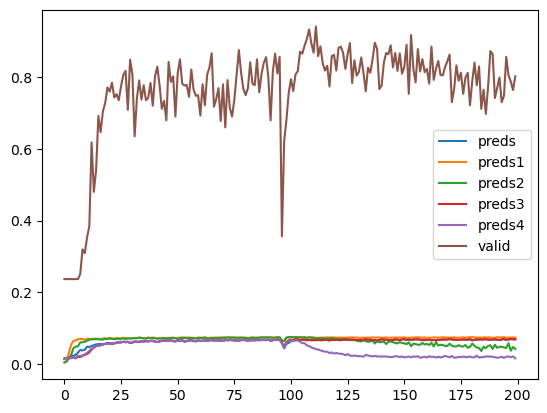

当前 [32, 0.0004, 10, 200, 25]

[0.9581478183437222, 0.9456812110418522, 0.9412288512911843]

0.948352626892253

===

[0.9479217588772467, 0.9414432885323002, 0.9441972796843714]

0.9445207756979728

===

[0.9486152799653944, 0.941641815342044, 0.9461181412028093]

0.9454584121700825

===

[0.9484501989158, 0.9424797278161419, 0.9445195420417347]

0.9451498229245588

===


In [11]:
def _freeze_norm_stats(net):
    for m in net.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()
lr = 0.0001
batch_size = 8
train_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop((224,224), scale=(0.75, 1.0)),
        transforms.RandomRotation((-15,15)),
        transforms.TrivialAugmentWide(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(),
    ])
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])

average_valid_results = []
average_f1_results = []
average_recall_results = []
average_precision_results = []

average_test_results = []
average_f1_results_test = []
average_recall_results_test = []
average_precision_results_test = []
for config in [[32,0.0004,10,200,25]]:
    
    alphas = [1,1,1]
    
    alpha1,alpha2,alpha3 = alphas
    average_valid_results = []
    average_f1_results = []
    average_recall_results = []
    average_precision_results = []

    average_test_results = []
    average_f1_results_test = []
    average_recall_results_test = []
    average_precision_results_test = []
    for seed in [2,1,0]:
        batch_size,lr,warmupepoch,epoch_num,select_batch_num = config
        alpha = 1
        
        lrcounter = 0
        seed4batch = seed
        T = 2
        cudnn.benchmark = False
        cudnn.deterministic = True
        torch.manual_seed(seed)  # 为CPU设置随机种子
        torch.cuda.manual_seed(seed)  # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # 为所有GPU设置随机种子
        random.seed(seed)
        np.random.seed(seed)



        def get_num_correct(out, labels):  #求准确率
            return out.argmax(dim=1).eq(labels).sum().item()

        
        path = '../v8-baselines/best'+str(seed)+'.pkl'

        model_generator = MSFIN('').cuda()
        

        optimizer_generator = torch.optim.Adam(model_generator.parameters(),lr=lr)
        
        scheduler_warmup_generator = GradualWarmupScheduler(optimizer_generator, multiplier=1, total_epoch=warmupepoch)
        optimizer_generator.zero_grad()
        optimizer_generator.step()
        
        
        maxval=0
        maxtest_followmaxval=0
        maxf1_followmaxval = 0
        maxrecall_followmaxval = 0
        maxprecision_followmaxval = 0
        
        maxf1_followmaxval_test = 0
        maxrecall_followmaxval_test = 0
        maxprecision_followmaxval_test = 0
        
        
        finaltestlabel_followmaxval = []
        finaltestlabel_pred_followmaxval = []

        earlystopcounter = 0

        T = 10
        minvalidloss = 99999

        val_loss_curve = []
        val_acc_curve = []
        test_acc_curve = []
        
        train_acc_1 = []
        train_acc_2 = []
        train_acc_3 = []
        train_acc_4 = []
        train_acc_5 = []
        
        idxlist = [i for i in range(train_len)]
        
        flag1 = 0
        flag2 = 0
        warm_end = False
        for epoch in tqdm(range(1,epoch_num+1)):

            scheduler_warmup_generator.step()
            np.random.seed(seed)
            np.random.shuffle(idxlist)
            
            total_loss=0
            valid_loss = 0
            train_correct=0
            test_correct = 0
            val_correct=0
            model_generator.train()
            model_generator.apply(_freeze_norm_stats)

            
            train_counter = 0
            
            #train_all = 0
            
            train_correct1 = 0
            train_correct2 = 0
            train_correct3 = 0
            train_correct4 = 0
            train_correct5 = 0
            
            def getBatch(len_dataset,batch_size):
                batch_num = len_dataset // batch_size
                batch_res = len_dataset % batch_size

                if batch_res>0:
                    batchlist = [batch_size] * batch_num + [batch_res]
                else:
                    batchlist = [batch_size] * batch_num
                return batchlist
            train_batch_list = getBatch(train_len,batch_size)
            
            for idx,b in enumerate(train_batch_list[:select_batch_num]):
                start = 0+sum(train_batch_list[:idx])
                end = 0+sum(train_batch_list[:idx+1])
                batchidxlist = idxlist[start:end]
                
            
                x = []
                y = []
                y2 = []
                for image_inbatch_id in batchidxlist:
                    d = trainset[image_inbatch_id]
                    x.append(train_transform(d[0]))
                    y.append(d[1])
                    y2.append(d[2])
                
                images = torch.stack(x,0).cuda()
                
                
                labels = torch.LongTensor(y).cuda()
                labels2 = torch.LongTensor(y2).cuda()
                
                
                one_hot_labels = F.one_hot(labels,10)
                one_hot_labels2 = F.one_hot(labels2,len_train_subs)
                fake_label = torch.ones_like(one_hot_labels).cuda()/10
                fake_label2 = torch.ones_like(one_hot_labels2).cuda()/len_train_subs


                optimizer_generator.zero_grad()

                preds,preds1,preds2,preds3,preds4 = model_generator(images,False)
                
                
                if warm_end:
                    loss = F.cross_entropy(preds,labels)

                    loss = loss + F.cross_entropy(preds1,labels2)
                    loss = loss + F.cross_entropy(preds3,labels)
                    loss = loss + F.kl_div(F.log_softmax(preds2,-1),fake_label2,reduction='batchmean')
                    loss = loss + F.kl_div(F.log_softmax(preds4,-1),fake_label,reduction='batchmean')

                else:
                    
                    loss = F.cross_entropy(preds,labels)

                    loss = loss + F.cross_entropy(preds1,labels2)
                    loss = loss + F.cross_entropy(preds3,labels)
                    
                loss.backward()
                optimizer_generator.step()

                total_loss+=loss.item()
                train_correct1+=get_num_correct(preds,labels)
                train_correct2+=get_num_correct(preds1,labels2)
                train_correct3+=get_num_correct(preds2,labels2)
                train_correct4+=get_num_correct(preds3,labels)
                train_correct5+=get_num_correct(preds4,labels)
            
            print('***训练集***')
            print('main branch：',train_correct1/select_batch_num/32)
            
            print('准确识别驾驶员：',train_correct2/select_batch_num/32)
            print('无法准确识别驾驶员：',train_correct3/select_batch_num/32)
            print('准确识别行为：',train_correct4/select_batch_num/32)
            print('无法准确识别行为：',train_correct5/select_batch_num/32)
            flag1 = train_correct2/select_batch_num/32
            flag2 = train_correct4/select_batch_num/32
            print('flag1',flag1,'flag2',flag2)
            if flag1 >= 0.9 and flag2 >= 0.9 and not warm_end:
                print('预热结束')
                warm_end = True
                optimizer_generator = torch.optim.Adam(model_generator.parameters(),lr=lr)
        
                scheduler_warmup_generator = GradualWarmupScheduler(optimizer_generator, multiplier=1, total_epoch=warmupepoch)
                optimizer_generator.zero_grad()
                optimizer_generator.step()

            
            valid_preds = []
            valid_labels = []
                
            model_generator.eval()
            with torch.no_grad():
                validxlist = [i for i in range(valid_len)]
                valid_batch_list = getBatch(valid_len,batch_size)
                
                for idx,b in enumerate(valid_batch_list):
                    start = 0+sum(valid_batch_list[:idx])
                    end = 0+sum(valid_batch_list[:idx+1])
                    batchidxlist = validxlist[start:end]

                    x = []
                    y = []
                    y2 = []
                    for image_inbatch_id in batchidxlist:
                        d = validset[image_inbatch_id]
                        
                        x.append(test_transform(d[0]))
                        y.append(d[1])
                        y2.append(d[2])

                    images = torch.stack(x,0).cuda()
                    labels = torch.LongTensor(y).cuda()
                    
                    _,_,_,preds,_ = model_generator(images)

                    loss = F.cross_entropy(preds,labels)
                    
                    valid_loss+=loss.item()
                    val_correct+=get_num_correct(preds,labels)
                    
                    valid_preds += preds.argmax(-1).cpu().numpy().tolist()
                    valid_labels += y
            
            F1=f1_score(valid_labels,valid_preds,average="macro")
            print("valid-f1:",F1)
            precision=precision_score(valid_labels,valid_preds,average="macro")
            print("valid-precision:",precision)
            recall=recall_score(valid_labels,valid_preds,average="macro")
            print("valid-recall:",recall)
            
            print('process:',epoch," loss:",total_loss," train_correct:",train_correct/train_len,'valid_loss',valid_loss," val_correct:",val_correct/valid_len)
            train_acc = train_correct/train_len
            val_acc=val_correct/valid_len
            
            train_acc_1.append(train_correct1/train_all)
            train_acc_2.append(train_correct2/train_all)
            train_acc_3.append(train_correct3/train_all)
            train_acc_4.append(train_correct4/train_all)
            train_acc_5.append(train_correct5/train_all)
            val_loss_curve.append(valid_loss)
            val_acc_curve.append(val_acc)
            
            
            if val_acc > maxval:
                
                maxval = val_acc
                maxf1_followmaxval = F1
                maxrecall_followmaxval = recall
                maxprecision_followmaxval = precision

                
                earlystopcounter = 0
                torch.save(model_generator.state_dict(), 'best'+str(seed)+'.pkl')
                print('The model has been saved!!')
                print('The best val_acc is ',maxval)
            
        x = range(len(val_loss_curve))


        plt.figure()
        
        plt.plot(x, train_acc_1,label = 'preds')
        plt.plot(x, train_acc_2,label = 'preds1')
        plt.plot(x, train_acc_3,label = 'preds2')
        plt.plot(x, train_acc_4,label = 'preds3')
        plt.plot(x, train_acc_5,label = 'preds4')

        plt.plot(x, val_acc_curve,label = 'valid')

        plt.legend()
        plt.show()
        average_valid_results.append(maxval)
        average_f1_results.append(maxf1_followmaxval)
        average_recall_results.append(maxrecall_followmaxval)
        average_precision_results.append(maxprecision_followmaxval)

    def summary(average_valid_results):
        print(average_valid_results)
        print(sum(average_valid_results)/len(average_valid_results))
        print('===')

    print('当前',config)
    summary(average_valid_results)
    summary(average_f1_results)
    summary(average_recall_results)
    summary(average_precision_results)

